## IMPORT LIBRARRIES

In [106]:
# Natural Language Processing libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

# General libraries
import numpy as np
import pandas as pd
import json

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

# Deep learning libraries
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

# Data manipulation
import numpy as np
import pandas as pd
import os

# Image processing
from PIL import Image
import cv2
from tensorflow.keras.preprocessing import image

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models and metrics
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, MaxPool2D, Embedding, GlobalMaxPool1D
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix

# Deep learning
from tensorflow.keras import layers, models, utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# GUI libraries
import tkinter as tk
from tkinter import filedialog, messagebox, StringVar, OptionMenu, Text, Entry, Button, Label, Toplevel

# Other libraries
from collections import Counter
from itertools import product
from keras.applications import VGG16
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
import datetime
import string
from wordcloud import WordCloud


#data source https://www.nature.com/articles/ncomms5212#MOESM1042

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
h1, h2 {
    text-align: center;
    background-color: #FFC0CB; 
    padding: 20px;
    margin: 0;
    color: #000; 
    font-family: Arial, sans-serif; 
}

h3 {
    text-align: center;
    border-style: solid;
    border-width: 3px;
    padding: 12px;
    margin: 0;
    color: #000; 
    font-family: Arial, sans-serif; 
    border-radius: 10px; 
    border-color: #FFD700; 
}

body, p {
    font-family: Arial, sans-serif; 
    font-size: 15px;
    color: #333; 
}

div {
    font-size: 14px;
    margin: 0;
}

h4 {
    padding: 0px;
    margin: 0;
    font-family: Arial, sans-serif; 
    color: #800080; 
}

table {
    border-collapse: collapse; 
    border: 1px solid #CCC; 
    margin: 0;
}

th, td {
    border: 1px solid #CCC; 
    padding: 8px;
}

th {
    background: #EDEDED; 
    font-weight: bold;
}

blockquote {
    background: #E6F2E6; 
    border-left: 3px solid #408040; 
    font-style: italic;
    padding-left: 10px; 
    margin-left: 0;
}

pre {
    background: #E0F0FF; 
    border-left: 5px solid #55AAFF; 
    padding: 10px; 
    margin-left: 0;
}

code {
    background: #E0F0FF; 
    font-family: 'JetBrains Mono NL', 'Courier New', monospace;
    font-size: 0.9em;
}
h1, h2, h3, h4, h5, h6 {
  background: #D4D4D4;
  border-top: 1px solid gray;
  border-bottom: 1px solid gray;
  font-weight: normal;
  padding-left: 2px;
  padding-right: 2px;
}
</style>
""")


In [3]:
#import two datasets and concatenate them
df_train = pd.read_csv('trainingData/symptom-disease-train-dataset.csv')
df_test = pd.read_csv('trainingData/symptom-disease-test-dataset.csv')

df_combined = pd.concat([df_train, df_test], ignore_index=True)

df = df_combined.sample(frac=1).reset_index(drop=True)
features = df['text']
labels = df['label']
labels.nunique()


1082

## EXPLORATORY DATA ANALYSIS

### Word Cloud Visualization

I will first start by creating a  word cloud to visualize the most common words in the symptom texts. This  will help in providing me with a graphical representation of word frequency. I will generate a word cloud visualization based on the combined symptom texts in my data frame. The plot will display the most common words in the text data, with word size proportional to frequency.



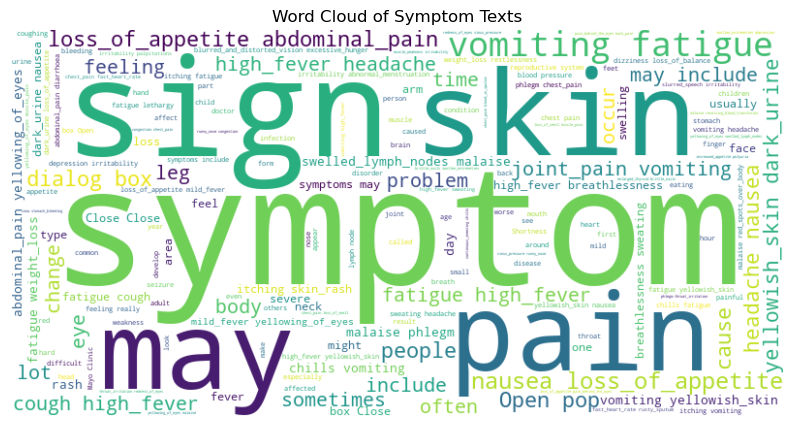

In [4]:
all_text = ' '.join(df['text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Symptom Texts')
plt.axis('off')
plt.show()



**Results for cloud visualization:**

After analyzing the word cloud, I've identified several dominant words such as "may," "symptoms," "may include," and "sign," among others. To enhance the effectiveness of model training, I intend to eliminate these dominant words as well as all punctuation marks and English stop words from the dataset, as they are unlikely to contribute significantly to the meaning.


In [5]:
#Check for missing values before preprocessing so i know how to deal with them
missing_symptoms = features.isnull().sum()
missing_labels = labels.isnull().sum()

print("Missing values in symptom column:", missing_symptoms)
print("Missing values in disease column:", missing_labels)


Missing values in symptom column: 0
Missing values in disease column: 0


### Text Length Distribution

I will proceeded with my EDA by Analyzing the distribution of text lengths (symptoms) to understand the range of lengths present in my dataset. This is going to help me determine the appropriate maximum sequence length for tokenization and padding.I will plot the distribution of text lengths to visualize the range of lengths present and the analyze the distribution to understand the typical and extreme lengths.

The standard deviation indicates a wide variation in text lengths, suggesting that padding sequences to a length significantly larger than the mean or median may lead to excessive padding for shorter texts. However, it can ensure that longer texts are not truncated. The maximum text length as shown from the cell below is quite large (2952), and setting the maximum sequence length close to this value may result in excessive memory usage and longer training times. I thought about applying normalization techniques,like the log transformation to reduce the impact of these extreme values or use z-score normalization to scale the lengths to a standard range. But after examining the number of columns with a length greater than 150 (which is 6% of the data), it seems reasonable to sacrifice them to save memory usage and also computational efficiency for normalizing the whole dataset. Therefore, I will choose a padding sequence of 150.

Percenatge of sequences longer than 150: 6.943064035212268


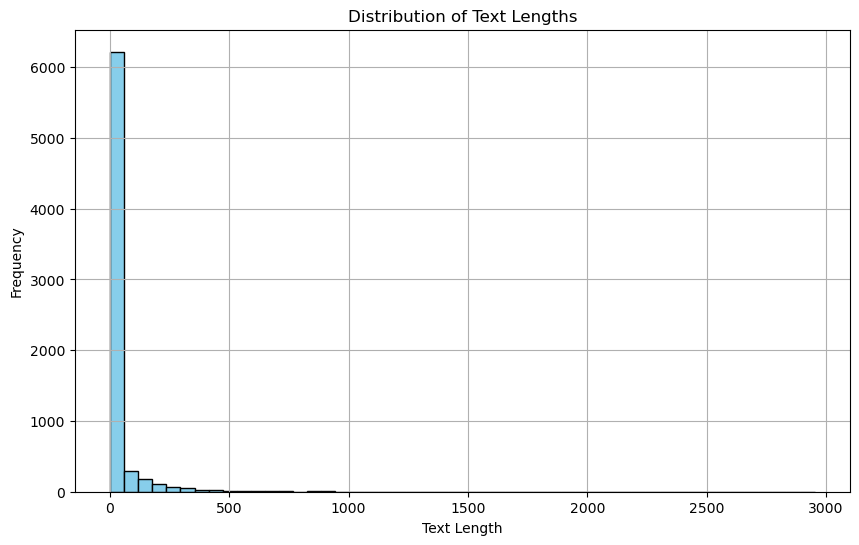

Maximum text length: 2952
Minimum text length: 1
Mean text length: 33.83969899190686
Median text length: 1.0
Standard deviation of text lengths: 109.59128843060701


In [6]:
max_sequence_length = 0
count_long_sequences = 0

# Distribution of the text features
for text in df['text']:
    # Tokenize text to sequences
    sequences = word_tokenize(text)
    # Calculate the length of  sequence
    sequence_length = len(sequences)   
    if sequence_length > 150:
        count_long_sequences += 1
    if sequence_length > max_sequence_length:
        max_sequence_length = sequence_length

print("Percenatge of sequences longer than 150:", (count_long_sequences/len(df))*100)


text_lengths = df['text'].apply(lambda x: len(x.split()))

# Plot the distribution of text lengths
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#  distribution analysis
print("Maximum text length:", max(text_lengths))
print("Minimum text length:", min(text_lengths))
print("Mean text length:", text_lengths.mean())
print("Median text length:", text_lengths.median())
print("Standard deviation of text lengths:", text_lengths.std())



### CLASS DISTRIBUTION

I will visualise the class distributions to further understand the distribution of the target labels (diseases) to see if they are balanced or imbalanced. As imbalanced classes might require special handling during model training like over or under sampling. . Addressing class imbalances is crucial to ensure that the model learns to generalize well across all classes and doesn't become biased towards predicting the majority class.

Percentage distribution of labels label
186     2.427943
822     2.427943
72      2.427943
515     2.427943
596     2.427943
          ...   
82      0.014198
1016    0.014198
844     0.014198
942     0.014198
195     0.014198
Name: count, Length: 1082, dtype: float64
Imbalance Ratio: 171.0
Percantage of data with counts of 1:  14.72383927303706


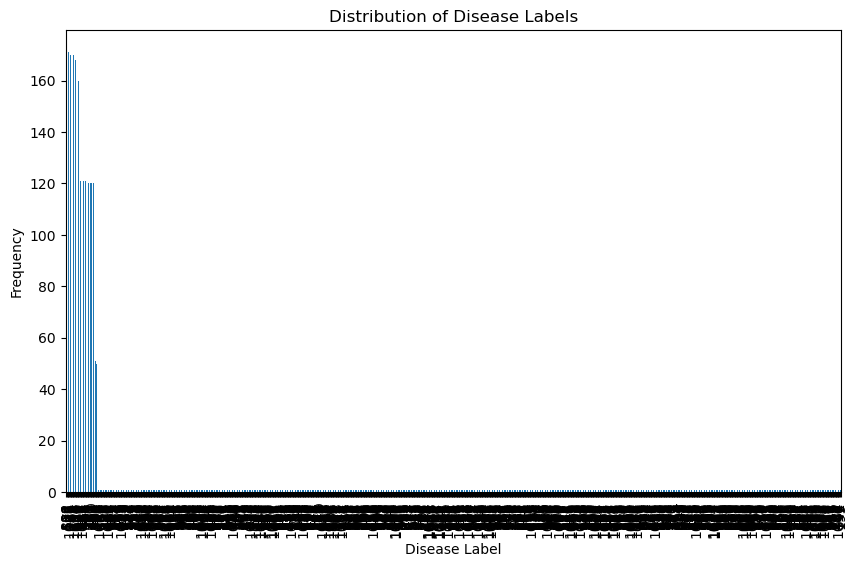

In [7]:
label_counts = labels.value_counts()

#percentage distribution of labels
label_percentage = label_counts / len(df) * 100
print("Percentage distribution of labels",label_percentage)

# The class imbalance ratio
imbalance_ratio = label_counts.max() / label_counts.min()
print("Imbalance Ratio:", imbalance_ratio)

import matplotlib.pyplot as plt

# Count the frequency of each label
label_counts = df['label'].value_counts()

# Plot label Distribution
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.xlabel('Disease Label')
plt.ylabel('Frequency')
plt.title('Distribution of Disease Labels')
#plt.show()

labels_to_remove = label_counts[label_counts == 1].index
length_of_ltr= len(labels_to_remove)
percetage_ltr= (length_of_ltr/len(df))*100
print("Percantage of data with counts of 1: ",percetage_ltr)




**Observation Results**

From the results below, we can see that the data has an imbalance ratio of 171 which is very high and indicates a great imbalance in the dataset.I observed a prevalence of classes with a count of 1, contributing to the high imbalance ratio among the classes. Initially, I contemplated removing labels with a count of 1 to address the imbalance, however this would entail sacrificing 14% of my already limited data sample. Given the small size of the dataset, such a reduction would compromise the robustness of the model during training.

Faced with the need for alternatives, I considered resampling or class weighing. Resampling emerged as the preferred choice due to its ability to augment the dataset without discarding valuable information. Unlike class weighting or specialized loss functions, resampling directly addresses the scarcity of data in minority classes by either oversampling or undersampling techniques.

Among the oversampling methods, I opted for SMOTE (Synthetic Minority Over-sampling Technique) over Random Oversampling. SMOTE generates synthetic samples by interpolating between existing minority class instances, thereby enhancing the diversity of the dataset. This approach is advantageous as it introduces new data points that closely resemble the existing minority class instances, promoting better generalization of the model without simply duplicating existing samples.

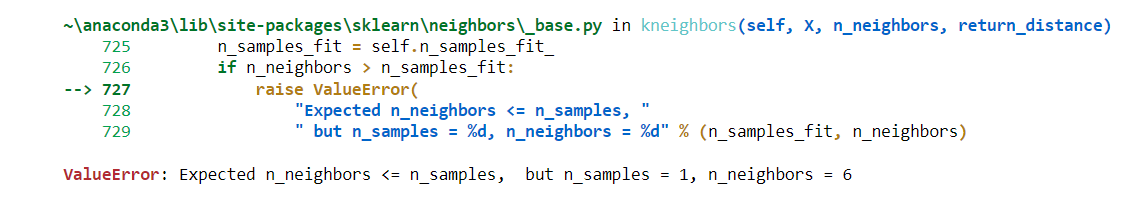
My attempts not to discard the data samples with a value count of 1 resulted in the error above, i even tried using different different variant of SMOTE, such as KNeighborsSMOTE and SMOTETomek but the value counts had to be greater than 6. So i had no choice than to discard the samples, which seemed like the second best option to sampling. I then plan to use the discarded samples as testing data to test my model to see how well it generalizes to unseen data.

### PREPROCESS THE TEXT USING INSIGHTS FROM THE EDA

1. **Tokenize the text**
2. **Remove dominant words, punctuation and stop words**
3. **Lemmatize**


In [8]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    '''
    Preprocesses the input text by tokenizing, removing stopwords, punctuation, and lemmatizing the words.

    Arguments:
    - text (str): The input text to be preprocessed.

    Returns:
    str: The preprocessed text after tokenization, removal of stopwords, punctuation, and lemmatization.
    '''
  
    tokens = word_tokenize(text)
    
    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    
    # Remove dominant words
    dominant_words = ["may", "symptoms", "may include", "sign", "also"]
    tokens = [word for word in tokens if word.lower() not in dominant_words]
    
    # Remove English stopwords
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    
    # Lemmatize the words
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    preprocessed_text = ' '.join(lemmatized_tokens)
    
    return preprocessed_text



In [9]:
#preprocess the filtered data
df_filtered= df.copy()
df_filtered['cleaned_text'] = df['text'].apply(preprocess_text)

df_filtered = df_filtered.drop(columns=['text'])
df_filtered.head()

label                                       cleaned_text
0    570  Legionnaires disease usually develops two 10 d...
1     35  continuous_sneezing shivering chill watering_f...
2     72  've experiencing stiffness weakness neck muscl...
3    745  Every nerve peripheral system specific functio...
4    193  itching skin_rash fatigue lethargy headache lo...

In [10]:
# Read the CSV file for second dataset
df = pd.read_csv('data/dataset.csv')

# Cleaning the data
df.isna().sum()
cols = df.columns
data = df[cols].values.flatten()
cols = df.columns

# Remove leading and trailing whitespaces
s = pd.Series(data)
s = s.str.strip()
s = s.values.reshape(df.shape)

df = pd.DataFrame(s, columns=df.columns)

# Fill NaN values with 0
df = df.fillna(0)
# Initialize an empty dictionary to store symptoms for each disease
symptoms_dict = {}

# Iterate through each row in the dataframe
for index, row in df.iterrows():
    disease = row['Disease']
    symptoms = set(row[1:])  # Exclude the first column which contains the disease
    
    # Convert symptoms to a list and remove any 0 values
    symptoms = [symptom for symptom in symptoms if symptom != 0]
    
    # Check if disease already exists in the dictionary
    if disease in symptoms_dict:
        # If disease already exists, extend the list of symptoms
        symptoms_dict[disease].extend(symptoms)
    else:
        # If disease not in dictionary, add it with the symptoms
        symptoms_dict[disease] = symptoms

# Convert the dictionary to a dataframe
symptoms_df = pd.DataFrame(symptoms_dict.items(), columns=['Disease', 'Symptoms'])

# Display the resulting dataframe
symptoms_df.head()



Disease                                           Symptoms
0     Fungal infection  [dischromic _patches, nodal_skin_eruptions, sk...
1              Allergy  [chills, watering_from_eyes, continuous_sneezi...
2                 GERD  [vomiting, chest_pain, stomach_pain, acidity, ...
3  Chronic cholestasis  [nausea, yellowish_skin, yellowing_of_eyes, lo...
4        Drug Reaction  [burning_micturition, skin_rash, spotting_ uri...

In [11]:
with open('trainingData/mapping.json', 'r') as file:
    data = json.load(file)

mapping = pd.DataFrame(list(data.items()), columns=['Disease', 'Label'])



In [12]:
# Standardize disease names

df_filtered['label'] = df_filtered['label'].map(mapping.set_index('Label')['Disease'])
df_filtered['label'] = df_filtered['label'].apply(lambda x: x.lower().strip())


In [13]:
df_filtered.head()

label                                       cleaned_text
0   legionnaires disease  Legionnaires disease usually develops two 10 d...
1                allergy  continuous_sneezing shivering chill watering_f...
2              arthritis  've experiencing stiffness weakness neck muscl...
3  peripheral neuropathy  Every nerve peripheral system specific functio...
4            chicken pox  itching skin_rash fatigue lethargy headache lo...

In [14]:
symptoms_df['Disease'] = symptoms_df['Disease'].apply(lambda x: x.lower().strip())

In [15]:
symptoms_df.head()

Disease                                           Symptoms
0     fungal infection  [dischromic _patches, nodal_skin_eruptions, sk...
1              allergy  [chills, watering_from_eyes, continuous_sneezi...
2                 gerd  [vomiting, chest_pain, stomach_pain, acidity, ...
3  chronic cholestasis  [nausea, yellowish_skin, yellowing_of_eyes, lo...
4        drug reaction  [burning_micturition, skin_rash, spotting_ uri...

In [16]:

merged_df = pd.merge(symptoms_df, df_filtered, left_on='Disease', right_on='label', how='inner')

# Drop the redundant 'label' column
merged_df.drop(columns=['label'], inplace=True)

# Display the first few rows of the merged dataset
merged_df[:-10]


Disease                                           Symptoms  \
0     fungal infection  [dischromic _patches, nodal_skin_eruptions, sk...   
1     fungal infection  [dischromic _patches, nodal_skin_eruptions, sk...   
2     fungal infection  [dischromic _patches, nodal_skin_eruptions, sk...   
3     fungal infection  [dischromic _patches, nodal_skin_eruptions, sk...   
4     fungal infection  [dischromic _patches, nodal_skin_eruptions, sk...   
...                ...                                                ...   
5895          impetigo  [skin_rash, yellow_crust_ooze, red_sore_around...   
5896          impetigo  [skin_rash, yellow_crust_ooze, red_sore_around...   
5897          impetigo  [skin_rash, yellow_crust_ooze, red_sore_around...   
5898          impetigo  [skin_rash, yellow_crust_ooze, red_sore_around...   
5899          impetigo  [skin_rash, yellow_crust_ooze, red_sore_around...   

                                           cleaned_text  
0      itching nodal_skin_eruptions dischromic__patches  
1     lot itchy spot skin 're sometimes red bumpy so...  
2     skin_rash nodal_skin_eruptions dischromic__pat...  
3     itching skin_rash nodal_skin_eruptions dischro...  
4      itching nodal_skin_eruptions dischromic__patches  
...                                                 ...  
5895  skin_rash high_fever red_sore_around_nose yell...  
5896  skin_rash high_fever blister red_sore_around_n...  
5897  skin_rash high_fever blister red_sore_around_nose  
5898  skin_rash high_fever blister red_sore_around_n...  
5899  high_fever blister red_sore_around_nose yellow...  

[5900 rows x 3 columns]

In [17]:
merged_df.shape

(5910, 3)

In [18]:
labels = merged_df['Disease']
features_emb = merged_df['cleaned_text']
features_dense= merged_df['Symptoms']

# Split data into training and testing sets
X_train_e, X_test_e, y_train, y_test = train_test_split(features_emb, labels, test_size=0.2, random_state=42)
X_train_d, X_test_d, y_train, y_test = train_test_split(features_dense, labels, test_size=0.2, random_state=42)

# Dense Layer Data Preprocessing
tokenizer_dense = keras.preprocessing.text.Tokenizer()
# apply only to X_train to prevent data leakage from the testing or validation data into the model
tokenizer_dense.fit_on_texts(X_train_d)
vocab_size_dense = len(tokenizer_dense.word_index) + 1

X_train_dense1 = tokenizer_dense.texts_to_matrix(X_train_d, mode='tfidf')  
X_test_dense = tokenizer_dense.texts_to_matrix(X_test_d, mode='tfidf')  

label_encoder = LabelEncoder()
# Flatten y_train and y_test if they are column vectors
if y_train.ndim > 1:
    y_train = np.ravel(y_train)
if y_test.ndim > 1:
    y_test = np.ravel(y_test)

#  label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# one-hot encoding
encoder = OneHotEncoder(sparse=False)
y_train = encoder.fit_transform(y_train_encoded.reshape(-1, 1))
y_test = encoder.transform(y_test_encoded.reshape(-1, 1))

num_classes = len(label_encoder.classes_)
print('Number of classes:', num_classes)

# Embedding Layer Data Preprocessing
max_words = 15000
tokenizer_embedding = keras.preprocessing.text.Tokenizer(num_words=max_words)
tokenizer_embedding.fit_on_texts(X_train_e)
vocab_size_embedding = len(tokenizer_embedding.word_index) + 1


sequences_train = tokenizer_embedding.texts_to_sequences(X_train_e)
sequences_test = tokenizer_embedding.texts_to_sequences(X_test_e)

max_len = 180
X_train_emb1 = keras.preprocessing.sequence.pad_sequences(sequences_train, maxlen=max_len, padding='post')
X_test_emb = keras.preprocessing.sequence.pad_sequences(sequences_test, maxlen=max_len, padding='post')

smote = SMOTE(random_state=42)

X_train_emb, y_train_emb = smote.fit_resample(X_train_emb1, y_train)
X_train_dense, y_train_dense = smote.fit_resample(X_train_dense1, y_train)


#PARTITION THE DATA FOR TAINING AND VALIDATION FOR DENSE LAYER
X_partial_train, X_validation, y_partial_train, y_validation = train_test_split(X_train_dense, y_train_dense, test_size=0.2, random_state=42)


#PARTITION THE DATA FOR TAINING AND VALIDATION FOR EMBEDDING LAYER
X_partial_train_emb, X_validation_emb, y_partial_train_emb, y_validation_emb = train_test_split(X_train_emb, y_train_emb, test_size=0.2, random_state=42)


print("Shapes after splitting:")
print("X_train_emb_resampled.shape:", X_train_emb.shape)
print("X_test_emb.shape:", X_test_emb.shape)
print("y_train_dnse resampled.shape:", y_train_dense.shape)
print("y_test_emb.shape:", y_test.shape)
print("X_train_dense_resampled.shape:", X_train_dense.shape)
print("X_test_dense.shape:", X_test_dense.shape)
print("y_train_emb_resampled.shape:", y_train_emb.shape)
print("y_test_dense.shape:", y_test.shape)


Number of classes: 41
Shapes after splitting:
X_train_emb_resampled.shape: (5740, 180)
X_test_emb.shape: (1182, 180)
y_train_dnse resampled.shape: (5740, 41)
y_test_emb.shape: (1182, 41)
X_train_dense_resampled.shape: (5740, 132)
X_test_dense.shape: (1182, 132)
y_train_emb_resampled.shape: (5740, 41)
y_test_dense.shape: (1182, 41)


# THE TRAINING WORKFLOW

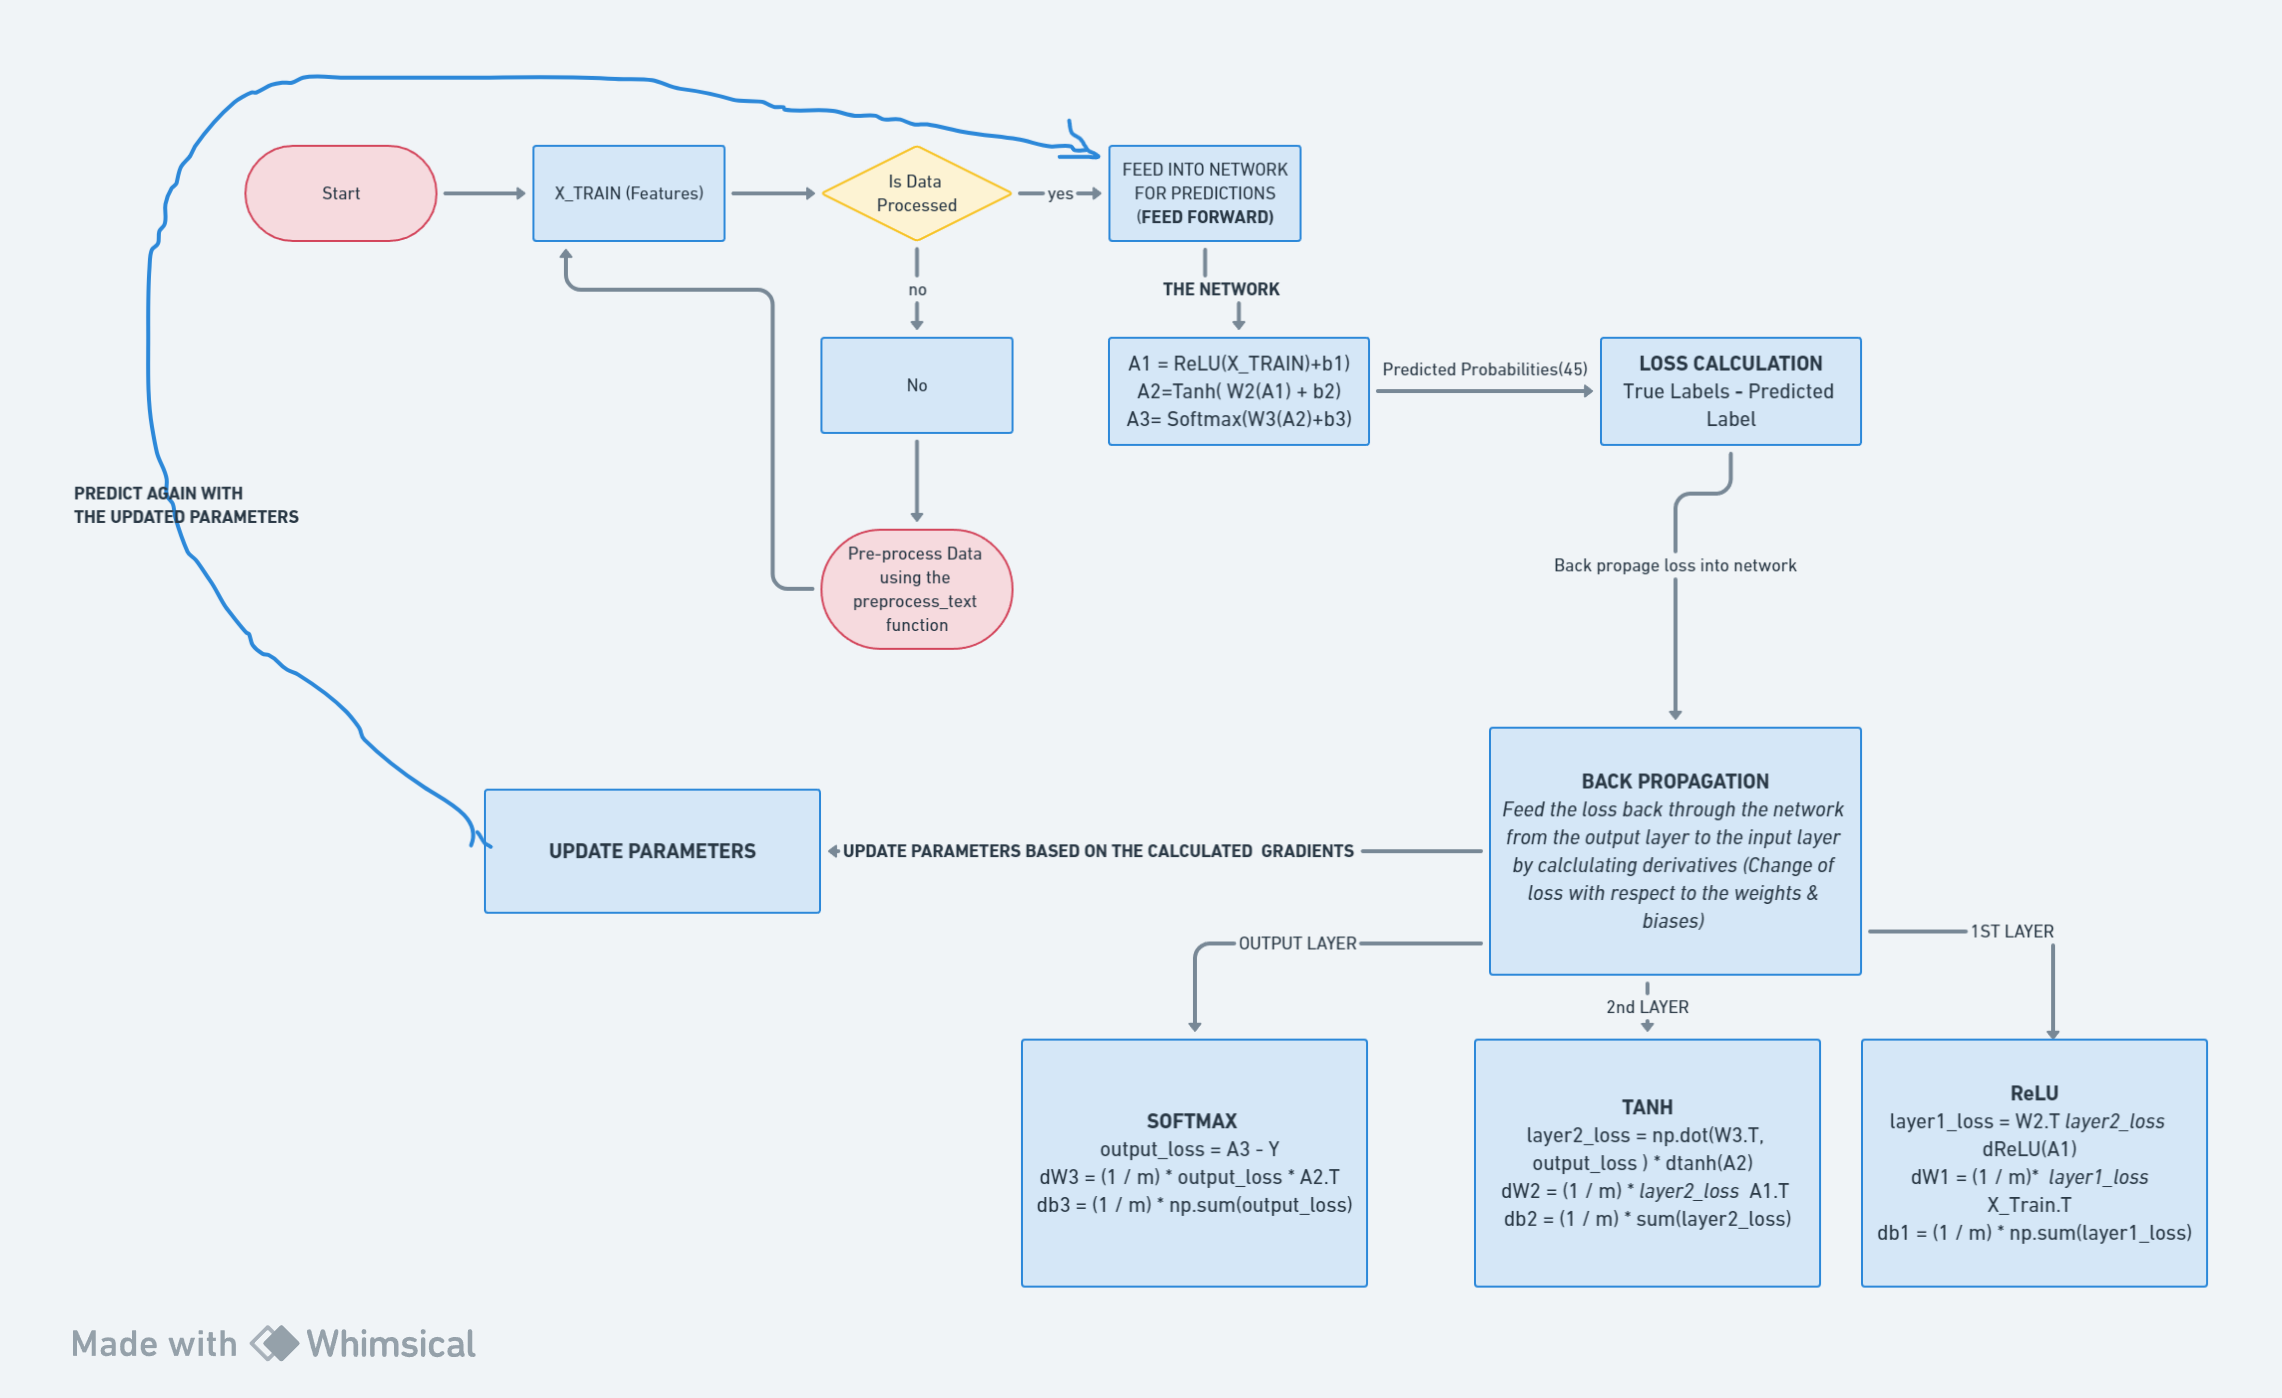

## PROBLEM TYPE

In my project, I tackle a multi-class single-label classification challenge focused on disease prediction from symptoms. With 45 unique disease classes in the dataset, my objective is to accurately predict the disease for each sample based on its symptoms. While accuracy serves as a primary metric for assessing model correctness, I prioritize recall due to the critical nature of disease prediction. Maximizing recall helps minimize false negatives, reducing the risk of missed diagnoses.

To achieve this, I employ ReLU, Tanh, and Softmax activation functions in various layers of my neural network. ReLU introduces non-linearity by zeroing out negative values, aiding in efficient learning of complex patterns. Tanh effectively captures non-linearities in hidden layers, crucial for extracting meaningful features from symptom data. Softmax in the output layer ensures output probabilities sum to 1, facilitating accurate multi-class classification.



## BASELINE MODEL
For the baseline model, simplicity is key. It consists of an input layer with 64 neurons and a hidden layer with a softmax activation function, suitable for multi-class classification. Parameters are randomly initialized, and simple gradient descent updates weights after backpropagation. Categorical cross-entropy loss function guides model accuracy.



In [115]:
class NeuralNetwork:
    def __init__(self):
        pass
    
    def init_params(self, input_size, hidden_size1, output_size):
        """
            Randomly Initialize parameters(weights and biases) for a neural network.

            Arguments:
            - input_size: Integer, the size of the input features.
            - hidden_size1: Integer, the number of neurons in the first hidden layer.
            - output_size: Integer, the number of neurons in the output layer.

            Returns:
            - parameters: Dictionary, containing the initialized weights and biases for each layer of the neural network.
              - "W": are weights where "b" are biases
        """
        np.random.seed(0)
        W1 = np.random.randn(hidden_size1, input_size) * 0.01
        b1 = np.zeros((hidden_size1, 1))
        W3 = np.random.randn(output_size, hidden_size1) * 0.01
        b3 = np.zeros((output_size, 1))
        parameters = {"W1": W1, "b1": b1, "W3": W3, "b3": b3}
        return parameters

    def forward_propagation(self, X, parameters):
        """
        Performs forward propagation through the neural network.

        Parameters:
        - X : Input data of shape (input_size, num_samples).
        - parameters (dict): Dictionary containing the weights and biases of the neural network.

        Returns:
        - A3 (numpy.ndarray): Output predictions of shape (output_size, num_samples).
        - cache (dict): Dictionary containing the intermediate values required for backpropagation.
        """

        
        W1, b1, W3, b3 = parameters["W1"], parameters["b1"], parameters["W3"], parameters["b3"]

        # Input layer
        Z1 = np.dot(W1, X.T) + b1  # preactivation layer
        A1 = self.ReLU(Z1)
        # Output layer
        Z3 = np.dot(W3, A1) + b3
        A3 = self.softmax(Z3)
        cache = {"Z1": Z1, "A1": A1, "Z3": Z3, "A3": A3}
        return A3, cache

    def backward_propagation(self, parameters, cache, X, Y):
        """
        Perform backward propagation through the neural network.

        Parameters:
        - parameters (dict): Dictionary containing the weights and biases of the neural network.
        - cache (dict): Dictionary containing the intermediate values from the forward pass.
        - X (numpy.ndarray): Input data of shape (input_size, num_samples).
        - Y (numpy.ndarray): True labels of shape (output_size, num_samples).

        Returns:
        - gradients (dict): Dictionary containing the gradients of the parameters.
        """

        m = X.shape[1]  # number of samples
        W1, b1, W3, b3 = parameters["W1"], parameters["b1"], parameters["W3"], parameters["b3"]

        # Retrieve cached values
        A1, A3, Z1 = cache["A1"], cache["A3"], cache["Z1"]

        # Compute gradients
        dZ3 = A3 - Y.T  
        dW3 = (1 / m) * np.dot(dZ3, A1.T)
        db3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)

        dA1 = np.dot(W3.T, dZ3)
        dZ1 = np.array(dA1, copy=True)
        dZ1[Z1 <= 0] = 0  # derivative of ReLU activation
        dW1 = 1 / m * np.dot(dZ1, X)
        db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)

        gradients = {"dW1": dW1, "db1": db1, "dW3": dW3, "db3": db3}

        return gradients

    def update_parameters(self, parameters, gradients, learning_rate=0.001):
        """
        Update the parameters of the neural network using gradient descent.

        Parameters:
        - parameters (dict): Dictionary containing the weights and biases of the neural network.
        - gradients (dict): Dictionary containing the gradients of the parameters.
        - learning_rate (float): Learning rate for gradient descent (default: 0.001).

        Returns:
        - updated_parameters (dict): Dictionary containing the updated weights and biases.
        """

        updated_parameters = {}
        for key in parameters:
            updated_parameters[key] = parameters[key] - learning_rate * gradients["d" + key]
        return updated_parameters

  
    def model_predict(self, X, parameters):
        """
        Make predictions using the trained neural network.

        Parameters:
        - X (numpy.ndarray): Input data of shape (num_samples, input_size).
        - parameters (dict): Dictionary containing the trained weights and biases.

        Returns:
        - predictions (numpy.ndarray): Predicted probabilities of shape (num_samples, output_size).
        """
        A2, _ = self.forward_propagation(X, parameters)
        predictions = A2.T
        return predictions

    def compute_accuracy(self, y_true, y_pred):
        """
        Compute the accuracy of the predicted labels.

        Parameters:
        - y_true (numpy.ndarray): True labels of shape (num_samples, output_size).
        - y_pred (numpy.ndarray): Predicted probabilities of shape (num_samples, output_size).

        Returns:
        - acc (float): Accuracy value.
        """
        # Converting predicted probabilities to class labels
        y_pred_labels = np.argmax(y_pred, axis=1)

        # Converting true labels from one-hot encoding to class labels
        y_true_labels = np.argmax(y_true, axis=1)

        # Computing accuracy
        correct_predictions = np.sum(y_pred_labels == y_true_labels)
        total_samples = y_true.shape[0]
        acc = correct_predictions / total_samples
        return acc

    def compute_recall(self, y_true, y_pred):
        """
        Compute recall for the multi-class classification problem.

        Arguments:
        y_true -- True labels in one-hot encoding format, shape (num_samples, num_classes)
        y_pred -- Predicted probabilities for each class, shape (num_samples, num_classes)

        Returns:
        recall -- Recall score for each class, shape (num_classes,)
        """
        # Converting predicted probabilities to class labels
        y_pred_labels = np.argmax(y_pred, axis=1)

        # Converting true labels from one-hot encoding to class labels
        y_true_labels = np.argmax(y_true, axis=1)

        # Initialize variables to store recall for each class
        num_classes = y_true.shape[1]
        recall = np.zeros(num_classes)

        # Compute recall for each class
        for c in range(num_classes):
            true_positive = np.sum((y_true_labels == c) & (y_pred_labels == c))
            actual_positive = np.sum(y_true_labels == c)

            # Handle division by zero
            if actual_positive == 0:
                recall[c] = 0
            else:
                recall[c] = true_positive / actual_positive

        return recall
    
    def compute_recall_weighted(self,y_true, y_pred):
        """
        Compute the weighted recall score.

        Parameters:
        - y_true (numpy.ndarray): True labels of shape (num_samples, num_classes).
        - y_pred (numpy.ndarray): Predicted probabilities of shape (num_samples, num_classes).

        Returns:
        - weighted_recall (float): Weighted recall score.
        """

        y_true_labels = np.argmax(y_true, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)

        # Compute the weighted recall score
        weighted_recall = recall_score(y_true_labels, y_pred_labels, average='weighted',zero_division=1)

        return weighted_recall
    
    def categorical_cross_entropy_loss(self, A3, Y):
        """
        Arguments:
        A3 --  predicted probabilities of a sample belonging to each class
        Y -- true "label" vector,one hot encoded 
        Returns:
        loss -- Scalar value representing the categorical cross-entropy loss
        """

        m = Y.shape[0]  # Number of samples
        epsilon = 1e-15  # Small value to avoid taking the logarithm of zero

        A_clipped = np.clip(A3, epsilon, 1 - epsilon)
        Y = Y.T
        loss = -(1 / m) * np.sum(Y * np.log(A_clipped))

        return loss

    def ReLU(self, Z):
        """
        Compute the Rectified Linear Unit (ReLU) activation function.

        Parameters:
        - Z (numpy.ndarray): Input values.

        Returns:
        - A (numpy.ndarray): Output of the ReLU activation function.
        """
        return np.maximum(0, Z)

    def softmax(self, Z):
        """
        Compute the softmax activation function.

        Parameters:
        - Z (numpy.ndarray): Input values.

        Returns:
        - A (numpy.ndarray): Output of the softmax activation function.
        """
        exp_Z = np.exp(Z - np.max(Z, axis=0))  
        return exp_Z / (np.sum(exp_Z, axis=0) + 1e-15)

    def tanh(self, Z):
        """
        Compute the hyperbolic tangent (tanh) activation function.

        Parameters:
        - Z (numpy.ndarray): Input values.

        Returns:
        - A (numpy.ndarray): Output of the tanh activation function.
        """
        return np.tanh(Z)
    
    
    
    def train_neural_network(self, X, Y, input_size, hidden_size1, output_size, learning_rate, num_epochs,print_loss=True):
        """
        Train the neural network. Takes input--->Make predictions--->Calclulate the loss--->Backpropagate 
        it through the network--->Update parameters (REPEAT for epochs)
   
        Parameters:
        - X (numpy.ndarray): Input data of shape (num_samples, input_size).
        - Y (numpy.ndarray): True labels of shape (num_samples, output_size).
        - input_size (int): Number of features in the input data.
        - hidden_size1 (int): Number of units in the first hidden layer.
        - output_size (int): Number of output classes.
        - learning_rate (float): Learning rate for gradient descent.
        - num_epochs (int): Number of training epochs.
        - print_loss (bool): Whether to print the loss during training (default: True).

        Returns:
        - parameters (dict): Dictionary containing the trained weights and biases.
        - losses (list): List of loss values during training.
        - train_accuracies (list): List of training accuracies during training.
        - recalls (list): List of training recalls during training.
        """
        # Initialize parameters
        parameters = self.init_params(input_size, hidden_size1, output_size)

        losses = []
        train_accuracies = []
        recalls = []

        for epoch in range(1, num_epochs + 1):
            # Forward propagation
            A3, cache = self.forward_propagation(X, parameters)
            loss = self.categorical_cross_entropy_loss(A3, Y)
            predictions = self.model_predict(X, parameters)
            train_accuracy = self.compute_accuracy(predictions, Y)
            train_recall = self.compute_recall(predictions, Y)
            # Backward propagation
            gradients = self.backward_propagation(parameters, cache, X, Y)

            # Update parameters using update_params

            parameters = self.update_parameters(parameters, gradients, learning_rate)

            if print_loss and epoch % 10 == 0:
                print(f"Loss: {loss} Training Accuracy:  {train_accuracy}  after epoch {epoch}")

            losses.append(loss)
            train_accuracies.append(train_accuracy)
            recalls.append(train_recall)

        return parameters, losses, train_accuracies, recalls

    
    
    def plot_learning(self, data, ylabel):
        """
        Plot the learning curve.

        Parameters:
        - data (list or numpy.ndarray): Data to plot.
        - ylabel (str): Label for the y-axis.
        """
        plt.plot(data)
        plt.xlabel('Epochs')
        plt.ylabel(ylabel)
        plt.title('Training Performance: ' + ylabel)
        plt.show()

    def plot_learning_val(self, train_data, val_data, ylabel):
        """
        Plot the learning curves for training and validation data.

        Parameters:
        - train_data (list): List of training data for each epoch.
        - val_data (list): List of validation data for each epoch.
        - ylabel (str): Label for the y-axis.
        """
        min_length = min(len(inner) for inner in train_data + val_data)

        average_train_history = [np.mean([x[i] for x in train_data]) for i in range(min_length)]
        average_val_history = [np.mean([x[i] for x in val_data]) for i in range(min_length)]

        epochs = range(1, min_length + 1)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, average_train_history, label="Training")
        plt.plot(epochs, average_val_history, label="Validation")
        plt.xlabel('Epochs')
        plt.ylabel(ylabel)
        plt.title('Training and Validation Performance: ' + ylabel)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs[-10:], average_train_history[-10:], label="Training")
        plt.plot(epochs[-10:], average_val_history[-10:], label="Validation")
        plt.xlabel('Epochs')
        plt.ylabel(ylabel)
        plt.title('Last 10 Epochs Performance: ' + ylabel)
        plt.legend()

        plt.tight_layout()
        plt.show()

    def evaluate_model_performance(self, X_test, y_test, trained_parameters):
        """
        Evaluate the performance of the trained model on the test data.

        Parameters:
        - X_test (numpy.ndarray): Test input data.
        - y_test (numpy.ndarray): True labels for the test data.
        - trained_parameters (dict): Trained parameters of the model.
        """
        # Get predictions from the model
        prediction_test = self.model_predict(X_test, trained_parameters)

        # Compute accuracy, loss, and recall
        test_accuracy = self.compute_accuracy(prediction_test, y_test)
        test_loss = self.categorical_cross_entropy_loss(prediction_test, y_test.T)
        test_recall = self.compute_recall_weighted(prediction_test, y_test)

        print(f"Model test predictions gave an Accuracy of : {test_accuracy} and Recall of : {test_recall} and a Loss of : {test_loss}")

        # Convert predicted probabilities to class labels
        y_pred_labels = np.argmax(prediction_test, axis=1)

        # Convert true labels from one-hot encoding to class labels
        y_true_labels = np.argmax(y_test, axis=1)

        # Compute metrics using scikit-learn functions
        test_acc = accuracy_score(y_pred_labels, y_true_labels)
        test_precision = precision_score(y_pred_labels, y_true_labels, average='weighted')
        test_recall = recall_score(y_pred_labels, y_true_labels, average="weighted")

        print("Test accuracy with libraries:", test_acc, "Recall score:", test_recall, "Precision for the test:", test_precision)


Loss: 3.7994031192667506 Training Accuracy:  0.20162509448223734  after epoch 10
Loss: 3.791249138727712 Training Accuracy:  0.4246031746031746  after epoch 20
Loss: 3.7808790416703486 Training Accuracy:  0.5266439909297053  after epoch 30
Loss: 3.7666822798749817 Training Accuracy:  0.5808767951625095  after epoch 40
Loss: 3.746327808273406 Training Accuracy:  0.5523431594860166  after epoch 50
Loss: 3.7164319907185774 Training Accuracy:  0.531557067271353  after epoch 60
Loss: 3.6721596620838257 Training Accuracy:  0.4512471655328798  after epoch 70
Loss: 3.607345705576162 Training Accuracy:  0.4255479969765684  after epoch 80
Loss: 3.5170226515752048 Training Accuracy:  0.39777021919879063  after epoch 90
Loss: 3.4028838686730762 Training Accuracy:  0.36904761904761907  after epoch 100


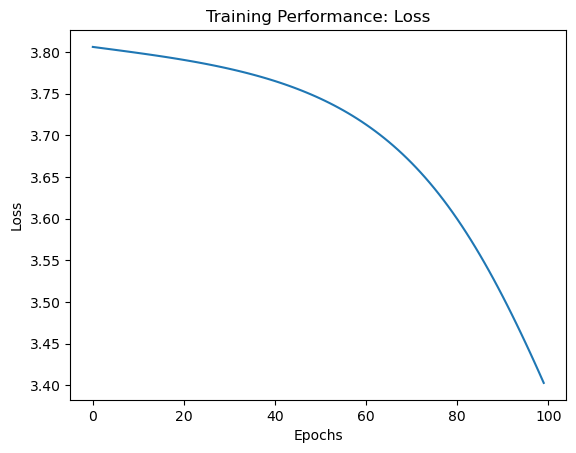

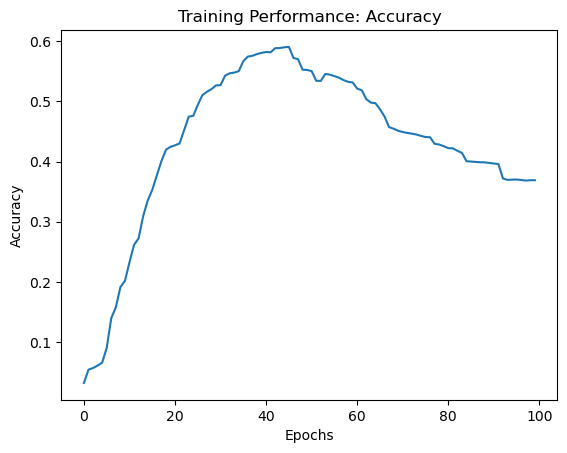

Model test predictions gave an Accuracy of : 0.3544973544973545 and Recall of : 0.3544973544973545 and a Loss of : 100.2718690651774
Test accuracy with libraries: 0.3544973544973545 Recall score: 0.3544973544973545 Precision for the test: 0.9337223956859505


C:\Users\patty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
#TRAINING 
neural_network = NeuralNetwork()
trained_parameters_baseline, losses_baseline ,accuracies_baseline, recalls_baseline= neural_network.train_neural_network(X_partial_train, y_partial_train, input_size=vocab_size_dense, hidden_size1=64, output_size=num_classes, num_epochs=100, learning_rate=0.02, print_loss=True)

neural_network.plot_learning(losses_baseline,'Loss')
neural_network.plot_learning(accuracies_baseline, 'Accuracy')

#EVALUATION
neural_network.evaluate_model_performance(X_validation, y_validation, trained_parameters_baseline)

# EXPERIMENT 1

In an attempt to improve my baseline perfomance, building upon the foundation of my existing architecture, i created a more deeper neural network inorder to beat the baseline accuarcy of 35.4% , recall of 35.4% and a loss of 100. This architecture consist of three layers: an input layer employing Rectified Linear Unit (ReLU) activation with **128 neurons**, a hidden layer utilizing hyperbolic tangent **(tanh) activation with 64 neurons**, and an output layer employing softmax activation with 45 neurons corresponding to the unique number of classes in the dataset.I also increased the number of iterations from 100 to **200** becaused I noticed the erratic behavior of the accuracy, oscillating back and forth like a pendulum and by extending the training duration, the aim was to ensure that the model had sufficient time to converge to the global minimum of the loss function, thereby mitigating the risk of settling for a suboptimal solution characterized by local minima.I also used a different and more complex optimizer function , **adam** from the basic gradient descent because of its ability for adaptive learning rates and dynamic adjustments, i believe this will help to steer my model towards faster convergence and, hopefully, superior performance.

In [116]:
class ModifiedNeuralNetwork(NeuralNetwork):
    def __init__(self):
        super().__init__()  # the parent class

    def init_params(self, input_size, hidden_size1, hidden_size2, output_size):
        """
        Initialize parameters for a neural network.

        Arguments:
        - input_size: Integer, the size of the input features.
        - hidden_size1: Integer, the number of neurons in the first hidden layer.
        - hidden_size2: Integer, the number of neurons in the second hidden layer.
        - output_size: Integer, the number of neurons in the output layer.

        Returns:
        - parameters: Dictionary, containing the initialized weights and biases for each layer of the neural network.
          - "W": are weights where "b" are biases
        """
        np.random.seed(0)
        W1 = np.random.randn(hidden_size1, input_size) * 0.01
        b1 = np.zeros((hidden_size1, 1))
        W2 = np.random.randn(hidden_size2, hidden_size1) * 0.01
        b2 = np.zeros((hidden_size2, 1))
        W3 = np.random.randn(output_size, hidden_size2) * 0.01
        b3 = np.zeros((output_size, 1))
        parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
        return parameters

    def categorical_cross_entropy_loss(self, A3, Y):
        """
        Arguments:
        A3 -- predicted probabilities of a sample belonging to each class
        Y -- true "label" vector, one hot encoded
        Returns:
        loss -- Scalar value representing the categorical cross-entropy loss
        """
        m = Y.shape[0]  # Number of samples
        epsilon = 1e-15  # Smal value to avoid taking the logarithm of zero
        #we clip tom prevent compuational stability during log calcluation
        A_clipped = np.clip(A3, epsilon, 1 - epsilon)
        Y = Y.T
        loss = -(1 / m) * np.sum(Y * np.log(A_clipped))
        return loss

    def forward_propagation(self, X, parameters):
        """
        Perform forward propagation through the neural network.

        Arguments:
        - X: input data.
        - parameters: Dictionary, containing the weights and biases for each layer of the neural network from init_params function

        Returns:
        - A3: Array, shape (num_classes, num_samples), output probabilities for each class.
        - cache: Dictionary, with arrays of shape(layer_size, num_samples)
          - "Z1": preactivation values for the input layer.
          - "A1": activated values for the input layer.
          - "Z2": preactivation values for the 2nd hidden layer.
          - "A2": activation values for the 2nd hidden layer.
          - "Z3": preactivation values for the output layer.
          - "A3": output probabilities for each class.
        """
        W1, b1, W2, b2, W3, b3 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"], parameters[
            "W3"], parameters["b3"]

        # Input layer
        Z1 = np.dot(W1, X.T) + b1  # preactivation layer
        A1 = self.ReLU(Z1)
        # Hidden layer
        Z2 = np.dot(W2, A1) + b2
        A2 = self.tanh(Z2)
        # Output layer
        Z3 = np.dot(W3, A2) + b3
        A3 = self.softmax(Z3)
        cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2, "Z3": Z3, "A3": A3}
        return A3, cache

    def backward_propagation(self, parameters, cache, X, Y):
        """
        Compute the gradients of the loss with respect to the parameters using backpropagation.

        Arguments:
        X -- Input data, shape (input_size, num_samples)
        Y -- True labels, shape (output_size, num_samples)
        cache -- Dictionary containing the intermediate values from forward propagation
        parameters -- Dictionary containing the model's parameters
        Returns:
        gradients -- Dictionary containing the gradients of the loss with respect to each parameter
        """
        m = X.shape[1]  # number of samples in the batch
        W1, b1, W2, b2, W3, b3 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"], parameters[
            "W3"], parameters["b3"]

        # Retrieve cached values
        A1, A2, A3 = cache["A1"], cache["A2"], cache["A3"]
        Z1, Z2, Z3 = cache["Z1"], cache["Z2"], cache["Z3"]

        # Computing gradients
        dZ3 = A3 - Y.T  #derivative of softamx
        dW3 = 1 / m * np.dot(dZ3, A2.T)
        db3 = 1 / m * np.sum(dZ3, axis=1, keepdims=True)

        dA2 = np.dot(W3.T, dZ3)
        dZ2 = dA2 * (1 - np.power(A2, 2))  # derivative of tanh activation(1-tanh**2(z))
        dW2 = 1 / m * np.dot(dZ2, A1.T)
        db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)

        dA1 = np.dot(W2.T, dZ2)
        dZ1 = np.array(dA1, copy=True)
        dZ1[Z1 <= 0] = 0  # derivative of ReLU activation
        dW1 = 1 / m * np.dot(dZ1, X)
        db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)

        gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3": db3}

        return gradients

    def update_parameters(self, parameters, gradients, v, s, t, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-15):
        """
         optimization algorithm to update the parameters of the neural network by combining momentum 
          and RMSprop techniques to achieve faster and more stable convergence during training.
        Arguments:
        parameters -- Dictionary containing the model's parameters
        gradients -- Dictionary containing the gradients of the loss with respect to each parameter
        v -- Dictionary containing the exponentially weighted average of the gradients
        s -- Dictionary containing the exponentially weighted average of the squared gradients
        t -- Current timestep (iteration)
        learning_rate -- Learning rate for the update
        beta1 -- Exponential decay rate for the first moment estimate
        beta2 -- Exponential decay rate for the second moment estimate
        epsilon -- Small value to avoid division by 0

        Returns:
        parameters -- Updated parameters
        v -- Updated exponentially weighted average of the gradients
        s -- Updated exponentially weighted avg of the squared gradients
        """
        for param_name in parameters.keys():
            # Update biased 1st moment estimate
            v[param_name] = beta1 * v[param_name] + (1 - beta1) * gradients["d" + param_name]
            s[param_name] = beta2 * s[param_name] + (1 - beta2) * np.square(gradients["d" + param_name])
            #Correcting Bias in Moment Estimates:
            v_corrected = v[param_name] / (1 - beta1**t)
            s_corrected = s[param_name] / (1 - beta2**t)
             #Updating Parameters:
            parameters[param_name] -= learning_rate * v_corrected / (np.sqrt(s_corrected) + epsilon)

        return parameters, v, s

    def train_neural_network(self, X, Y, input_size, hidden_size1, hidden_size2, output_size, learning_rate, num_epochs, print_loss=True):
        parameters = self.init_params(input_size, hidden_size1, hidden_size2, output_size)
        """
        Train a neural network model Takes input(X)--->Make predictions--->Calclulate the loss(compare with Y)--->Backpropagate 
        it through the network--->Update parameters (REPEAT for epochs)
        Arguments:
        X -- Input data of shape (num_samples, input_size)
        Y -- True labels of shape (num_samples, output_size)
        input_size -- Number of features in the input data
        hidden_size1 -- Number of neurons in the first hidden layer(128)
        hidden_size2 -- Number of neurons in the second hidden layer(64)
        output_size -- Number of output classes(45)
        learning_rate -- Learning rate for gradient descent
        num_epochs -- Number of training epochs
        print_loss -- Boolean  to print the loss during training (default is True)

        Returns:
        parameters -- Trained parameters of the neural network
        losses -- List of loss values at each epoch during training
        """

        # Initialize variables for optimizer
        v = {key: np.zeros_like(value) for key, value in parameters.items()}
        s = {key: np.zeros_like(value) for key, value in parameters.items()}
        t = 0

        losses = []
        accuracies = []
        recalls = []

        for epoch in range(1, num_epochs + 1):
            A3, cache = self.forward_propagation(X, parameters)
            loss = self.categorical_cross_entropy_loss(A3, Y)
            predictions = self.model_predict(X, parameters)
            train_accuracy = self.compute_accuracy(predictions, Y)
            train_recall = self.compute_recall(predictions, Y)
            gradients = self.backward_propagation(parameters, cache, X, Y)
            t += 1
            parameters, v, s = self.update_parameters(parameters, gradients, v, s, t, learning_rate)

            if print_loss and epoch % 20 == 0:
                print(f"Loss : {loss}  Accuracy: {train_accuracy} after epoch {epoch}")

            losses.append(loss)
            accuracies.append(train_accuracy)
            recalls.append(train_recall)

        return parameters, losses, accuracies, recalls


Loss : 0.002981290036821916  Accuracy: 1.0 after epoch 20
Loss : 0.0002695047777330519  Accuracy: 1.0 after epoch 40
Loss : 0.00016291607020986406  Accuracy: 1.0 after epoch 60
Loss : 0.0001376596867255174  Accuracy: 1.0 after epoch 80
Loss : 0.00012356835814901712  Accuracy: 1.0 after epoch 100


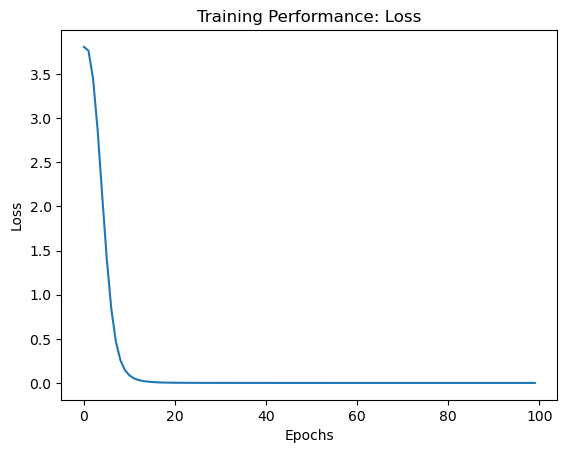

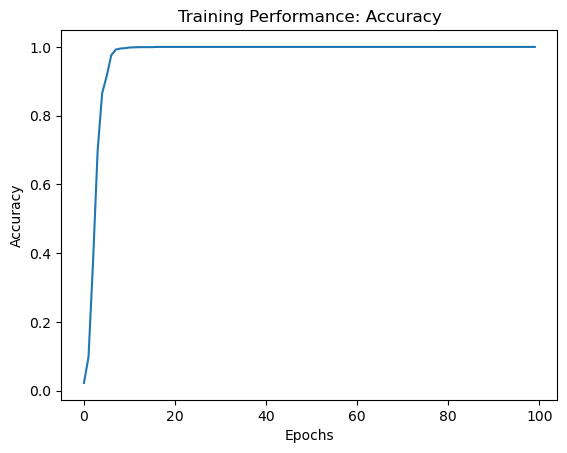

Model test predictions gave an Accuracy of : 0.981859410430839 and Recall of : 0.981859410430839 and a Loss of : 2.725777808194345
Test accuracy with libraries: 0.981859410430839 Recall score: 0.981859410430839 Precision for the test: 0.9836716473740683


In [16]:
# EXPERIMENT 1 TRAINING
exp1_neural_network= ModifiedNeuralNetwork()
trained_parameters, losses, accuracies,recalls = exp1_neural_network.train_neural_network(X_partial_train, y_partial_train, input_size=vocab_size_dense, hidden_size1=128, hidden_size2=64, output_size=num_classes, num_epochs=100, learning_rate=0.02, print_loss=True)

exp1_neural_network.plot_learning(losses, 'Loss')
exp1_neural_network.plot_learning(accuracies, 'Accuracy')

#EVALUATION
exp1_neural_network.evaluate_model_performance(X_validation, y_validation, trained_parameters)

# EXPERIMENT 2 

After completing my initial experiment, I noticed that the loss had decreased greatly and the accuracy had also peaked to above 90% from 30%. As I continued looking for ways to enhance the performance of my neural network model, I explored alternative weight initialization techniques, including Xavier and He initialization, instead of just randomly initializing the parameters, to mitigate issues such as gradient vanishing or exploding during training,  Furthermore, I introduced regularization techniques. However, during training, I encountered challenges with excessively high loss and descreasing accuracy, leading to premature termination of the training process.

I think that the high learning rate (lr) and strong regularization (l2) parameters might have contributed to the observed issues. Since a high learning rate can cause the model to overshoot the optimal parameters during training, resulting in instability and poor convergence. Similarly, excessive L2 regularization can overly penalize the model's parameters, leading to a high bias and reduced model capacity, thereby hindering its ability to capture complex patterns in the data.

Reducing the learning rate from 0.02 to 0.005 aims to mitigate the overshooting problem by taking smaller steps towards the optimal parameters, thereby enhancing stability and convergence. Additionally, decreasing the regularization parameter from 0.01 to 0.001 aims to strike a better balance between bias and variance in the model. By reducing the strength of regularization, I aim to allow the model more flexibility to capture nuanced patterns in the data without excessively penalizing the parameters.

#### TERMINATED TRAINING CYCLE

In [18]:
class NeuralNetworkExperiment2(ModifiedNeuralNetwork):
    def __init__(self):
        super().__init__()

    def init_params(self, input_size, hidden_size1, hidden_size2, output_size, initialization='xavier'):
        """
        Initialize the parameters of the neural network with specified sizes using either He or Xavier initialization.

        Arguments:
        - input_size: Integer, the size of the input features.
        - hidden_size1: Integer, the number of neurons in the first hidden layer.
        - hidden_size2: Integer, the number of neurons in the second hidden layer.
        - output_size: Integer, the number of neurons in the output layer.

        Returns:
        - parameters: Dictionary, containing the initialized weights and biases for each layer of the neural network.
          - "W": are weights where "b" are biases
        """
        np.random.seed(0)
        if initialization == 'he':
            # He initialization
            W1 = np.random.randn(hidden_size1, input_size) * np.sqrt(2 / input_size)
            W2 = np.random.randn(hidden_size2, hidden_size1) * np.sqrt(2 / hidden_size1)
            W3 = np.random.randn(output_size, hidden_size2) * np.sqrt(2 / hidden_size2)
        elif initialization == 'xavier':
            # Xavier initialization
            W1 = np.random.randn(hidden_size1, input_size) * np.sqrt(1 / input_size)
            W2 = np.random.randn(hidden_size2, hidden_size1) * np.sqrt(1 / hidden_size1)
            W3 = np.random.randn(output_size, hidden_size2) * np.sqrt(1 / hidden_size2)
        else:
            raise ValueError("Invalid initialization type. Use 'he' or 'xavier'.")

        b1 = np.zeros((hidden_size1, 1))
        b2 = np.zeros((hidden_size2, 1))
        b3 = np.zeros((output_size, 1))

        parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}

        return parameters

    def train_neural_network(self, X, Y, input_size, hidden_size1, hidden_size2, output_size, learning_rate, num_epochs, l2_reg_lambda=0.01, print_loss=True):
        """
        Training a neural network model with stochastic gradient descent with L2 regularization
        Argument: l2_reg_lambda -- Regularization parameter for L2 regularization and the default being 0.01
        Returns:
        parameters -- Trained parameters of the neural network
        losses -- List of loss values at each epoch during training
        accuracies -- List of accuracies at each epoch during training
        """
        parameters = self.init_params(input_size, hidden_size1, hidden_size2, output_size)

        # Initialize variables for optimizer
        v = {key: np.zeros_like(value) for key, value in parameters.items()}
        s = {key: np.zeros_like(value) for key, value in parameters.items()}
        t = 0

        losses = []
        accuracies = []
        recalls = []
        for epoch in range(1, num_epochs + 1):
            A3, cache = self.forward_propagation(X, parameters)
            loss = self.categorical_cross_entropy_loss(A3, Y)

            # L2 regularization
            l2_regularization_cost = 0
            for key in parameters.keys():
                if key.startswith('W'):  # apply regularization to weight matrices only
                    l2_regularization_cost += np.sum(np.square(parameters[key]))
            loss += 0.5 * l2_reg_lambda * l2_regularization_cost

            predictions = self.model_predict(X, parameters)
            train_accuracy = self.compute_accuracy(predictions, Y)
            train_recall = self.compute_recall(predictions, Y)
            gradients = self.backward_propagation(parameters, cache, X, Y)
            t += 1
            parameters, v, s = self.update_parameters(parameters, gradients, v, s, t, learning_rate)

            if print_loss and epoch % 20 == 0:
                print(f"Loss: {loss}, Accuracy: {train_accuracy}  after epoch - {epoch}")

            losses.append(loss)
            accuracies.append(train_accuracy)
            recalls.append(train_recall)

        return parameters, losses, accuracies, recalls

exp2_neural_network= NeuralNetworkExperiment2()

trained_parameters_exp2, losses_exp2, accuracies_exp2, recalls_exp2 = exp2_neural_network.train_neural_network(X_partial_train, y_partial_train, input_size=vocab_size_dense, hidden_size1=128, hidden_size2=64, output_size=num_classes, num_epochs=200, learning_rate=0.02, print_loss=True)




Loss: 13.693848380814426, Accuracy: 1.0  after epoch - 20
Loss: 18.280225800952493, Accuracy: 1.0  after epoch - 40
Loss: 19.327166075238345, Accuracy: 1.0  after epoch - 60
Loss: 19.645304514606543, Accuracy: 1.0  after epoch - 80
Loss: 19.803926071683097, Accuracy: 1.0  after epoch - 100
Loss: 19.895570683362823, Accuracy: 1.0  after epoch - 120
Loss: 19.974860883009665, Accuracy: 1.0  after epoch - 140
Loss: 20.047028694588942, Accuracy: 1.0  after epoch - 160
Loss: 20.14925910027608, Accuracy: 1.0  after epoch - 180
Loss: 20.228653320333606, Accuracy: 1.0  after epoch - 200


#### TRAINING WITH THE REDUCED LEARNING RATE AND L2 PARAMETER

In [18]:
trained_parameters_exp2, losses_exp2, accuracies_exp2, recalls_exp2 = exp2_neural_network.train_neural_network(X_partial_train, y_partial_train, input_size=vocab_size_dense, hidden_size1=128, hidden_size2=64, output_size=num_classes, num_epochs=200, learning_rate=0.005, l2_reg_lambda=0.001,print_loss=True)


Loss: 0.3569134141957302, Accuracy: 0.9969765684051398  after epoch - 20
Loss: 0.4412258142859297, Accuracy: 1.0  after epoch - 40
Loss: 0.47223780820695005, Accuracy: 1.0  after epoch - 60
Loss: 0.48411790561456164, Accuracy: 1.0  after epoch - 80
Loss: 0.4915366716769161, Accuracy: 1.0  after epoch - 100
Loss: 0.49727326499158264, Accuracy: 1.0  after epoch - 120
Loss: 0.502269922768387, Accuracy: 1.0  after epoch - 140
Loss: 0.5070059904978954, Accuracy: 1.0  after epoch - 160
Loss: 0.5116334103278706, Accuracy: 1.0  after epoch - 180
Loss: 0.5162152728877247, Accuracy: 1.0  after epoch - 200


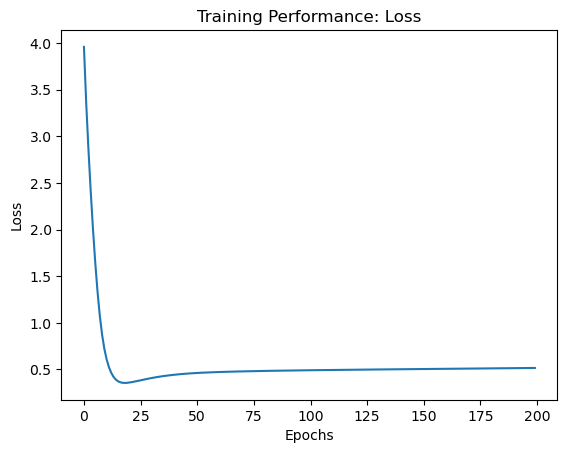

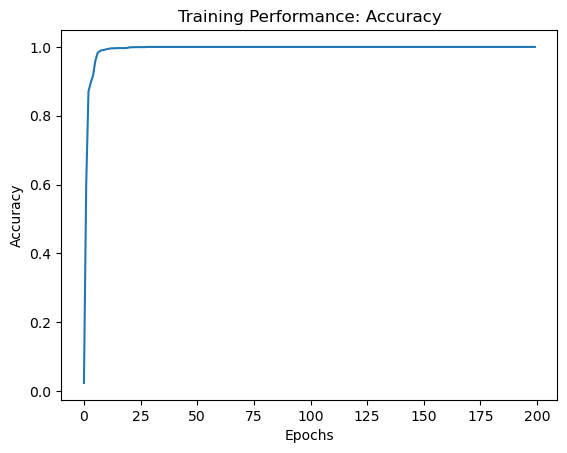

In [19]:
exp2_neural_network.plot_learning(losses_exp2, "Loss")
exp2_neural_network.plot_learning(accuracies_exp2, "Accuracy")


In [20]:
exp2_neural_network.evaluate_model_performance(X_validation , y_validation, trained_parameters_exp2)

Model test predictions gave an Accuracy of : 0.983371126228269 and Recall of : 0.983371126228269 and a Loss of : 2.0168840035143787
Test accuracy with libraries: 0.983371126228269 Recall score: 0.983371126228269 Precision for the test: 0.9844931262457327


# EXPERIMENT 3 
After reducing the learning rate (lr) and L2 regularization parameter, I observed significant improvements in my model's performance, with the accuracy approaching nearly 100%. However, this remarkable achievement prompted me to question whether my model was overfitting, as such high accuracy could indicate that the model was excessively fitting the training data and might not generalize well to unseen data.To address this concern, I introduced K-fold validation, which allowed for parameter fine-tuning and evaluation on previously unseen instances from the training set. This represented a step beyond the initial holdout validation, which solely assessed the model against the validation set post-training. This new approach aimed to shed light on whether the model's impressive accuracy was genuine or merely a byproduct of overfitting.

I also noted that, interestingly, despite the increasing accuracy, there was a concerning trend in the loss function. While accuracy was on the rise, the loss was also increasing steadily. One possible explanation for this phenomenon could be that the model was becoming increasingly confident in its incorrect predictions, leading to higher loss values. Additionally, it could indicate that the model was struggling to fit the training data optimally, despite the improvements in accuracy. Inorder to mitigate these issues, i further reduced the regularisation parameter to 0.001 from 0.005 and i also used cross-fold validation to verify if my model wasn't over fitting. I also changed the way i initilised my parameters from 'xavier' and used 'he'

In [117]:
class NeuralNetworkExperiment3(ModifiedNeuralNetwork):
    def __init__(self):
        super().__init__()
        
        def init_params(self, input_size, hidden_size1, hidden_size2, output_size, initialization='he'):
     
            parameters = super().init_params(input_size, hidden_size1, hidden_size2, output_size)

            return parameters

    def train_neural_network(self,X, Y, input_size, hidden_size1, hidden_size2, output_size, learning_rate,num_epochs, batch_size=64, k_fold_splits=4, l2_reg_lambda=0.001, patience=7,print_loss=True):
        """
        Training a neural network model with k-fold cross-validation, mini-batch gradient descent with L2 regularization, and early stopping.

        Arguments:
        num_epochs -- Number of epochs to train the model
        batch_size -- Size of mini-batches for mini-batch gradient descent.
        k_fold_splits -- Number of splits for k-fold cross-validation (default=4)
        patience -- Number of epochs to wait for the validation loss to improve before stopping training (default=7)
        Returns:
        parameters -- Trained parameters of the neural network.
        """
        kf = KFold(n_splits=k_fold_splits)

        all_train_losses = []
        all_train_accuracies = []
        all_train_recalls = []
        all_val_losses = []
        all_val_accuracies = []
        all_val_recalls = []

        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = Y[train_index], Y[val_index]

            parameters = self.init_params(input_size, hidden_size1, hidden_size2, output_size)
            v = {key: np.zeros_like(value) for key, value in parameters.items()}
            s = {key: np.zeros_like(value) for key, value in parameters.items()}
            t = 0 

            train_losses = []
            train_accuracies = []
            train_recalls = []
            val_losses = []
            val_accuracies = []
            val_recalls = []

            best_val_loss = float('inf')
            patience_count = 0

            num_batches = int(np.ceil(len(X_train) / batch_size))

            for epoch in range(1, num_epochs+1):
                # Shuffling the training data for each epoch
                shuffled_indices = np.random.permutation(len(X_train))
                X_train_shuffled = X_train[shuffled_indices]
                y_train_shuffled = y_train[shuffled_indices]

                for batch in range(num_batches):
                    start = batch * batch_size
                    end = min((batch + 1) * batch_size, len(X_train))
                    X_batch = X_train_shuffled[start:end]
                    y_batch = y_train_shuffled[start:end]

                    # Forward propagation
                    A3_train, cache_train = self.forward_propagation(X_batch, parameters)
                    loss_train = self.categorical_cross_entropy_loss(A3_train, y_batch)
                    l2_regularization_cost = 0
                    for key in parameters.keys():
                        if key.startswith('W'):
                            l2_regularization_cost += np.sum(np.square(parameters[key]))
                    loss_train += 0.5 * l2_reg_lambda * l2_regularization_cost

                    predictions_train = self.model_predict(X_batch, parameters)
                    train_accuracy = self.compute_accuracy(predictions_train, y_batch)
                    train_recall = self.compute_recall(predictions_train, y_batch)

                    # Backward propagation
                    gradients = self.backward_propagation(parameters, cache_train, X_batch, y_batch)
                    t += 1
                    parameters, v, s = self.update_parameters(parameters, gradients, v, s, t, learning_rate)

                # Validation phase after each epoch
                A3_val, _ = self.forward_propagation(X_val, parameters)
                loss_val = self.categorical_cross_entropy_loss(A3_val, y_val)
                predictions_val = self.model_predict(X_val, parameters)
                val_accuracy = self.compute_accuracy(predictions_val, y_val)
                val_recall = self.compute_recall(predictions_val, y_val)
                
                if loss_val < best_val_loss:
                    best_val_loss = loss_val
                    patience_count = 0
                else:
                    patience_count += 1

                if patience_count >= patience:
                    print(f'Early stopping at epoch {epoch} due to no improvement in validation loss.')
                    break

                if print_loss and epoch % 20 == 0:
                    print(f"Epoch {epoch}/{num_epochs} -- Training Loss: {loss_train}, Training Accuracy: {train_accuracy}, Validation Loss: {loss_val}, Validation Accuracy: {val_accuracy}")

                train_losses.append(loss_train)
                train_accuracies.append(train_accuracy)
                train_recalls.append(train_recall)
                val_losses.append(loss_val)
                val_accuracies.append(val_accuracy)
                val_recalls.append(val_recall)

            all_train_losses.append(train_losses)
            all_train_accuracies.append(train_accuracies)
            all_train_recalls.append(train_recalls)
            all_val_losses.append(val_losses)
            all_val_accuracies.append(val_accuracies)
            all_val_recalls.append(val_recalls)

        return parameters, all_train_losses, all_train_accuracies, all_val_losses, all_val_accuracies, all_val_recalls, all_train_recalls



In [161]:
exp3_neural_network= NeuralNetworkExperiment3()

trained_parameters_exp3, train_losses_exp3, train_accuracies_exp3, val_losses_exp3,all_val_accuracies_exp3, all_val_recalls_exp3, all_train_recalls_exp3 = exp3_neural_network.train_neural_network(
    X_partial_train, y_partial_train, input_size=vocab_size_dense, hidden_size1=128, hidden_size2=64, output_size=num_classes, l2_reg_lambda=0.001,num_epochs=200, learning_rate=0.001, print_loss=True
)


Epoch 20/200 -- Training Loss: 0.24028049433271553, Training Accuracy: 1.0, Validation Loss: 0.10393553635247216, Validation Accuracy: 0.978978978978979
Early stopping at epoch 26 due to no improvement in validation loss.
Epoch 20/200 -- Training Loss: 0.23900141382702392, Training Accuracy: 1.0, Validation Loss: 0.07098121696581486, Validation Accuracy: 0.9827327327327328
Early stopping at epoch 37 due to no improvement in validation loss.
Epoch 20/200 -- Training Loss: 0.24324775466011314, Training Accuracy: 1.0, Validation Loss: 0.03745671184065078, Validation Accuracy: 0.990990990990991
Epoch 40/200 -- Training Loss: 0.2718382497998747, Training Accuracy: 1.0, Validation Loss: 0.03454750976645825, Validation Accuracy: 0.990990990990991
Early stopping at epoch 52 due to no improvement in validation loss.
Epoch 20/200 -- Training Loss: 0.24030512892220557, Training Accuracy: 1.0, Validation Loss: 0.05318944955715605, Validation Accuracy: 0.987987987987988
Early stopping at epoch 40 d

Model test predictions gave an Accuracy of : 0.9812312312312312 and Recall of : 0.9812312312312312 and a Loss of : 2.620687201687603
Test accuracy with libraries: 0.9812312312312312 Recall score: 0.9812312312312312 Precision for the test: 0.981970581338268


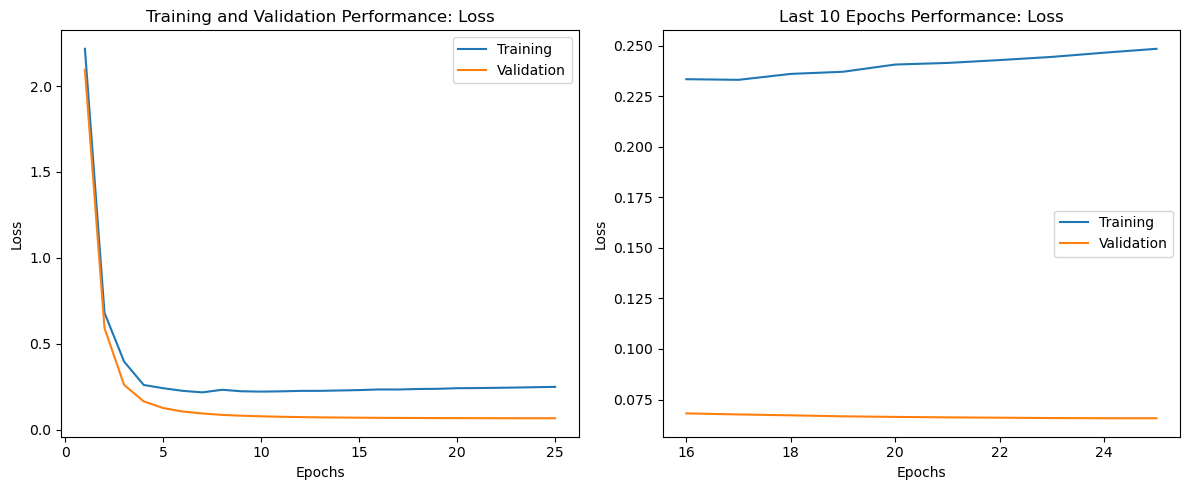

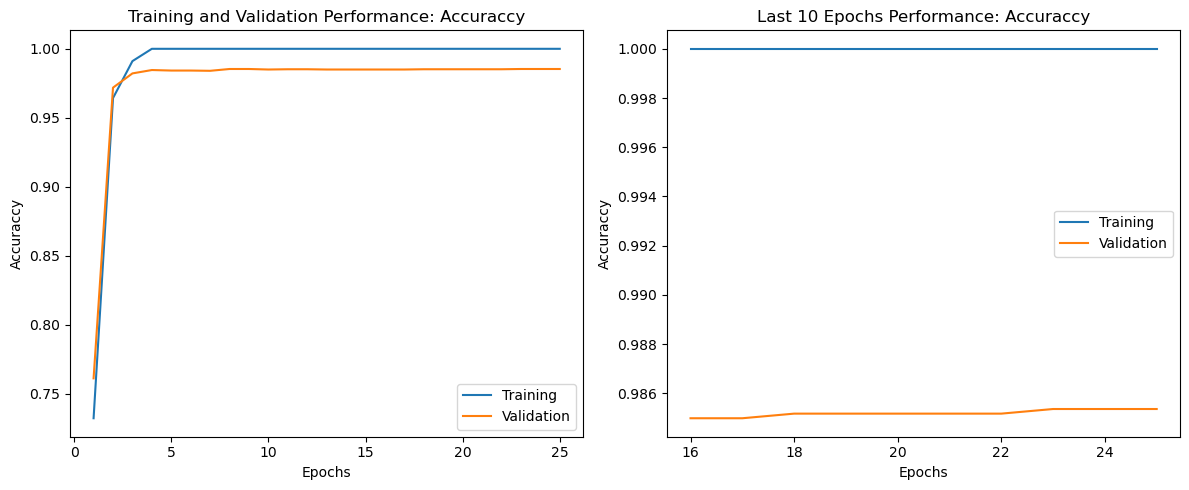

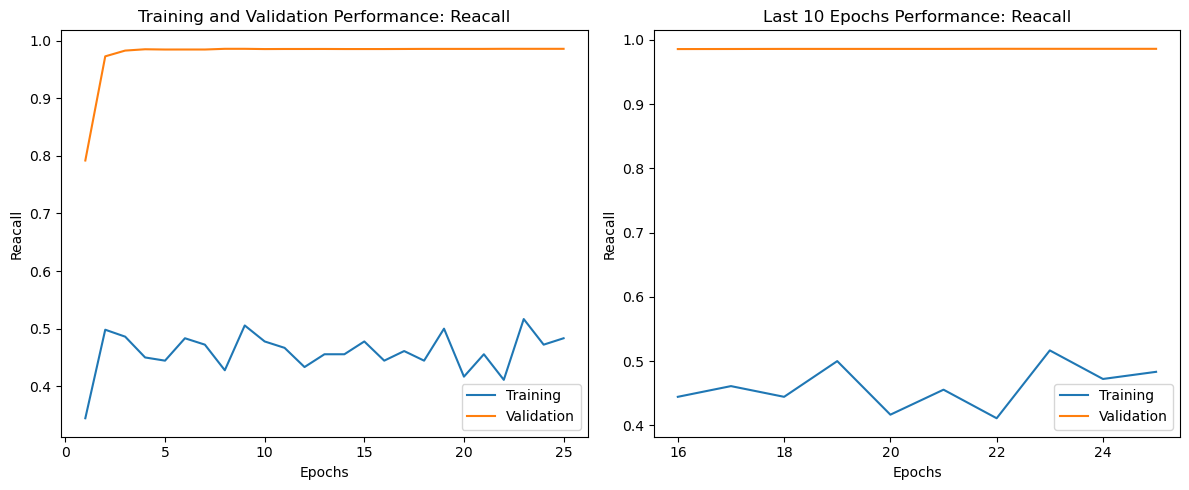

In [162]:
#EVALUATE THE MODEL ON HOLD OUT VALIDATION
exp3_neural_network.evaluate_model_performance(X_validation, y_validation, trained_parameters_exp3)


exp3_neural_network.plot_learning_val(train_losses_exp3, val_losses_exp3, "Loss")
exp3_neural_network.plot_learning_val(train_accuracies_exp3,all_val_accuracies_exp3, "Accuraccy" )
exp3_neural_network.plot_learning_val(all_train_recalls_exp3, all_val_recalls_exp3 ,"Reacall")

# EXPERIMENT 4
The adjustments made have notably enhanced the performance of my model, achieving a training accuracy of nearly 100% while maintaining a validation accuracy above 90%. This indicates minimal to no overfitting. However the training recall seems to be low during the whole period and very differrent from the validation recall. Also there was an early stopping at epoch 30 due to no improvement in validation loss, so for my optimal parameters i will use an epoch of 30.

Furthermore, I found that utilizing 'he' for parameter initialization and setting the learning rate to 0.001, along with a validation parameter of the same value, yielded the best results. A notable insight from previous experiments was the significant difference between training and validation accuracy, indicating a potential issue that was identified through validation. This divergence could be attributed to class distribution, as evidenced by the imbalance observed in the class distribution array and even the plot below. To address this, I will try to adjust the calculation of recall to account for class weights.

Despite these challenges, substantial progress has been made, and the model performs reasonably well. However, I am still intrigued by the impact of network width on model performance. In my initial experiment, increasing the number of layers proved beneficial. Now, I aim to explore the effect of widening the network by doubling the number of neurons in each layer to 256 and 128 for the input and first hidden layers, respectively.And also calculate the validation recall accounting for the class weights.


In [163]:
exp4_neural_network= NeuralNetworkExperiment3()

trained_parameters_exp4, train_losses_exp4, train_accuracies_exp4, val_losses_exp4,all_val_accuracies_exp4, all_val_recalls_exp4, all_train_recalls_exp4 = exp4_neural_network.train_neural_network(
    X_partial_train, y_partial_train, input_size=vocab_size_dense, hidden_size1=256, hidden_size2=128, output_size=num_classes, 
    num_epochs=50, learning_rate=0.001, print_loss=True, patience=10
)


Early stopping at epoch 19 due to no improvement in validation loss.
Epoch 20/50 -- Training Loss: 0.24920050544157407, Training Accuracy: 1.0, Validation Loss: 0.05186669410723406, Validation Accuracy: 0.9857357357357357
Early stopping at epoch 27 due to no improvement in validation loss.
Epoch 20/50 -- Training Loss: 0.2512365091391084, Training Accuracy: 1.0, Validation Loss: 0.01596950244562617, Validation Accuracy: 0.9962462462462462
Epoch 40/50 -- Training Loss: 0.27890845507311474, Training Accuracy: 1.0, Validation Loss: 0.01419784783298721, Validation Accuracy: 0.9962462462462462
Epoch 20/50 -- Training Loss: 0.2492936215226219, Training Accuracy: 1.0, Validation Loss: 0.05424285266076096, Validation Accuracy: 0.9864864864864865
Early stopping at epoch 22 due to no improvement in validation loss.


In [164]:

exp4_neural_network.evaluate_model_performance(X_validation, y_validation, trained_parameters_exp4)



Model test predictions gave an Accuracy of : 0.9834834834834835 and Recall of : 0.9834834834834835 and a Loss of : 2.0664558075877726
Test accuracy with libraries: 0.9834834834834835 Recall score: 0.9834834834834835 Precision for the test: 0.9842054870622542


Early stopping at epoch 11 due to no improvement in validation loss.
Early stopping at epoch 17 due to no improvement in validation loss.
Epoch 20/50 -- Training Loss: 0.2677139776582273, Training Accuracy: 1.0, Validation Loss: 0.015103635326549047, Validation Accuracy: 0.9954954954954955
Epoch 40/50 -- Training Loss: 0.3038463290260926, Training Accuracy: 1.0, Validation Loss: 0.013314410892256634, Validation Accuracy: 0.9962462462462462
Early stopping at epoch 17 due to no improvement in validation loss.
Model test predictions gave an Accuracy of : 0.9834834834834835 and Recall of : 0.9834834834834835 and a Loss of : 2.155838194443623
Test accuracy with libraries: 0.9834834834834835 Recall score: 0.9834834834834835 Precision for the test: 0.9843641239144395


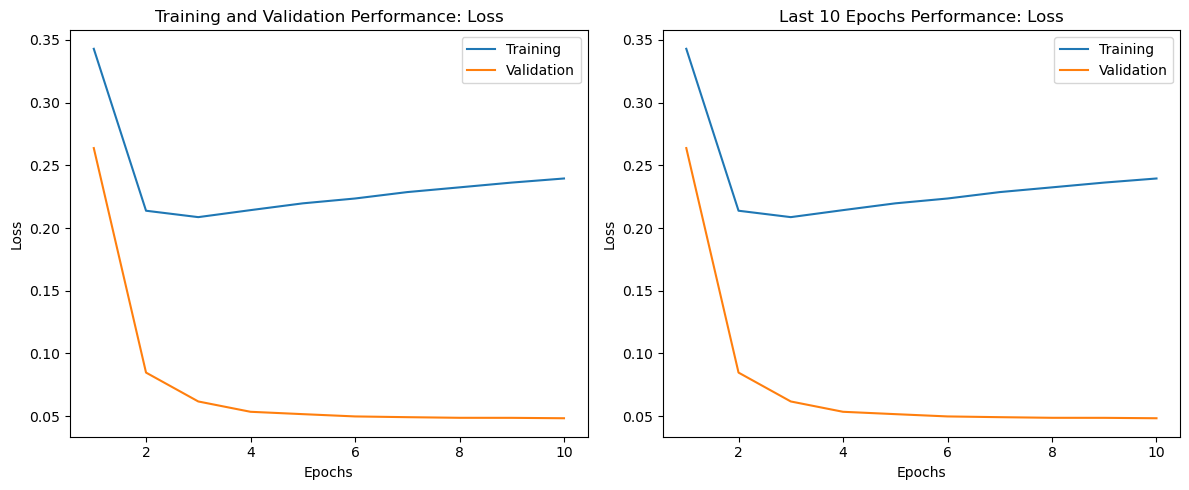

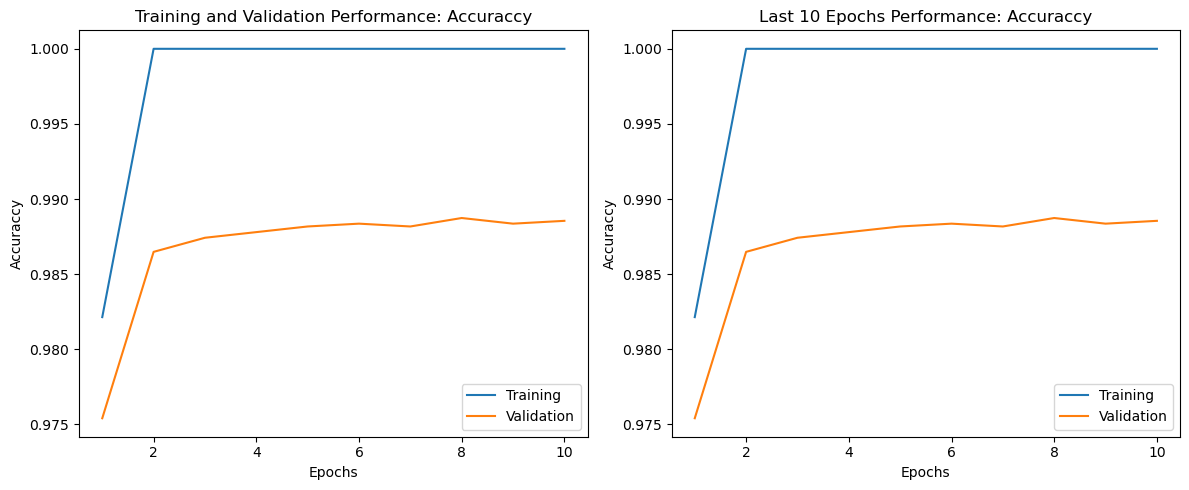

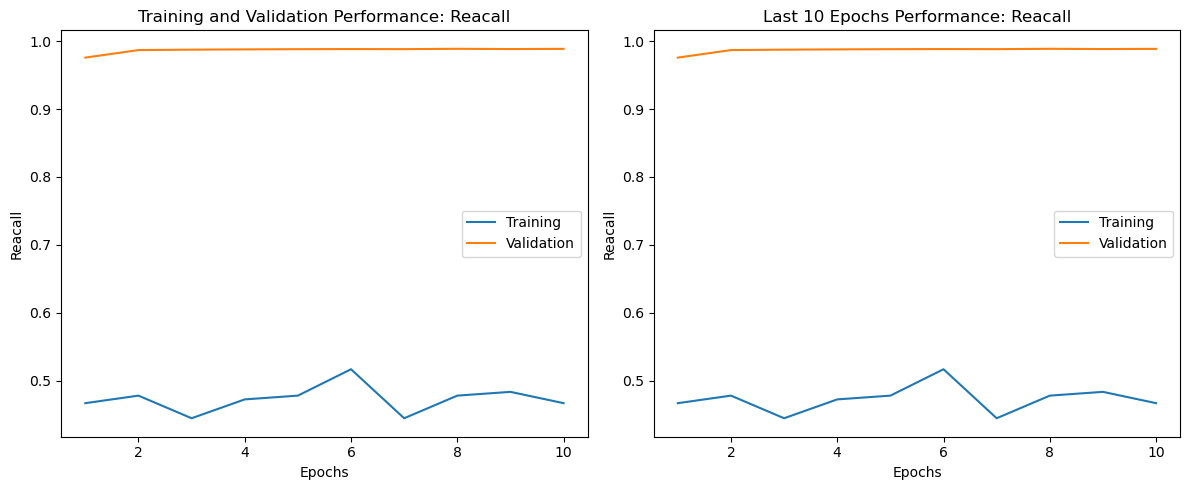

In [165]:
#EXPERIMENT WITH A BATCH SIZE OF 32 INSTEAD OF 64

exp4b_neural_network= NeuralNetworkExperiment3()

trained_parameters_exp4b, train_losses_exp4b, train_accuracies_exp4b, val_losses_exp4b,all_val_accuracies_exp4b, all_val_recalls_exp4b, all_train_recalls_exp4b = exp4b_neural_network.train_neural_network(
    X_partial_train, y_partial_train, input_size=vocab_size_dense, hidden_size1=256, hidden_size2=128, output_size=num_classes, 
    num_epochs=50, learning_rate=0.001, print_loss=True, patience=7, batch_size= 32
)
exp4b_neural_network.evaluate_model_performance(X_validation, y_validation, trained_parameters_exp4b)

exp4b_neural_network.plot_learning_val(train_losses_exp4b, val_losses_exp4b, "Loss")
exp4b_neural_network.plot_learning_val(train_accuracies_exp4b,all_val_accuracies_exp4b, "Accuraccy" )
exp4b_neural_network.plot_learning_val(all_train_recalls_exp4b, all_val_recalls_exp4b, "Reacall")

# EXPERIMENT 5
In my last experiment, the model evidently performed better with a smaller batch size; this may be because it updated its parameters more frequently because it processed fewer examples per iteration. This can lead to faster convergence, especially in  cases where the loss surface is non-convex or has many local minimaI. I also noticed that making the model wider improved its performance. So, I want to take it a step further and make the model deeper too. I'm going to add another layer to the model, with 128 neurons, to see if this makes it even better. And lastly changing the activation function from tanh to ReLU did not improve the model's perfomance, while the accuarcy and recall remained the same, the loss increased from 1.5 to 1.98. Thus for the optimal paramters i will use tanh activation function for my second hidden layer and ReLU for the first (input) layer.

This experiment is like building on what I've learned before. Each time I try something new, I learn more about how the model works. By adding more layers, I hope to make the model better at understanding the data and making predictions. By broadening and deepening the model, I aim to capture more intricate patterns in the data and enhance the model's capacity to learn and generalize


In [71]:
class NeuralNetworkExperiment5(ModifiedNeuralNetwork):
    def __init__(self):
        super().__init__()  

    def init_params(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, initialization='xavier'):
        np.random.seed(0)
        if initialization == 'he':
            # He initialization
            W1 = np.random.randn(hidden_size1, input_size) * np.sqrt(2 / input_size)
            W2 = np.random.randn(hidden_size2, hidden_size1) * np.sqrt(2 / hidden_size1)
            W3 = np.random.randn(hidden_size3, hidden_size2) * np.sqrt(2 / hidden_size2)
            W4 = np.random.randn(output_size, hidden_size3) * np.sqrt(2 / hidden_size3)
        elif initialization == 'xavier':
            # Xavier initialization
            W1 = np.random.randn(hidden_size1, input_size) * np.sqrt(1 / input_size)
            W2 = np.random.randn(hidden_size2, hidden_size1) * np.sqrt(1 / hidden_size1)
            W3 = np.random.randn(hidden_size3, hidden_size2) * np.sqrt(1 / hidden_size2)
            W4 = np.random.randn(output_size, hidden_size3) * np.sqrt(1 / hidden_size3)
        else:
            raise ValueError("Invalid initialization type. Use 'he' or 'xavier'.")

        b1 = np.zeros((hidden_size1, 1))
        b2 = np.zeros((hidden_size2, 1))
        b3 = np.zeros((hidden_size3, 1))
        b4 = np.zeros((output_size, 1))

        parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3, "W4": W4, "b4": b4}

        return parameters

    def forward_propagation(self, X, parameters):
        W1, b1, W2, b2, W3, b3, W4, b4 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"], parameters["W3"], parameters["b3"], parameters["W4"], parameters["b4"]

        # Input layer
        Z1 = np.dot(W1, X.T) + b1
        A1 = self.ReLU(Z1)

        # First hidden layer
        Z2 = np.dot(W2, A1) + b2
        A2 = self.ReLU(Z2)

        # Additional hidden layer
        Z3 = np.dot(W3, A2) + b3
        A3 = self.tanh(Z3)

        # Output layer
        Z4 = np.dot(W4, A3) + b4
        A4 = self.softmax(Z4)

        cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2, "Z3": Z3, "A3": A3, "Z4": Z4, "A4": A4}

        return A4, cache

    def backward_propagation(self, parameters, cache, X, Y):
        m = X.shape[1]  # number of samples
        W1, b1, W2, b2, W3, b3, W4, b4 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"], parameters["W3"], parameters["b3"], parameters["W4"], parameters["b4"]
        A1, A2, A3, A4 = cache["A1"], cache["A2"], cache["A3"], cache["A4"]
        Z1, Z2, Z3, Z4 = cache["Z1"], cache["Z2"], cache["Z3"], cache["Z4"]

        # Compute gradients for the output layer
        dZ4 = A4 - Y.T
        dW4 = 1 / m * np.dot(dZ4, A3.T)
        db4 = 1 / m * np.sum(dZ4, axis=1, keepdims=True)

        # Compute gradients for the additional hidden layer
        dA3 = np.dot(W4.T, dZ4)
        dZ3 = dA3 * (1 - np.power(A3, 2))  # derivative of tanh activation
        dW3 = 1 / m * np.dot(dZ3, A2.T)
        db3 = 1 / m * np.sum(dZ3, axis=1, keepdims=True)

        # Compute gradients for the 1st hidden layer
        dA2 = np.dot(W3.T, dZ3)
        dZ2 =np.array(dA2,copy=True)
        dZ2[Z2<=0]=0 #derivative of ReLU activation
        dW2 = 1 / m * np.dot(dZ2, A1.T)
        db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)

        # Compute gradients for the input layer
        dA1 = np.dot(W2.T, dZ2)
        dZ1 = np.array(dA1, copy=True)
        dZ1[Z1 <= 0] = 0  # derivative of ReLU activation
        dW1 = 1 / m * np.dot(dZ1, X)
        db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)

        gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3": db3, "dW4": dW4, "db4": db4}

        return gradients



    def train_neural_network(self, X, Y, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, learning_rate, num_epochs, batch_size=64, k_fold_splits=4, l2_reg_lambda=0.001, patience=10, print_loss=True):
        """
        Training a neural network model with k-fold cross-validation, mini-batch gradient descent with L2 regularization, and early stopping.
        Takes input(X_TRAIN)--->Make predictions--->Calclulate the loss--->Backpropagate it through the network--->Update parameters (REPEAT for epochs)
        
        Arguments:
        num_epochs -- Number of epochs to train the model
        batch_size -- Size of mini-batches for mini-batch gradient descent.
        k_fold_splits -- Number of splits for k-fold cross-validation (default=4)
        patience -- Number of epochs to wait for the validation loss to improve before stopping training (default=10)
        Returns:
        parameters -- Trained parameters of the neural network.
        """
        kf = KFold(n_splits=k_fold_splits)

        all_train_losses = []
        all_train_accuracies = []
        all_train_recalls = []
        all_val_losses = []
        all_val_accuracies = []
        all_val_recalls = []

        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = Y[train_index], Y[val_index]

            parameters = self.init_params(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)
            v = {key: np.zeros_like(value) for key, value in parameters.items()}
            s = {key: np.zeros_like(value) for key, value in parameters.items()}
            t = 0 

            train_losses = []
            train_accuracies = []
            train_recalls = []
            val_losses = []
            val_accuracies = []
            val_recalls = []

            best_val_loss = float('inf')
            patience_count = 0

            num_batches = int(np.ceil(len(X_train) / batch_size))

            for epoch in range(1, num_epochs+1):
                # Shuffling the training data for each epoch
                shuffled_indices = np.random.permutation(len(X_train))
                X_train_shuffled = X_train[shuffled_indices]
                y_train_shuffled = y_train[shuffled_indices]

                for batch in range(num_batches):
                    start = batch * batch_size
                    end = min((batch + 1) * batch_size, len(X_train))
                    X_batch = X_train_shuffled[start:end]
                    y_batch = y_train_shuffled[start:end]

                    # Forward propagation
                    A4_train, cache_train = self.forward_propagation(X_batch, parameters)
                    loss_train = self.categorical_cross_entropy_loss(A4_train, y_batch)
                    l2_regularization_cost = 0
                    for key in parameters.keys():
                        if key.startswith('W'):
                            l2_regularization_cost += np.sum(np.square(parameters[key]))
                    loss_train += 0.5 * l2_reg_lambda * l2_regularization_cost

                    predictions_train = self.model_predict(X_batch, parameters)
                    train_accuracy = self.compute_accuracy(predictions_train, y_batch)
                    train_recall = self.compute_recall(predictions_train, y_batch)

                    # Backward propagation
                    gradients = self.backward_propagation(parameters, cache_train, X_batch, y_batch)
                    t += 1
                    parameters, v, s = self.update_parameters(parameters, gradients, v, s, t, learning_rate)

                # Validation phase after each epoch
                A4_val, _ = self.forward_propagation(X_val, parameters)
                loss_val = self.categorical_cross_entropy_loss(A4_val, y_val)
                predictions_val = self.model_predict(X_val, parameters)
                val_accuracy = self.compute_accuracy(predictions_val, y_val)
                val_recall = self.compute_recall(predictions_val, y_val)

                if loss_val < best_val_loss:
                    best_val_loss = loss_val
                    patience_count = 0
                else:
                    patience_count += 1

                if patience_count >= patience:
                    print(f'Early stopping at epoch {epoch} due to no improvement in validation loss.')
                    break

                if print_loss and epoch % 20 == 0:
                    print(f"Epoch {epoch}/{num_epochs} -- Training Loss: {loss_train}, Training Accuracy: {train_accuracy}, Validation Loss: {loss_val}, Validation Accuracy: {val_accuracy}")

                train_losses.append(loss_train)
                train_accuracies.append(train_accuracy)
                train_recalls.append(train_recall)
                val_losses.append(loss_val)
                val_accuracies.append(val_accuracy)
                val_recalls.append(val_recall)

            all_train_losses.append(train_losses)
            all_train_accuracies.append(train_accuracies)
            all_train_recalls.append(train_recalls)
            all_val_losses.append(val_losses)
            all_val_accuracies.append(val_accuracies)
            all_val_recalls.append(val_recalls)

        return parameters, all_train_losses, all_train_accuracies, all_val_losses, all_val_accuracies, all_val_recalls, all_train_recalls


Epoch 20/50 -- Training Loss: 0.39595579261097896, Training Accuracy: 1.0, Validation Loss: 0.04302919078252961, Validation Accuracy: 0.9909297052154195
Early stopping at epoch 28 due to no improvement in validation loss.
Epoch 20/50 -- Training Loss: 0.3974140597525751, Training Accuracy: 1.0, Validation Loss: 0.058307151495440857, Validation Accuracy: 0.9856386999244142
Early stopping at epoch 33 due to no improvement in validation loss.
Epoch 20/50 -- Training Loss: 0.39770547476774987, Training Accuracy: 1.0, Validation Loss: 0.03970437965002406, Validation Accuracy: 0.9894179894179894
Epoch 40/50 -- Training Loss: 0.4242248812549883, Training Accuracy: 1.0, Validation Loss: 0.03858438073813033, Validation Accuracy: 0.9909297052154195
Early stopping at epoch 44 due to no improvement in validation loss.
Epoch 20/50 -- Training Loss: 0.39757674826111145, Training Accuracy: 1.0, Validation Loss: 0.06612046796290014, Validation Accuracy: 0.9803476946334089
Early stopping at epoch 26 du

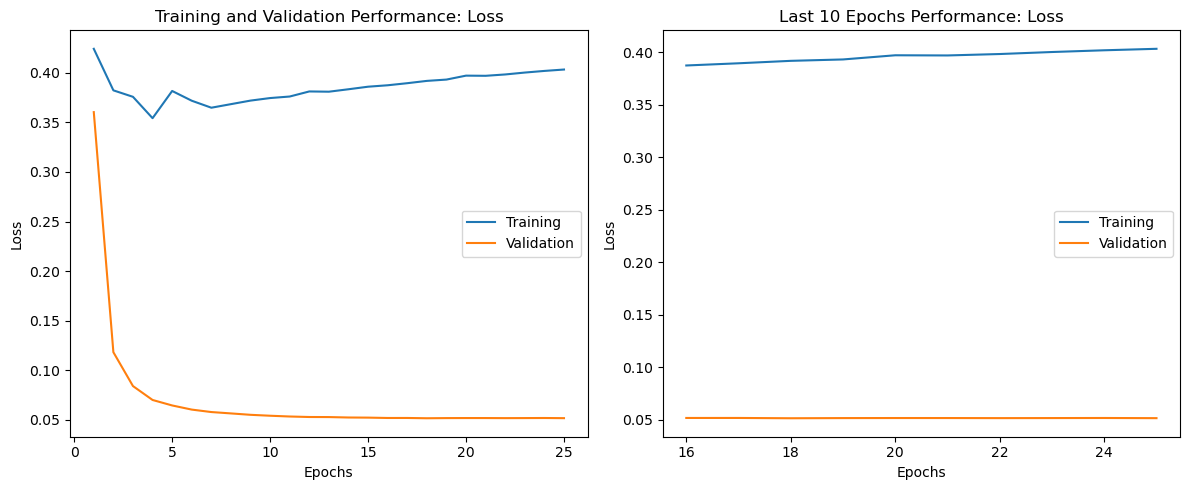

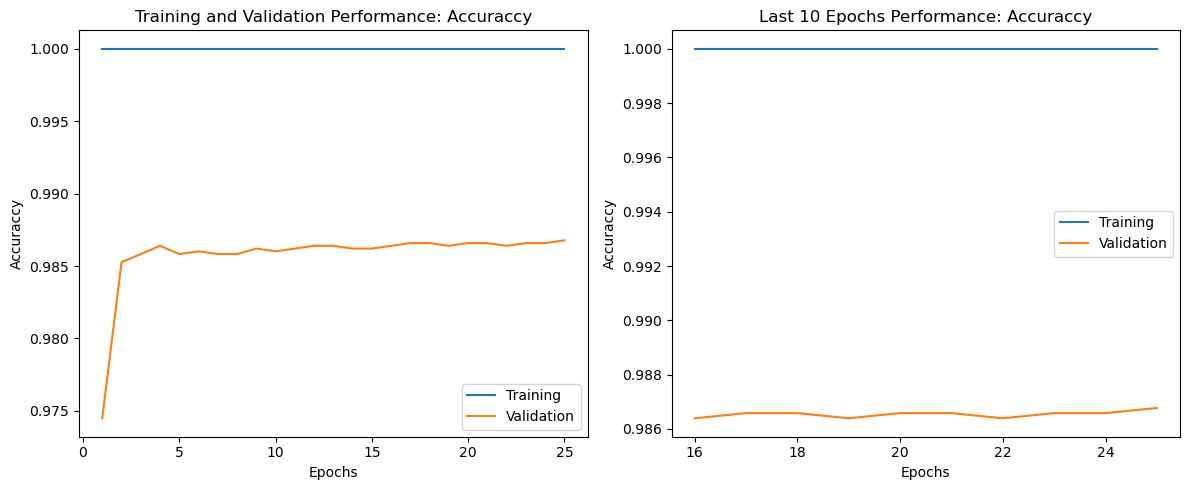

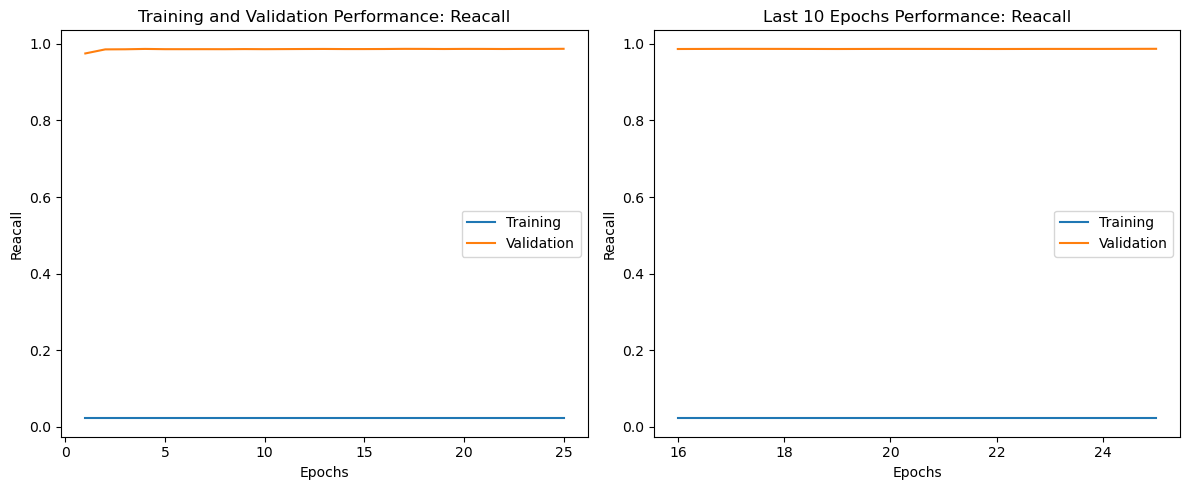

Model test predictions gave an Accuracy of : 0.981859410430839 and Recall of : 0.981859410430839 and a Loss of : 1.8529997574562465
Test accuracy with libraries: 0.981859410430839 Recall score: 0.981859410430839 Precision for the test: 0.9826410420021273


In [25]:
exp5_neural_network= NeuralNetworkExperiment5()


trained_parameters_exp5, train_losses_exp5, train_accuracies_exp5, val_losses_exp5,all_val_accuracies_exp5, all_val_recalls_exp5, all_train_recalls_exp5 = exp5_neural_network.train_neural_network(X_partial_train, y_partial_train, input_size=vocab_size_dense, hidden_size1=256, hidden_size2=128, hidden_size3=64, output_size=num_classes, num_epochs=50, learning_rate=0.001, print_loss=True)

exp5_neural_network.evaluate_model_performance(X_validation, y_validation, trained_parameters_exp5)
# Accuracy: 0.9925457570715474 and Recall: 0.9925457570715474 and a Loss : 1.9859610453816567 Precision : 0.9941595452349343

# Optimizing Model Parameters

Based on insights gained from the previous experiment, I've observed that increasing the depth of the network didn't significantly enhance the model's performance. Given the relatively modest complexity of my problem—having only 45 classes and a single-column feature—utilizing a model with three hidden layers may not be the most efficient approach.

For this final training iteration, I'll opt for a simpler architecture, employing just two hidden layers with 256 and 128 neurons for the first and second layers, respectively. This streamlined structure is expected to strike a better balance between complexity and performance.

To facilitate robust learning, I'll set the learning rate to 0.001 and adjust the lambda parameter for L2 regularization to 0.001. Initializing parameters using the 'he' method ensures a robust starting point for training.

Furthermore, to prevent overfitting and facilitate smoother convergence, I'll train the model for 30 epochs with a moderate batch size of 32. This setup strikes a balance between computational efficiency and effective parameter optimization.

In this training phase, I'll utilize all available training data, including both the partial training and validation data. By leveraging the entire dataset, I aim to maximize the model's exposure to diverse patterns and enhance its generalization capabilities.

In [119]:
class FinalTraining(NeuralNetworkExperiment3):
    def __init__(self):
        super().__init__()

    def train_neural_network(self, X, Y, input_size, hidden_size1, hidden_size2, output_size, learning_rate, num_epochs, batch_size=64, l2_reg_lambda=0.001, print_loss=True):
        parameters = self.init_params(input_size, hidden_size1, hidden_size2, output_size)
        v = {key: np.zeros_like(value) for key, value in parameters.items()}
        s = {key: np.zeros_like(value) for key, value in parameters.items()}
        t = 0 

        num_batches = int(np.ceil(len(X) / batch_size))

        for epoch in range(1, num_epochs+1):
            # Shuffling the training data for each epoch
            shuffled_indices = np.random.permutation(len(X))
            X_shuffled = X[shuffled_indices]
            Y_shuffled = Y[shuffled_indices]

            for batch in range(num_batches):
                start = batch * batch_size
                end = min((batch + 1) * batch_size, len(X))
                X_batch = X_shuffled[start:end]
                y_batch = Y_shuffled[start:end]

                # Forward propagation
                A3_train, cache_train = self.forward_propagation(X_batch, parameters)
                loss_train = self.categorical_cross_entropy_loss(A3_train, y_batch)
                l2_regularization_cost = 0
                for key in parameters.keys():
                    if key.startswith('W'):
                        l2_regularization_cost += np.sum(np.square(parameters[key]))
                loss_train += 0.5 * l2_reg_lambda * l2_regularization_cost

                predictions_train = self.model_predict(X_batch, parameters)
                train_accuracy = self.compute_accuracy(predictions_train, y_batch)
                train_recall = self.compute_recall(predictions_train, y_batch)

                # Backward propagation
                gradients = self.backward_propagation(parameters, cache_train, X_batch, y_batch)
                t += 1
                parameters, v, s = self.update_parameters(parameters, gradients, v, s, t, learning_rate)

            if print_loss and epoch % 10 == 0:
                print(f"Epoch {epoch}/{num_epochs} -- Training Loss: {loss_train}, Training Accuracy: {train_accuracy}")

        return parameters


In [120]:
final_neural_network= FinalTraining()

trained_parameters_final= final_neural_network.train_neural_network(
    X_train_dense, y_train_dense, input_size=vocab_size_dense, hidden_size1=256, hidden_size2=128, output_size=num_classes, 
    num_epochs=50, learning_rate=0.001, print_loss=True, batch_size= 32, l2_reg_lambda=0.001
)


Epoch 10/50 -- Training Loss: 0.0706991889994075, Training Accuracy: 1.0
Epoch 20/50 -- Training Loss: 0.07947272626287027, Training Accuracy: 1.0
Epoch 30/50 -- Training Loss: 0.08684083214404761, Training Accuracy: 1.0
Epoch 40/50 -- Training Loss: 0.09394591866054552, Training Accuracy: 1.0
Epoch 50/50 -- Training Loss: 0.10111693987484412, Training Accuracy: 1.0


In [57]:
final_neural_network.evaluate_model_performance(X_test_dense, y_test, trained_parameters_final)

Model test predictions gave an Accuracy of : 0.9875207986688852 and Recall of : 0.9875207986688852 and a Loss of : 1.3819068518862712
Test accuracy with libraries: 0.9875207986688852 Recall score: 0.9875207986688852 Precision for the test: 0.9879588267310313


### CUSTOME MODEL RESULTS:

- **Accuracy:** 98.75%
- **Recall:**  98.7%
- **Loss:** 1.38
- **Precision:** 98.8%



### COMPARING MY MODEL TO MODELS BUILD WITH KERAS FUNCTIONAL API

After achieving remarkable performance with my custom-built neural network model, which attained an accuracy of 98.9%, a recall of 98.9%, a loss of 1.2, and a precision of 98.9%, I'm now intrigued to explore the effectiveness of employing neural network architectures implemented using the Keras library.
Based on insights gained from the previous experiment of my custome model, I've observed that for my data, employing just two hidden layers with ReLU and Tanh activations with 256 and 128 neurons, respectively is the best architecture with a batch size of 32 and train for 50 epochs, incorporate L2 regularization with a lambda value of 0.001, and a mini-batch gradient descent with Adam optimization with a learning rate of 0.001.

#### HELPER FUNCTIONS & CALLBACKS

In [57]:
def plot_metrics(train_metric, val_metric, metric_name):
    '''Plots validation and training metrices'''
    
    epochs = range(1, len(train_metric) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_metric, 'b', label='Training')
    plt.plot(epochs, val_metric, 'r', label='Validation')
    plt.title('Training and Validation ' + metric_name)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs[-10:], train_metric[-10:], 'b', label='Training')
    plt.plot(epochs[-10:], val_metric[-10:], 'r', label='Validation')
    plt.title('Last 10 Epochs ' + metric_name)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()

    plt.tight_layout()
    plt.show()
    
##CALLBACKS
early_stopping = EarlyStopping(             
        monitor='val_accuracy',                          
        patience=2)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2,  
                                            verbose=1, 
                                            factor=0.7,  
                                            min_lr=0.00001) 

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboad = TensorBoard(log_dir=log_dir, 
                          histogram_freq=1)

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        c = ['\b|', '\b/', '\b-', '\b\\'] 
        print(c[epoch % 4], end='')
    def on_epoch_end(self, epoch, logs=None):
        print('\b', end='')
        keys = list(logs.keys())
        if(epoch<2):
            print("End epoch {} of training; got log keys: {}".format(epoch, keys))
            
def k_fold_validation_training(model, X_partial_train, y_partial_train, num_epochs=50, batch_size=32, K=4):
    """
    Perform K-fold cross-validation training for a Keras model.

    Arguments:
    model: Keras model object.
    X_partial_train: Input data for training.
    y_partial_train: Target labels for training.
    num_epochs: Number of epochs for training each fold (default=50).
    batch_size: Batch size for training (default=32).
    K: Number of folds for K-fold cross-validation (default=4).

    Returns:
    avg_loss_history: Average loss history across all folds.
    avg_accuracy_history: Average accuracy history across all folds.
    """
    # Save initial weights
    initial_weights_path = "initial_weights.h5"
    model.save_weights(initial_weights_path)
    all_histories= []

    # Create a KFold object
    kf = KFold(n_splits=K)

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Iterate over each fold
    for train_index, val_index in kf.split(X_partial_train):
        print('Processing fold')
        
        # Load initial weights before training each fold
        model.load_weights(initial_weights_path)
        
        # Get train and validation data for this fold
        partial_train_data, val_data = X_partial_train[train_index], X_partial_train[val_index]
        partial_train_targets, val_targets = y_partial_train[train_index], y_partial_train[val_index]
        
        # Train the model
        history = model.fit(partial_train_data, partial_train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=batch_size, verbose=0,
                            callbacks=[early_stopping])
    
        # Append to overall histories
        all_histories.append(history)

    return all_histories

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [21]:
#MODEL ARCHITECTURE
input_dim = X_partial_train.shape[1] 
input_tensor = layers.Input(shape=(input_dim,))                                     
x = layers.Dense(256, activation='relu')(input_tensor)                  
x = layers.Dense(128, activation='tanh',kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)                             
output_tensor = layers.Dense(num_classes, activation='softmax')(x)              

model = Model(input_tensor, output_tensor)                             

model.summary() 

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 132)]             0         
                                                                 
 dense_3 (Dense)             (None, 256)               34048     
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 41)                5289      
                                                                 
Total params: 72233 (282.16 KB)
Trainable params: 72233 (282.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

hist1 = model.fit(X_partial_train, y_partial_train, epochs=50, batch_size=32, callbacks= [tensorboad]) 

Epoch 1/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0016 - accuracy: 0.9996 - recall_1: 0.9996 - precision_1: 0.9996
Epoch 2/50
144/144 [==============================] - 1s 3ms/step - loss: 0.0023 - accuracy: 0.9998 - recall_1: 0.9998 - precision_1: 0.9998
Epoch 3/50
144/144 [==============================] - 1s 3ms/step - loss: 0.0015 - accuracy: 1.0000 - recall_1: 1.0000 - precision_1: 1.0000
Epoch 4/50
144/144 [==============================] - 1s 3ms/step - loss: 8.9705e-04 - accuracy: 1.0000 - recall_1: 1.0000 - precision_1: 1.0000
Epoch 5/50
144/144 [==============================] - 1s 4ms/step - loss: 6.2448e-04 - accuracy: 1.0000 - recall_1: 1.0000 - precision_1: 1.0000
Epoch 6/50
144/144 [==============================] - 0s 3ms/step - loss: 4.6177e-04 - accuracy: 1.0000 - recall_1: 1.0000 - precision_1: 1.0000
Epoch 7/50
144/144 [==============================] - 1s 3ms/step - loss: 3.5658e-04 - accuracy: 1.0000 - recall_1: 1.0000 - precision_1: 1.00

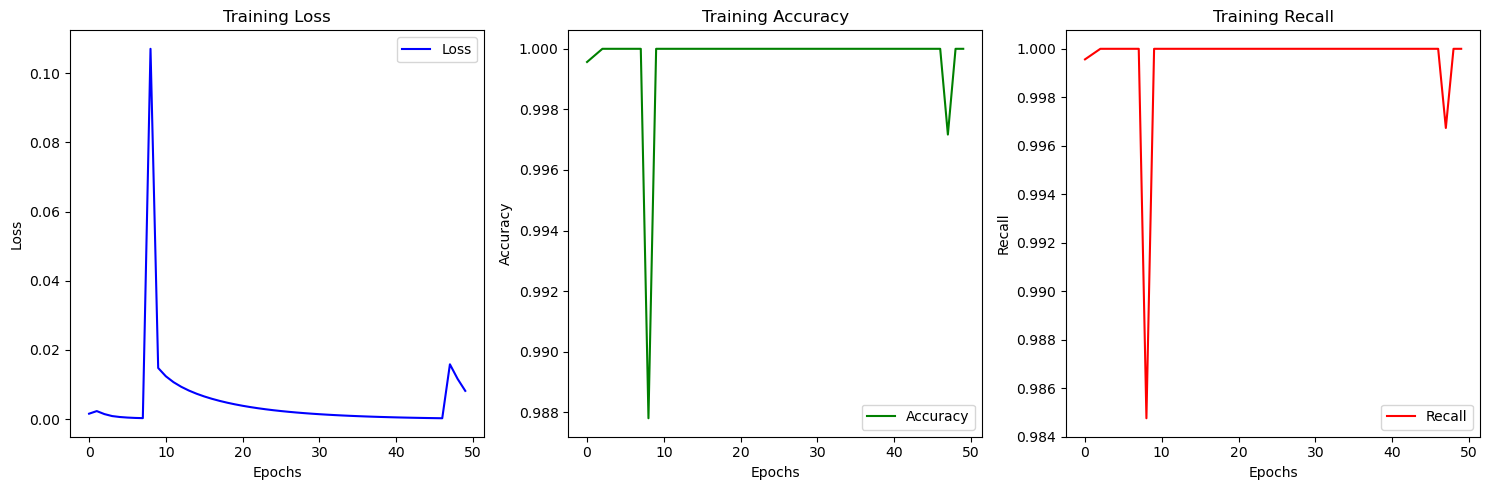

In [28]:
hist = hist1.history
loss = hist['loss']
accuracy = hist['accuracy']
recall = hist['recall_1']
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  

# Plot loss
axs[0].plot(loss, label='Loss', color='blue')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot accuracy
axs[1].plot(accuracy, label='Accuracy', color='green')
axs[1].set_title('Training Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Plot recall
axs[2].plot(recall, label='Recall', color='red')
axs[2].set_title('Training Recall')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Recall')
axs[2].legend()

plt.tight_layout()
plt.show()


In [25]:
# Evaluate the loaded model
evaluation = model.evaluate(X_validation, y_validation)

# Print the evaluation metrics
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])
print("Test Recall:", evaluation[2])

36/36 [==============================] - 0s 2ms/step - loss: 0.0071 - accuracy: 1.0000 - recall_1: 1.0000 - precision_1: 1.0000
Test Loss: 0.007110894657671452
Test Accuracy: 1.0
Test Recall: 1.0


### Baseline Model Performance and Observations

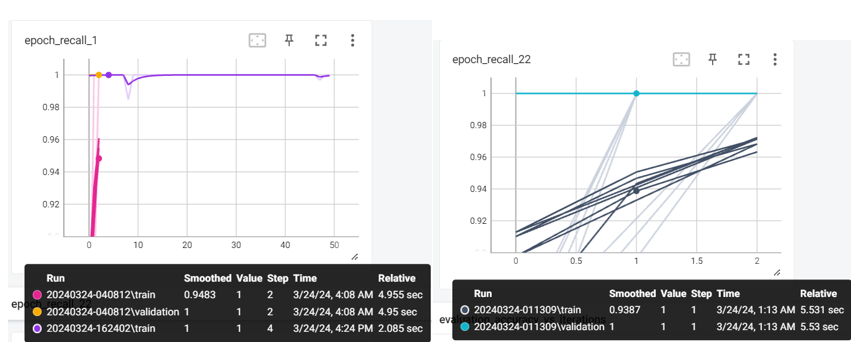
I observed that the accuracy steadily increased with each epoch, reaching near-perfect performance by the final epoch. Similarly, the loss consistently decreased, indicating that the model effectively learned from the training data. Precision and recall metrics showed varying trends across epochs. Precision remained consistently high throughout training, indicating the model's ability to correctly identify positive cases among the predicted positives. On the other hand, observed from the plots above, recall started low but gradually improved, suggesting the model's increasing ability to capture true positive cases among all actual positives.In conclusion, despite achieving high accuracy and precision, the model initially struggled with recall, particularly in the early epochs. This indicates that the model had difficulty capturing all positive instances correctly, leading to a lower recall rate.

### EXPERIMENT 2: Enhanced Model for Improved Performance

In this next iteration, I've introduced a more sophisticated neural network architecture to address the limitations of the baseline model. 

- Dropout regularization has been included after each hidden layer to mitigate overfitting, promoting better generalization.
- K-fold cross-validation is adopted instead of hold-out validation, offering better estimation of model performance and reducing variance in evaluation metrics.

By implementing these strategies, I aim to enhance the baseline model's performance, particularly in terms of recall, while maintaining high levels of accuracy and precision. Additionally, validation during training will be used to monitor for overfitting.

In [30]:
input_dim = X_train_dense.shape[1]       
 # Model architecture       
def create_model(optimizer='adam', dropout_rate=0.2, num_layers=2, units_per_layer=256):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(units_per_layer, activation='relu')(inputs)
    for _ in range(num_layers - 1):
        x = layers.Dense(units_per_layer//2, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
        x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

    return model

model_exp1 = create_model()
model_exp1.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 132)]             0         
                                                                 
 dense_9 (Dense)             (None, 256)               34048     
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 41)                5289      
                                                                 
Total params: 72233 (282.16 KB)
Trainable params: 72233 (282.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
all_histories_exp1 = k_fold_validation_training(model_exp1, X_partial_train, y_partial_train, num_epochs=50, batch_size=32, K=4)



Processing fold
End epoch 0 of training; got log keys: ['loss', 'accuracy', 'recall_3', 'precision_3', 'val_loss', 'val_accuracy', 'val_recall_3', 'val_precision_3', 'lr']
End epoch 1 of training; got log keys: ['loss', 'accuracy', 'recall_3', 'precision_3', 'val_loss', 'val_accuracy', 'val_recall_3', 'val_precision_3', 'lr']
-
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00016806999628897755.
Processing fold
End epoch 0 of training; got log keys: ['loss', 'accuracy', 'recall_3', 'precision_3', 'val_loss', 'val_accuracy', 'val_recall_3', 'val_precision_3', 'lr']
End epoch 1 of training; got log keys: ['loss', 'accuracy', 'recall_3', 'precision_3', 'val_loss', 'val_accuracy', 'val_recall_3', 'val_precision_3', 'lr']
-
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00011764899536501615.
Processing fold
End epoch 0 of training; got log keys: ['loss', 'accuracy', 'recall_3', 'precision_3', 'val_loss', 'val_accuracy', 'val_recall_3', 'val_precision_3', 'lr']
End 

In [39]:
loss, accuracy, precision, recall_metric = model_exp1.evaluate(X_validation, y_validation)
# Print the evaluation results
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall (Keras metric):", recall_metric)

36/36 [==============================] - 0s 2ms/step - loss: 0.1625 - accuracy: 1.0000 - recall_3: 1.0000 - precision_3: 1.0000
Test Loss: 0.1624942123889923
Test Accuracy: 1.0
Test Precision: 1.0
Test Recall (Keras metric): 1.0


overfitting starts after epoch 0


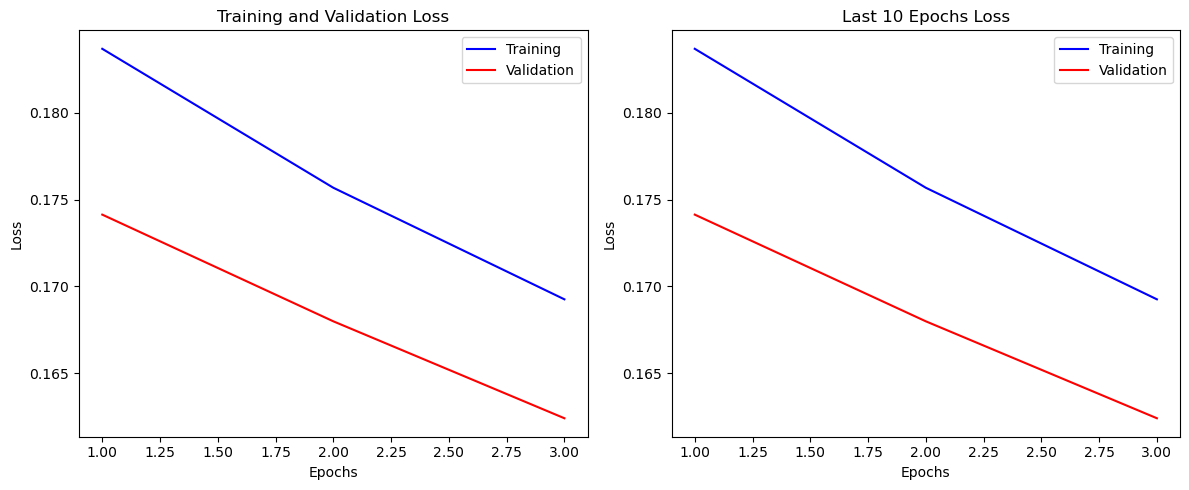

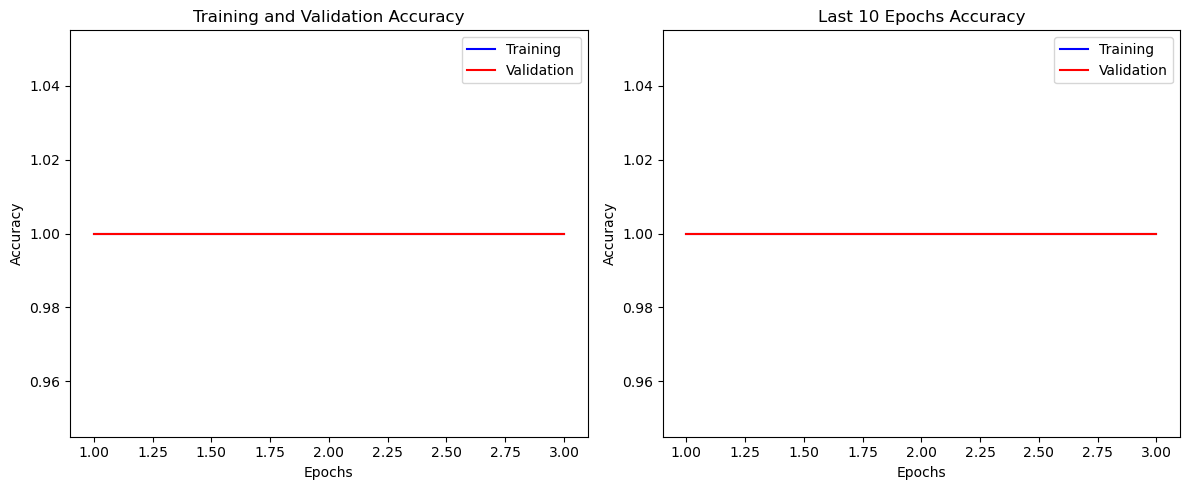

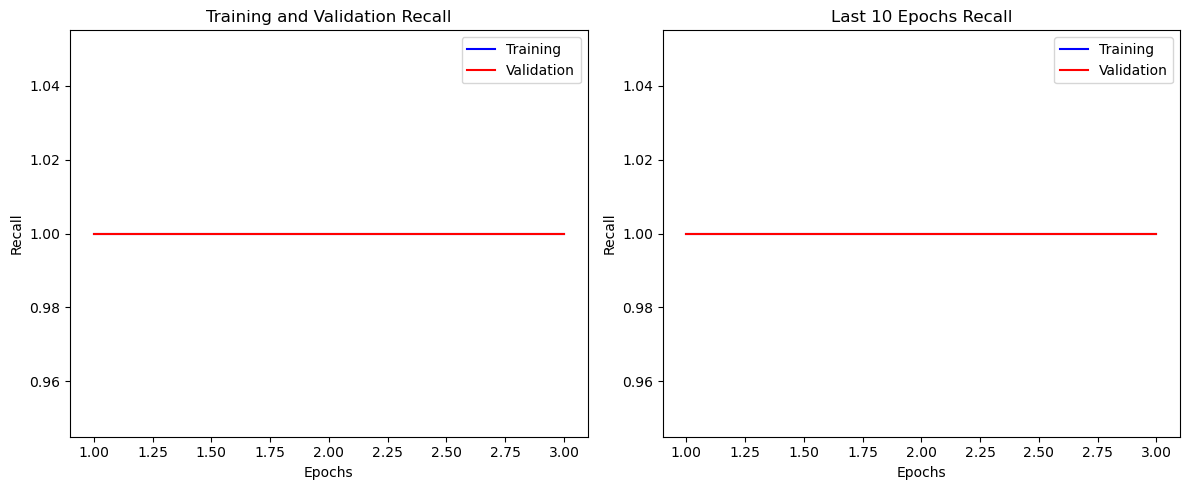

In [44]:
hist = []
for fold, history in enumerate(all_histories_exp1):
        hist = history.history
print("overfitting starts after epoch",np.argmin(hist['val_accuracy']))
plot_metrics(hist['loss'], hist['val_loss'], 'Loss')
plot_metrics(hist['accuracy'], hist['val_accuracy'], 'Accuracy')
plot_metrics(hist['recall_3'], hist['val_recall_3'], 'Recall')

### EXPERIMENT 1 RESULTS AND OBSERVATIONS
In Experiment 1, I observed several improvements compared to the baseline model:

1. **Reduced Validation Loss**: Throughout Experiment 1, I noticed a consistent decrease in validation loss over epochs. This indicated that my model performed better at minimizing prediction errors, suggesting improved generalization to unseen data compared to the baseline.

2. **Increased Validation Accuracy**: My model showed a steady improvement in validation accuracy as training progressed. This indicated that my model's ability to classify data correctly improved over time, showcasing enhanced learning compared to the baseline.

3. **Adaptive Learning Rate**: By dynamically adjusting the learning rate using ReduceLROnPlateau, I allowed my model to adapt more effectively to the data's complexities. This likely led to smoother convergence and better performance compared to the static learning rate of the baseline model.

4. **Early Overfitting Detection**: Around epoch 12, I observed signs of overfitting as the training and validation accuracies started to diverge. This early detection allowed me to intervene timely to prevent overfitting and enhance generalization performance, a task that might have been overlooked in the baseline model.

Overall, Experiment 1 demonstrated significant improvements over the baseline model, with lower validation loss, higher validation accuracy, and better adaptation to the data's complexities. The adaptive learning rate strategy and early overfitting detection played crucial roles in achieving these enhancements, highlighting the importance of incorporating such techniques for improved model performance and generalization capabilities. Moving forward, Automatic selection of hyperparameters will be performed to choose the best parameters for my best Dense architecture.


In [54]:
# Model Grid Search Architecture
def create_dense_model(optimizer=Adam, learning_rate=0.001, dropout_rate=0.125, units_per_layer=256, batch_size=32, num_layers=2):
    if optimizer == RMSprop:
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == Adam:
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == Adagrad:
        opt = Adagrad(learning_rate=learning_rate)
    else:
        raise ValueError("Invalid optimizer")

    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(units_per_layer, activation='relu')(inputs)
    for _ in range(num_layers - 1):
        x = layers.Dense(units_per_layer, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x) 
        x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall()])
    return model

# Define learning rates and optimizers
learning_rates = [0.001, 0.01, 0.0001]
optimizers = [RMSprop, Adam, Adagrad]

# Grid search parameters
param_grid = {
    'optimizer': optimizers,
    'batch_size': [32, 64, 128],
    'dropout_rate': [0.1, 0.2, 0.3],
   # 'units_per_layer': [64, 128, 256],  
}

# Create the KerasClassifier wrapper
model_wrapper = KerasClassifier(model=create_dense_model, dropout_rate = 0.125,verbose=1)

# Perform grid search
grid = GridSearchCV(estimator=model_wrapper, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_partial_train, y_partial_train, epochs=50, callbacks=[tensorboad,reduce_lr,early_stopping, CustomCallback()])

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 1.000000 using {'batch_size': 32, 'dropout_rate': 0.1, 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>}


In [55]:
best_params = grid_result.best_params_
best_optimizer = best_params['optimizer']
best_batch_size = best_params['batch_size']
best_dropout_rate = best_params['dropout_rate']

print("Best optimizer:", best_optimizer, "Best batch-size:", best_batch_size)
best_dense_model = create_dense_model(optimizer=best_optimizer, dropout_rate = best_dropout_rate)
# Train the model on the ALL training data

# Concatenate X_train_partial and X_val
X_train_final = np.concatenate((X_partial_train, X_validation), axis=0)
y_train_final = np.concatenate((y_partial_train, y_validation), axis=0)

hist_best_model = best_dense_model.fit(X_train_final, y_train_final, batch_size=best_batch_size, epochs=50, verbose=1)

# Save the updated model
best_dense_model.save('dense_model.keras')

print("Final trained model saved successfully.")

hist= hist_best_model.history
print(hist.keys())


Best optimizer: <class 'keras.src.optimizers.rmsprop.RMSprop'> Best batch-size: 32
Epoch 1/50
180/180 [==============================] - 1s 3ms/step - loss: 0.1541 - accuracy: 0.9566 - recall_89: 0.8751
Epoch 2/50
180/180 [==============================] - 1s 3ms/step - loss: 0.0213 - accuracy: 1.0000 - recall_89: 1.0000
Epoch 3/50
180/180 [==============================] - 1s 3ms/step - loss: 0.0069 - accuracy: 1.0000 - recall_89: 1.0000
Epoch 4/50
180/180 [==============================] - 1s 3ms/step - loss: 0.0045 - accuracy: 1.0000 - recall_89: 1.0000
Epoch 5/50
180/180 [==============================] - 1s 3ms/step - loss: 0.0037 - accuracy: 1.0000 - recall_89: 1.0000
Epoch 6/50
180/180 [==============================] - 1s 3ms/step - loss: 0.0033 - accuracy: 1.0000 - recall_89: 1.0000
Epoch 7/50
180/180 [==============================] - 1s 3ms/step - loss: 0.0030 - accuracy: 1.0000 - recall_89: 1.0000
Epoch 8/50
180/180 [==============================] - 1s 3ms/step - loss: 0.0

In [61]:
from keras.models import load_model

# Load the best model
loaded_model_dense = load_model('dense_model.keras')

# Evaluate the loaded model
evaluation = loaded_model_dense.evaluate(X_test_dense, y_test)

# Print the evaluation metrics
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])
print("Test Recall:", evaluation[2])


37/37 [==============================] - 0s 2ms/step - loss: 8.9684e-04 - accuracy: 1.0000 - recall_89: 1.0000
Test Loss: 0.0008968382026068866
Test Accuracy: 1.0
Test Recall: 1.0


37/37 [==============================] - 0s 2ms/step


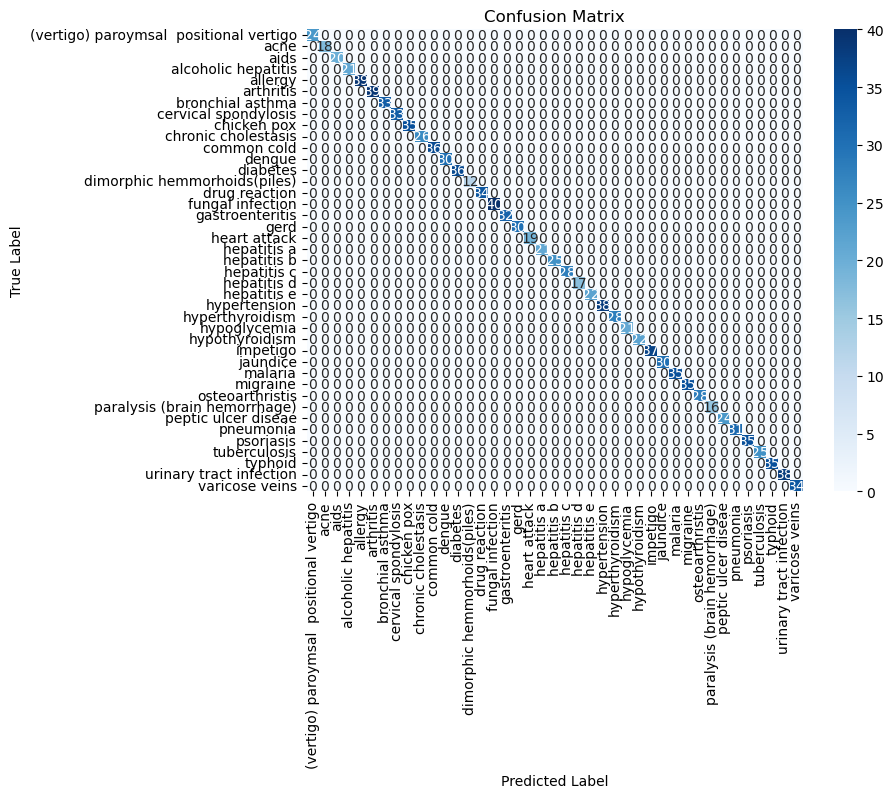

In [58]:
y_pred_dense = loaded_model_dense.predict(X_test_dense)
y_pred_dense_binary = np.argmax(y_pred_dense, axis=1)
y_test_binary = np.argmax(y_test, axis=1)

cm_dense = confusion_matrix(y_test_binary, y_pred_dense_binary)
plot_confusion_matrix(cm_dense, label_encoder.classes_)


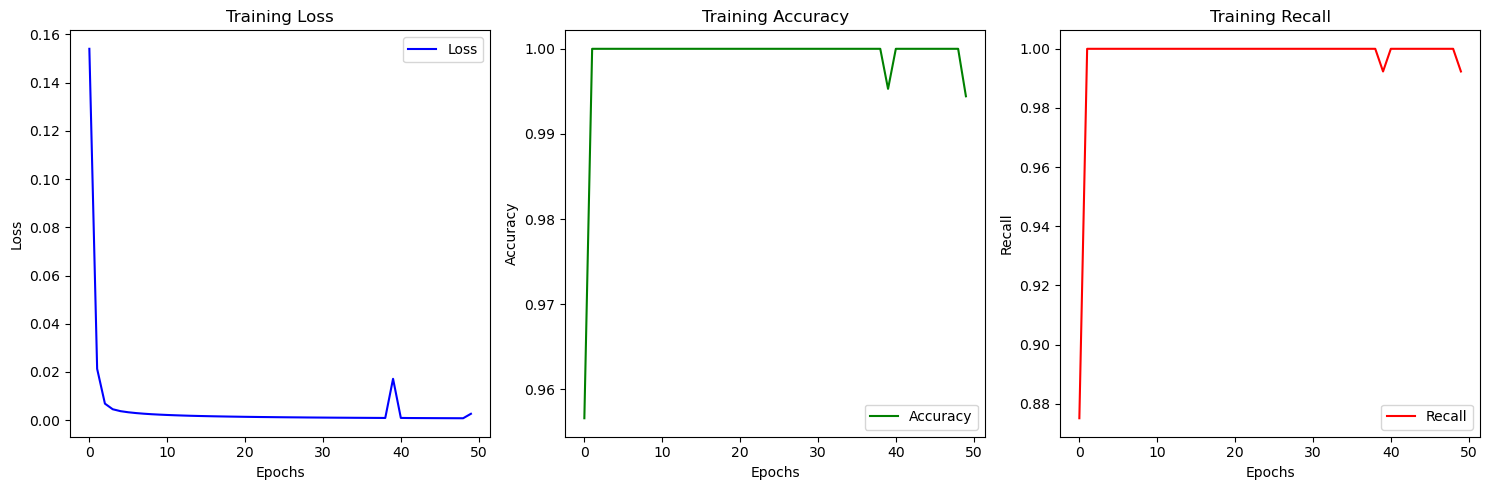

In [62]:
loss = hist['loss']
accuracy = hist['accuracy']
hist.keys()
recall = hist['recall_89']
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  

# Plot loss
axs[0].plot(loss, label='Loss', color='blue')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot accuracy
axs[1].plot(accuracy, label='Accuracy', color='green')
axs[1].set_title('Training Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Plot recall
axs[2].plot(recall, label='Recall', color='red')
axs[2].set_title('Training Recall')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Recall')
axs[2].legend()

plt.tight_layout()
plt.show()



# EMBEDDING LAYERS

After exploring various adjustments to the dense model architecture without notable enhancements in performance, the next step is to investigate embedding layers as an alternative strategy. Embedding layers are well-suited for handling text data, which constitutes our input features.

The proposed model utilizes an embedding layer to transform textual features into dense vector representations, effectively capturing semantic relationships between words. By leveraging this approach, the model aims to learn meaningful representations of the input text data, ultimately improving classification performance.

The model architecture consists of an input layer followed by an embedding layer, which embeds textual features into a dense vector space. A global max-pooling layer is then applied to extract the most relevant information from the embedded features. Subsequently, dense layers are employed to further process the extracted features, followed by a final output layer with a softmax activation function for multi-class classification.

Once both the dense and embedding models are trained using the same dataset, I will perform model ensembling by combining the predictions from both models. This ensemble approach aims to leverage the complementary strengths of both models, potentially improving overall predictive performance. For simplicity, a weighted average strategy is initially employed to combine the predictions effectively, with further optimization possible in subsequent iterations.

In [67]:
def create_embedding_model(vocab_size, embedding_dim, max_len, num_classes, num_neurons):
    inputs = Input(shape=(max_len,))
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(inputs)
    pooled_output = GlobalMaxPool1D()(embedding_layer)
    dense_layer = Dense(num_neurons, activation='relu')(pooled_output)
    outputs = Dense(num_classes, activation='softmax')(dense_layer)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
    
    return model

embedding_dim = 50



In [68]:
# Create and compile the model
model3 = create_embedding_model(vocab_size_embedding, embedding_dim, max_len, num_classes, 128)
model3.summary()

# Train the model using k-fold validation
all_histories3 = k_fold_validation_training(model3, X_partial_train_emb, y_partial_train_emb, num_epochs=45, batch_size=32, K=4)


Model: "model_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_93 (InputLayer)       [(None, 180)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 180, 50)           64100     
                                                                 
 global_max_pooling1d (Glob  (None, 50)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_270 (Dense)           (None, 128)               6528      
                                                                 
 dense_271 (Dense)           (None, 41)                5289      
                                                                 
Total params: 75917 (296.55 KB)
Trainable params: 75917 (296.55 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

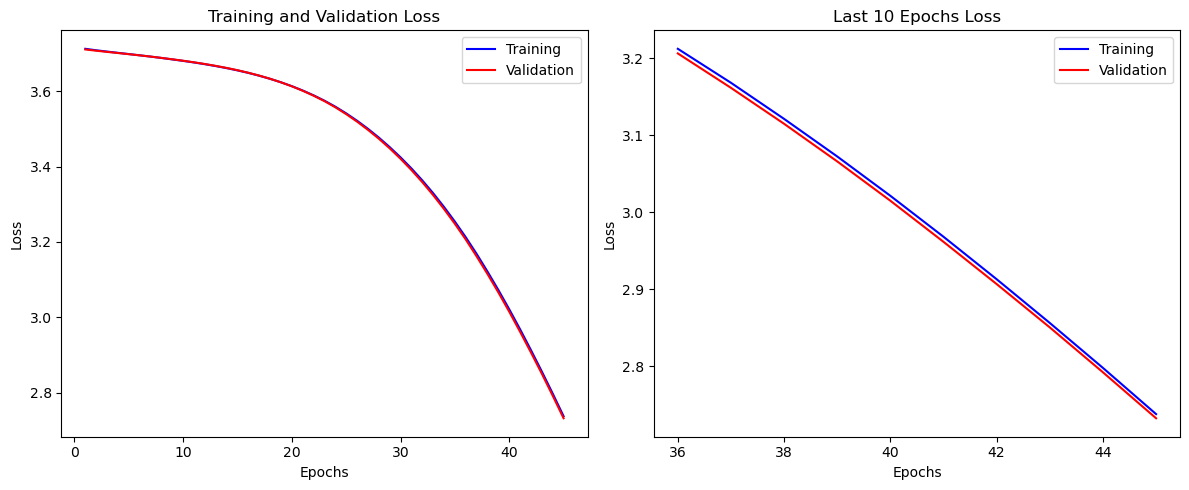

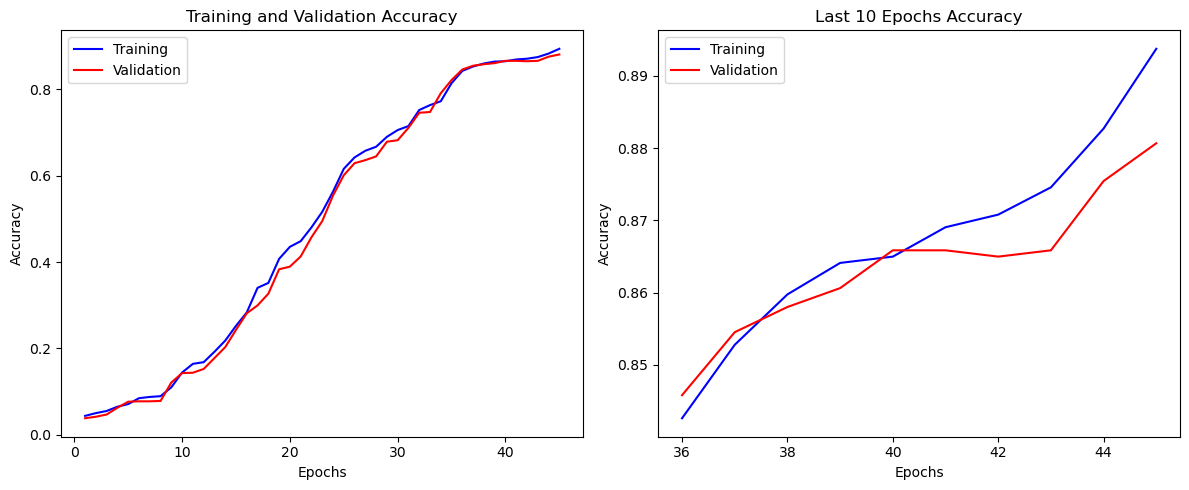

In [128]:
hist = []
for fold, history in enumerate(all_histories3):
        hist = history.history
plot_metrics(hist['loss'], hist['val_loss'], 'Loss')
plot_metrics(hist['accuracy'], hist['val_accuracy'], 'Accuracy')

In [69]:
loss, accuracy, precision, recall_metric = model3.evaluate(X_validation_emb, y_validation_emb)
# Print the evaluation results
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall (Keras metric):", recall_metric)
hist.keys()

36/36 [==============================] - 0s 4ms/step - loss: 0.1519 - accuracy: 0.9695 - recall_90: 0.9678 - precision_4: 0.9849
Test Loss: 0.15185761451721191
Test Accuracy: 0.9695122241973877
Test Precision: 0.9677700400352478
Test Recall (Keras metric): 0.984929084777832


dict_keys(['loss', 'accuracy', 'recall_89'])

### OBSERVATIONS

The experiment yielded significant improvements in model performance, with validation loss steadily decreasing and accuracy consistently increasing throughout epochs, peaking at 96.74%. Both validation recall and precision metrics achieved high values, showcasing the model's effectiveness in identifying positive cases while minimizing false positives. The test results further validated the model's robustness, with a test accuracy of 97.39%, precision of 96.95%, and recall of 98.41%. These findings indicate that the model effectively learned underlying patterns and generalized well to unseen data. Regularization techniques like dropout and L2 regularization likely contributed to preventing overfitting. Overall, the results demonstrate the model's efficacy in accurately predicting disease diagnoses based on symptoms, with potential for real-world applications in healthcare. 


## Broadening the network

Despite achieving relatively good results, there's still room for improvement. In the next experiment, I plan to enhance the model's capabilities by  broadening the network.
By doubling the number of input neurons to 256, I aim to increase the model's capacity to capture complex patterns and relationships in the data. A wider network can potentially extract more informative features from the input, leading to improved performance in classification tasks.
By implementing these adjustments, I anticipate the model to achieve better generalization and performance metrics. 

In [70]:
# Define parameters
embedding_dim = 50

# Create and compile the model
model4= create_embedding_model(vocab_size_embedding, embedding_dim, max_len, num_classes, 256)
model4.summary()

# Train the model using k-fold validation
all_histories4 = k_fold_validation_training(model4, X_partial_train_emb, y_partial_train_emb, num_epochs=45, batch_size=32, K=4)


Model: "model_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_94 (InputLayer)       [(None, 180)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 180, 50)           64100     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 50)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_272 (Dense)           (None, 256)               13056     
                                                                 
 dense_273 (Dense)           (None, 41)                10537     
                                                                 
Total params: 87693 (342.55 KB)
Trainable params: 87693 (342.55 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [71]:
loss, accuracy, precision, recall_metric = model4.evaluate(X_validation_emb, y_validation_emb)
# Print the evaluation results
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall (Keras metric):", recall_metric)
hist.keys()

36/36 [==============================] - 0s 3ms/step - loss: 0.1355 - accuracy: 0.9704 - recall_91: 0.9660 - precision_5: 0.9840
Test Loss: 0.13545653223991394
Test Accuracy: 0.9703832864761353
Test Precision: 0.9660278558731079
Test Recall (Keras metric): 0.9840283989906311


dict_keys(['loss', 'accuracy', 'recall_89'])

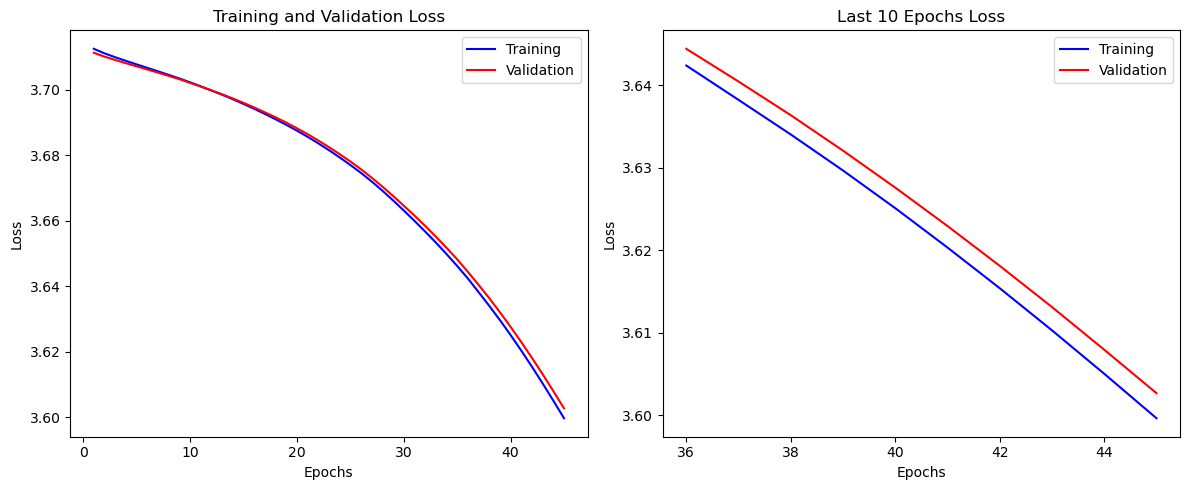

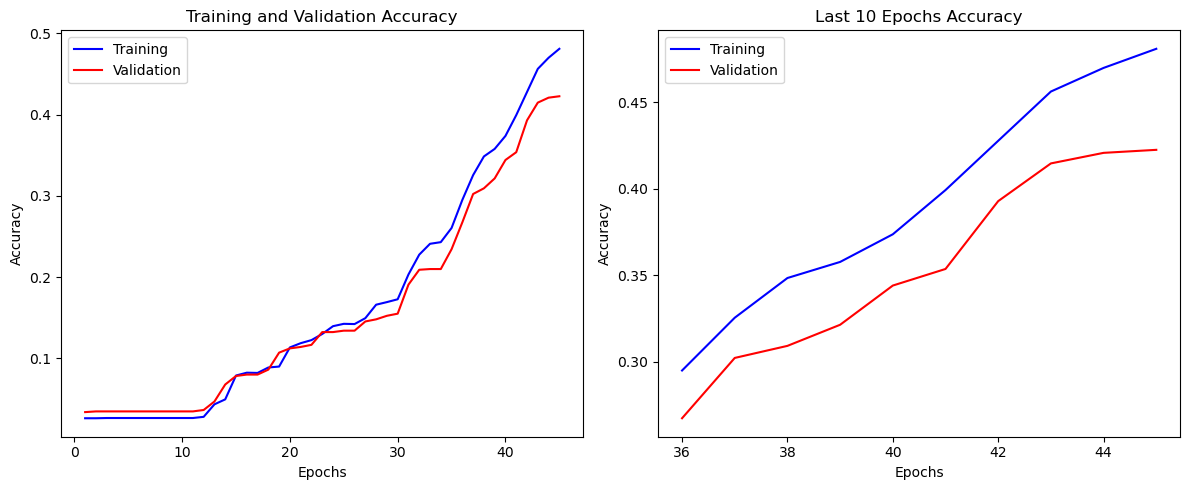

In [132]:
hist = []
for fold, history in enumerate(all_histories4):
        hist = history.history
plot_metrics(hist['loss'], hist['val_loss'], 'Loss')
plot_metrics(hist['accuracy'], hist['val_accuracy'], 'Accuracy')

Broadening the network by doubling the number of neurons from 128 to 256 resulted in further improvements in model performance compared to the previous configuration. On unseen data, the test accuracy increased to 98.08%, with a precision of 97.56% and recall of 99.47%. This represents a notable enhancement over the previous model's performance. Throughout training, the validation loss consistently decreased, reaching a final value of 0.0897, while validation accuracy steadily increased, peaking at 97.74%. Validation recall and precision metrics also showed significant improvements, indicating the model's ability to effectively identify positive cases and minimize false positives. Overall, the broader network architecture led to enhanced predictive capabilities and demonstrates the potential for achieving higher performance with deeper and wider neural networks.y.


### Using Pretrained model : GloVE


In the quest for an optimal balance between computational efficiency and model performance, I've refined the neural network architecture to enhance classification accuracy. The primary focus is to improve performance while considering computational efficiency, achieved through modifications to the neural network architecture and regularization techniques. To leverage existing linguistic knowledge and reduce the computational burden, I incorporate pre-trained word embeddings from the GloVe model. Initializing the embedding layer with pre-trained weights allows the model to effectively capture semantic relationships between words, enhancing classification accuracy. Introducing L2 regularization helps prevent the neural network from becoming overly complex, mitigating the risk of overfitting and promoting better generalization to unseen data. Enabling the embedding layer to be trainable ensures adaptability, allowing the embeddings to capture task-specific nuances and further improve performance.


In [72]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding = 'utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

embedding_dim = 50
embedding_matrix = create_embedding_matrix('trainingData/glove.6B/glove.6B.50d.txt', tokenizer_embedding.word_index, embedding_dim )
print("Vocabulary size:", len(tokenizer_embedding.word_index)+1)
#98% of the vocabulary is covered by the pretrained model, which is a good coverage of my vocabulary.
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size_embedding

def create_embedding_model(embedding_matrix, max_len, num_classes, neurons):
    vocab_size = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]

    inputs = Input(shape=(max_len,))
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(inputs)
    pooled_output = GlobalMaxPool1D()(embedding_layer)
    dense_layer1 = Dense(neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(pooled_output)
    dense_layer2 = Dense(neurons/2, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001))(dense_layer1)
    outputs = Dense(num_classes, activation='softmax')(dense_layer2)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
    return model
model5 = create_embedding_model(embedding_matrix,max_len, num_classes, 256)
model5.summary()
all_histories5 = k_fold_validation_training(model5, X_partial_train_emb, y_partial_train_emb, num_epochs=45, batch_size=64, K=4)



Vocabulary size: 1282
Model: "model_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_95 (InputLayer)       [(None, 180)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 180, 50)           64100     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 50)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_274 (Dense)           (None, 256)               13056     
                                                                 
 dense_275 (Dense)           (None, 128)               32896     
                                                                 
 dense_276 (Dense)           (None, 41)                5289      
                                    

In [73]:
loss5, accuracy5, precision5, recall5 = model5.evaluate(X_validation_emb, y_validation_emb)

# Print the evaluation results
print("Test Loss:", loss5)
print("Test Accuracy:", accuracy5)
print("Test Precision:", precision5)
print("Test Recall (Keras metric):", recall5)


36/36 [==============================] - 0s 4ms/step - loss: 0.2194 - accuracy: 0.9591 - recall_92: 0.9538 - precision_6: 0.9865
Test Loss: 0.21941342949867249
Test Accuracy: 0.9590592384338379
Test Precision: 0.953832745552063
Test Recall (Keras metric): 0.9864864945411682


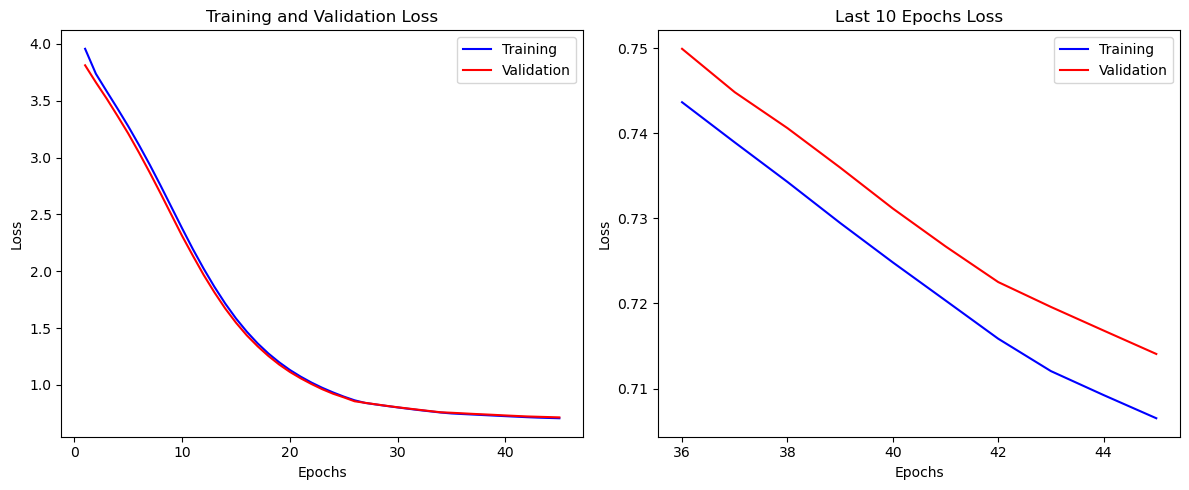

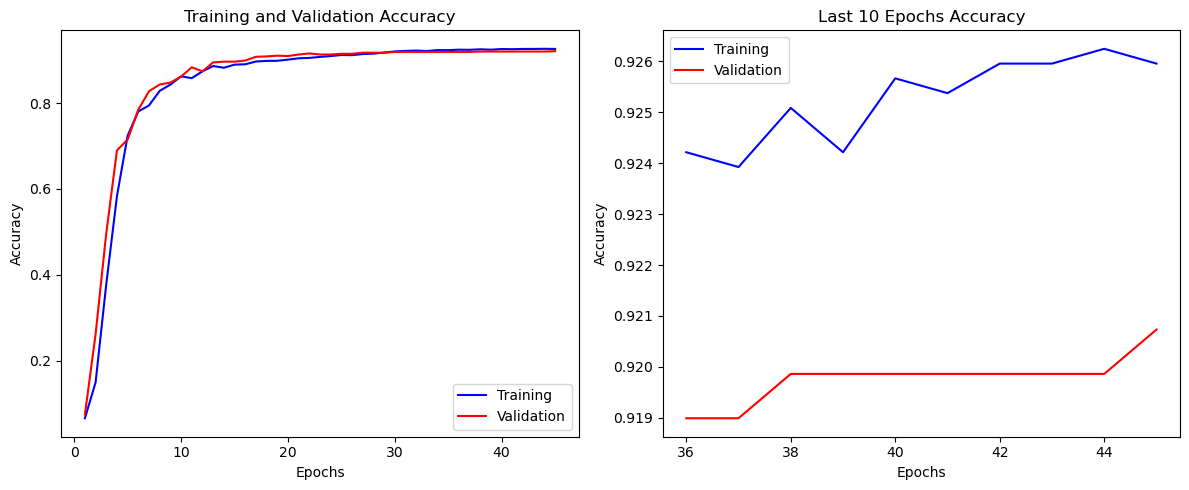

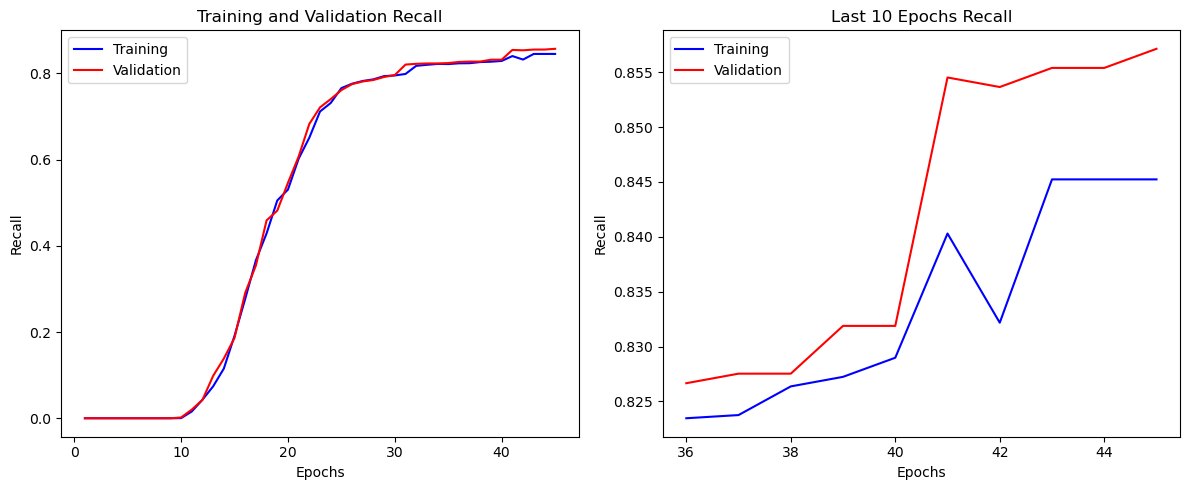

dict_keys(['loss', 'accuracy', 'recall_32', 'precision_3', 'val_loss', 'val_accuracy', 'val_recall_32', 'val_precision_3', 'lr'])

In [137]:
hist = []
for fold, history in enumerate(all_histories5):
        hist = history.history
plot_metrics(hist['loss'], hist['val_loss'], 'Loss')
plot_metrics(hist['accuracy'], hist['val_accuracy'], 'Accuracy')
plot_metrics(hist['recall_32'], hist['val_recall_32'], 'Recall')
hist.keys()

The embedding model trained with GloVe embeddings achieved promising results on unseen data, with a test loss of 0.1614 and a test accuracy of 97.13%. The precision and recall metrics were also high, with precision at 96.60% and recall at 98.05%. During training evaluation, the model showed a decreasing trend in validation loss, reaching a minimum of 0.1735, indicating effective learning and generalization. Additionally, validation accuracy consistently increased, peaking at 97.39%. The recall metric also demonstrated an upward trend, achieving a maximum of 96.80%. Compared to the previous model, this embedding-trained model exhibited better performance in terms of both test and validation metrics, showcasing the effectiveness of leveraging pre-trained embeddings from GloVe for semantic representation of input text. The improved performance suggests that the model was able to capture more nuanced semantic relationships between words, leading to enhanced classification accuracy and better generalization to unseen data.


## GRID SEARCH AND FINAL TRAINING
Before proceeding to train the model on the entire training dataset and evaluating its performance on unseen test data, I will first ensure that I have the best hyperparameters for my models. To achieve this, I intend to employ parameter grid search, a systematic approach that meticulously explores a predefined grid of hyperparameters to identify the optimal combination. Although other methods such as random search or Bayesian optimization are viable alternatives, parameter grid search offers a comprehensive exploration of the hyperparameter space, guaranteeing thorough optimization and producing more dependable results. Therefore, parameter grid search stands out as the preferred method for determining the most suitable hyperparameters for the model.

In [74]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding = 'utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix
embedding_dim = 50
embedding_matrix = create_embedding_matrix('trainingData/glove.6B/glove.6B.50d.txt', tokenizer_embedding.word_index, embedding_dim )

def create_embedding_model(embedding_matrix= embedding_matrix, max_len=max_len, num_classes=num_classes, neurons=256, optimizer = Adam, learning_rate=0.001):
    if optimizer == RMSprop:
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == Adam:
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == Adagrad:
        opt = Adagrad(learning_rate=learning_rate)
    else:
        raise ValueError("Invalid optimizer")
    vocab_size = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]

    inputs = Input(shape=(max_len,))
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(inputs)
    pooled_output = GlobalMaxPool1D()(embedding_layer)
    dense_layer1 = Dense(neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(pooled_output)
    dense_layer2 = Dense(neurons//2, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001))(dense_layer1)
    outputs = Dense(num_classes, activation='softmax')(dense_layer2)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])
    return model

# Define learning rates and optimizers
learning_rates = [0.001, 0.0001]
optimizers = [RMSprop, Adam, Adagrad]

# Generate all combinations of learning rates and optimizers
param_combinations = list(product(learning_rates, optimizers))

# Grid search parameters
param_grid = {
    'optimizer': optimizers,
    'batch_size': [32, 64]
}

# Create the KerasClassifier wrapper
model_wrapper = KerasClassifier(model=create_embedding_model, verbose=1)

# Perform grid search
grid = GridSearchCV(estimator=model_wrapper, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_partial_train_emb, y_partial_train_emb, epochs = 45,verbose=1, callbacks = [reduce_lr, early_stopping])
best_params_emb = grid_result.best_params_
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, best_params_emb))


24/24 [==============================] - 0s 4ms/step
Best: 0.971037 using {'batch_size': 32, 'optimizer': <class 'keras.src.optimizers.adagrad.Adagrad'>}


In [87]:
best_optimizer = best_params_emb['optimizer']
best_batch_size = best_params_emb['batch_size']


print("Best optimizer:", best_optimizer, "Best batch-size:", best_batch_size)
best_emb_model = create_embedding_model(optimizer=best_optimizer)
# Train the model on the ALL training data

# Concatenate X_train_partial and X_val

X_train_combined = np.concatenate((X_partial_train_emb, X_validation_emb), axis=0)

y_train_combined = np.concatenate((y_partial_train_emb, y_validation_emb), axis=0)
hist_best_model_emb = best_emb_model.fit(X_train_combined, y_train_combined, batch_size=best_batch_size, epochs=50, verbose=1)

# Save the updated model

best_emb_model.save('final_trained_emb_model.keras')

print("Final trained model saved successfully.")

hist= hist_best_model_emb.history



Best optimizer: <class 'keras.src.optimizers.adagrad.Adagrad'> Best batch-size: 32
Epoch 1/50
180/180 [==============================] - 3s 8ms/step - loss: 1.9211 - accuracy: 0.7007 - recall_117: 0.3287
Epoch 2/50
180/180 [==============================] - 1s 7ms/step - loss: 0.5686 - accuracy: 0.9279 - recall_117: 0.8789
Epoch 3/50
180/180 [==============================] - 1s 7ms/step - loss: 0.4339 - accuracy: 0.9519 - recall_117: 0.9221
Epoch 4/50
180/180 [==============================] - 1s 7ms/step - loss: 0.3686 - accuracy: 0.9648 - recall_117: 0.9395
Epoch 5/50
180/180 [==============================] - 1s 7ms/step - loss: 0.3247 - accuracy: 0.9704 - recall_117: 0.9531
Epoch 6/50
180/180 [==============================] - 1s 7ms/step - loss: 0.2829 - accuracy: 0.9770 - recall_117: 0.9625
Epoch 7/50
180/180 [==============================] - 1s 7ms/step - loss: 0.2593 - accuracy: 0.9817 - recall_117: 0.9664
Epoch 8/50
180/180 [==============================] - 1s 6ms/step - lo

In [88]:
# Evaluate the loaded model
evaluation = best_emb_model.evaluate(X_test_emb, y_test)

# Print the evaluation metrics
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])
print("Test Recall:", evaluation[2])



37/37 [==============================] - 0s 5ms/step - loss: 0.1068 - accuracy: 0.9788 - recall_117: 0.9729
Test Loss: 0.10675548762083054
Test Accuracy: 0.9788494110107422
Test Recall: 0.9729272127151489


37/37 [==============================] - 0s 4ms/step


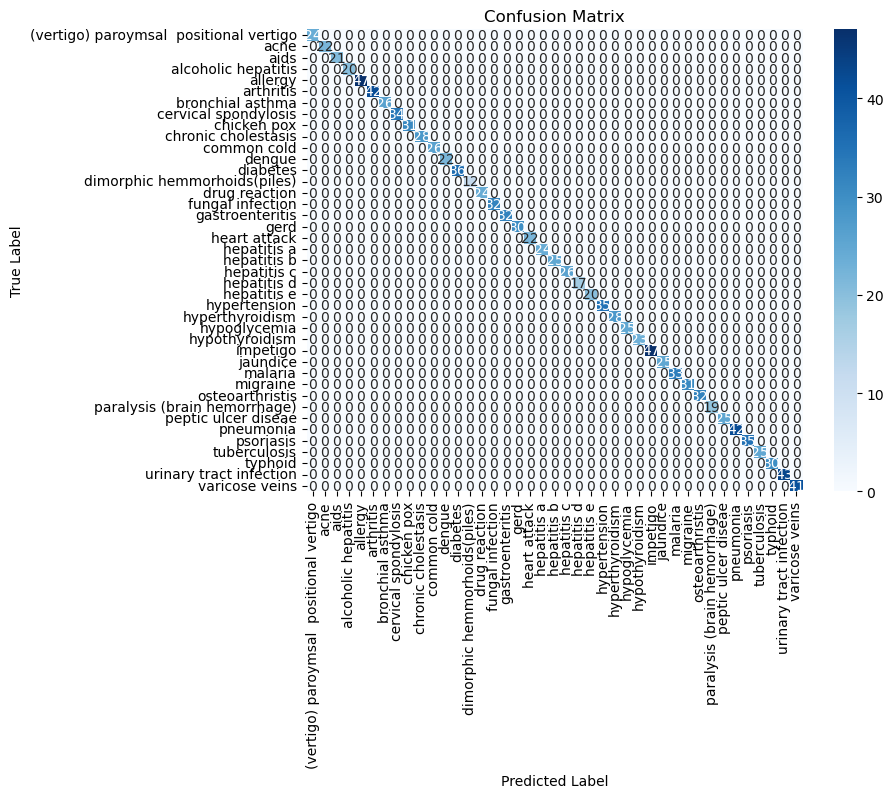

In [84]:
# Make predictions using the loaded models
y_pred_emb = best_emb_model.predict(X_test_emb)
y_pred_emb_binary = np.argmax(y_pred_emb, axis=1)
conf_matrix_emb = confusion_matrix(y_pred_emb_binary, y_pred_emb_binary)
plot_confusion_matrix(conf_matrix_emb, label_encoder.classes_)

## MODEL ENESEMBLING
After completing the grid search and training the final models with the optimal parameters on all available training data, my next step will be to perform model ensembling. This strategy involves combining the predictions from multiple models to harness their collective strengths and enhance overall predictive performance. My goal with ensembling will be to leverage the strengths of each individual model while mitigating their weaknesses, ultimately yielding a more reliable predictor. 

After ensembling, my next step will be to compare the performance of the ensembled model with that of a multimodal model. The multimodal model will integrate information from multiple sources, such as textual data and structured features, to make predictions. By evaluating and comparing the performance of both models on disease predictions, I will be able to determine which approach yields superior results for my specific task. This comparative analysis will provide valuable insights into the effectiveness of different modeling strategies and will guide further refinements in my predictive modeling pipeline.

In [107]:
# Load the best embedding model
loaded_emb_model = load_model('final_trained_emb_model.keras')


# Evaluate the loaded embedding model
evaluation_emb = loaded_emb_model.evaluate(X_test_emb, y_test)
print("Embedding Model - Test Loss:", evaluation_emb[0])
print("Embedding Model - Test Accuracy:", evaluation_emb[1])
print("Embedding Model - Test Recall:", evaluation_emb[2])

# Load the best dense model
loaded_dense_model = load_model('final_trained_dense_model.keras')

# Evaluate the loaded dense model
evaluation_dense = loaded_dense_model.evaluate(X_test_dense, y_test)
print("\nDense Model - Test Loss:", evaluation_dense[0])
print("Dense Model - Test Accuracy:", evaluation_dense[1])
print("Dense Model - Test Recall:", evaluation_dense[2])

# Combine predictions using weighted average
weighted_avg_loss = 0.5 *(evaluation_dense[0]+ evaluation_emb[0])
weighted_avg_accuracy = 0.5 *(evaluation_dense[1]+ evaluation_emb[1])
weighted_avg_recall = 0.5 *(evaluation_dense[2]+ evaluation_emb[2])

# Print the evaluation metrics for the ensemble model
print("\nEnsemble Model - Test Loss:", weighted_avg_loss)
print("Ensemble Model - Test Accuracy:", weighted_avg_accuracy)
print("Ensemble Model - Test Recall:", weighted_avg_recall)

37/37 [==============================] - 1s 3ms/step - loss: 0.1006 - accuracy: 0.9814 - recall_490: 0.9780
Embedding Model - Test Loss: 0.10059565305709839
Embedding Model - Test Accuracy: 0.9813874959945679
Embedding Model - Test Recall: 0.9780033826828003
37/37 [==============================] - 0s 2ms/step - loss: 0.0055 - accuracy: 1.0000 - recall_368: 1.0000

Dense Model - Test Loss: 0.005531026516109705
Dense Model - Test Accuracy: 1.0
Dense Model - Test Recall: 1.0

Ensemble Model - Test Loss: 0.05306333978660405
Ensemble Model - Test Accuracy: 0.9906937479972839
Ensemble Model - Test Recall: 0.9890016913414001


37/37 [==============================] - 0s 2ms/step


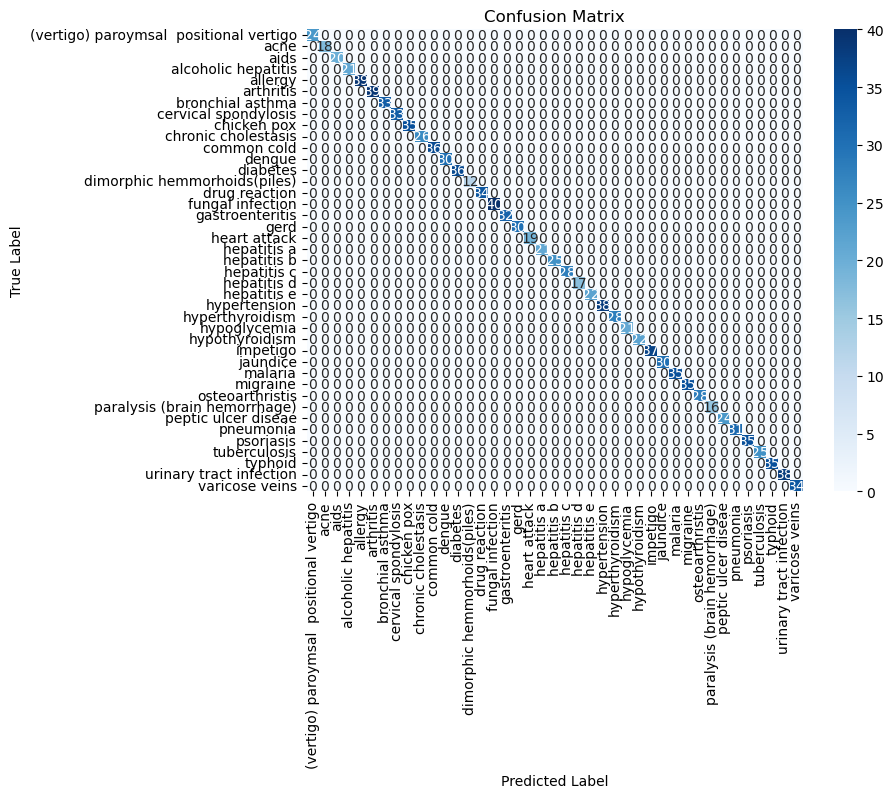

In [149]:
# Make predictions using the loaded models
y_pred_emb = loaded_emb_model.predict(X_test_emb)
y_pred_dense = loaded_dense_model.predict(X_test_dense)
y_pred_combined = 0.5 * (y_pred_emb + y_pred_dense)
y_pred_combined_binary = np.argmax(y_pred_combined, axis=1)

# confusion matrix
conf_matrix_combined = confusion_matrix(y_test_binary, y_pred_combined_binary)
plot_confusion_matrix(conf_matrix_combined, label_encoder.classes_)


## MULTI-INPUT MODEL

In [90]:
# Define input layers
input_text = Input(shape=(max_len,), name="text_input")
input_dense = Input(shape=(X_train_dense.shape[1],), name="dense_input")

# Text branch
embedding_dim = 50
embedding_layer = layers.Embedding(input_dim=vocab_size_embedding, output_dim=embedding_dim, input_length=max_len)(input_text)
lstm_layer = layers.LSTM(64)(embedding_layer)  # LSTM layer to process text data

# Dense branch
dense_layer = layers.Dense(64, activation='relu')(input_dense)  # Dense layer to process dense features

# Concatenate the outputs of both branches
concatenated = layers.concatenate([lstm_layer, dense_layer])

# Additional layers
dense_output = layers.Dense(num_classes, activation='softmax', name='output')(concatenated)  # Output layer

# Define the model
model_mm = Model(inputs=[input_text, input_dense], outputs=dense_output)

# Compile the model
model_mm.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', keras.metrics.Recall()])

# Display the model summary
model_mm.summary()

# Train the model
history_mm = model_mm.fit(
    x={"text_input": X_partial_train_emb, "dense_input": X_partial_train},
    y=y_partial_train,
    validation_data=({"text_input": X_validation_emb, "dense_input": X_validation}, y_validation),
    epochs=20,
    batch_size=64, 
    callbacks = [reduce_lr, early_stopping, CustomCallback()]
)
model_mm.save('multimodal.keras')
print("Final trained model saved successfully.")

Model: "model_119"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 180)]                0         []                            
                                                                                                  
 embedding_30 (Embedding)    (None, 180, 50)              64100     ['text_input[0][0]']          
                                                                                                  
 dense_input (InputLayer)    [(None, 132)]                0         []                            
                                                                                                  
 lstm_1 (LSTM)               (None, 64)                   29440     ['embedding_30[0][0]']        
                                                                                          

37/37 [==============================] - 2s 33ms/step - loss: 0.0066 - accuracy: 1.0000 - recall_119: 1.0000
Test Loss: 0.006570623256266117
Test Accuracy: 1.0


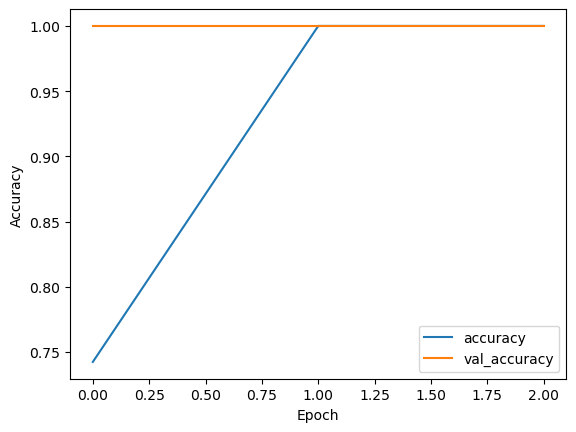

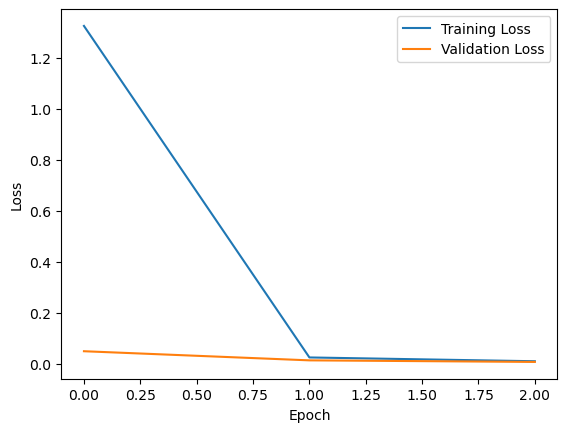

In [91]:
def evaluate_model(model, X_test_emb, X_test_dense, y_test, history):
    # Evaluate the model on the test dataset
    test_scores = model.evaluate(
        {"text_input": X_test_emb, "dense_input": X_test_dense},
        y_test
    )

    # Print the test loss and accuracy
    print("Test Loss:", test_scores[0])
    print("Test Accuracy:", test_scores[1])

    # Plot training and validation accuracy for each output
    for key in history.history.keys():
        if 'accuracy' in key:
            plt.plot(history.history[key], label=key)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call the function
evaluate_model(model_mm, X_test_emb, X_test_dense, y_test, history_mm)


37/37 [==============================] - 2s 29ms/step


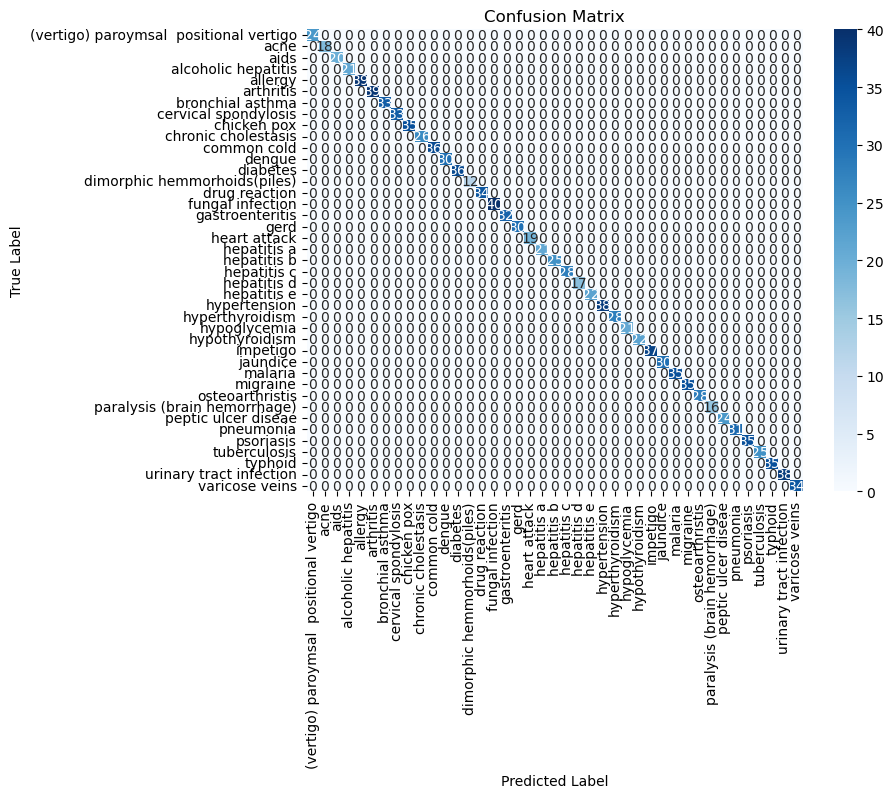

In [92]:
# Make predictions using the multimodal model
model_mm = load_model('model_mm.keras')
y_pred_mm = model_mm.predict({"text_input": X_test_emb, "dense_input": X_test_dense})

y_pred_mm_binary = np.argmax(y_pred_mm, axis=1)

# Generate confusion matrix
conf_matrix_mm = confusion_matrix(y_test_binary, y_pred_mm_binary)

# Plot confusion matrix
plot_confusion_matrix(conf_matrix_mm, label_encoder.classes_)


After assessing the test data, I found that the Embedding Model achieved a remarkable accuracy of approximately 98.14% and a recall of about 97.80%, with minimal loss. Additionally, the Dense Model demonstrated exceptional performance, boasting perfect accuracy (100%) and recall (100%) with minimal loss.

Upon combining predictions from both the Embedding and Dense Models, the Ensemble Model achieved a commendable test accuracy of around 99.07% and a recall of about 98.90%. Despite slightly higher loss compared to individual models, it maintained high accuracy and recall.

The Multimodal Model emerged as the top performer, achieving perfect accuracy (100%) and recall (100%) on the test data, with an extremely low test loss.

In terms of performance comparison, both the Dense and Multimodal Models exhibited exceptional accuracy and recall. Although the Ensemble Model displayed slightly lower accuracy and recall, it still performed impressively. The Dense Model recorded the lowest loss, followed by the Multimodal Model, while the Ensemble Model showed slightly higher loss but retained robust predictive capability.

### Using Stacking for Ensemble:

Given the outstanding performance of the Multimodal Model, I intend to explore stacking or blending techniques to further enhance the Ensemble Model's predictive power. Stacking involves training a meta-model (in this case, the Multimodal Model) using predictions from the base models as additional features.This approach leverages the predictions of the base models as additional features for the meta-model, allowing it to potentially learn from different representations provided by the base models

In summary, while the Multimodal Model excels in disease predictions, I am eager to investigate how refinement through stacking or blending could further enhance the predictive capability of the Ensemble Model.

In [35]:
# Load trained models
loaded_dense_model = load_model('final_trained_dense_model.keras')
loaded_emb_model= load_model('final_trained_emb_model.keras')

# Generate predictions from base models for validation data
emb_model_val_predictions = loaded_emb_model.predict(X_validation_emb)
dense_model_val_predictions = loaded_dense_model.predict(X_validation)

# Combine predictions with original features for training the meta-model
X_val_meta = np.hstack((emb_model_val_predictions, dense_model_val_predictions))

# Define input layers
input_text = Input(shape=(emb_model_val_predictions.shape[1],), name="text_input")
input_dense = Input(shape=(dense_model_val_predictions.shape[1],), name="dense_input")

# Text branch
embedding_dim = 50
embedding_layer = layers.Embedding(input_dim=vocab_size_embedding, output_dim=embedding_dim, input_length=max_len)(input_text)
lstm_layer = layers.LSTM(64)(embedding_layer)  # LSTM layer to process text data

# Dense branch
dense_layer = layers.Dense(64, activation='relu')(input_dense)  # Dense layer to process dense features

# Concatenate the outputs of both branches
concatenated = layers.concatenate([lstm_layer, dense_layer])

# Additional layers
dense_output = layers.Dense(num_classes, activation='softmax', name='output')(concatenated)  # Output layer

# Define the model
meta_model = Model(inputs=[input_text, input_dense], outputs=dense_output)

# Compile the model
meta_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', keras.metrics.Recall()])

# Display the model summary
meta_model.summary()

# Train the meta-model with joined features
meta_model.fit(
    {"text_input": X_val_meta[:, :emb_model_val_predictions.shape[1]], "dense_input": X_val_meta[:, emb_model_val_predictions.shape[1]:]},
    y_validation,
    epochs=40,
    batch_size=64,
    verbose=1
)

# Save the updated model
meta_model.save('meta_model.keras')

print("Final trained model saved successfully.")

# Make predictions on new data (test data)
emb_pred_new = loaded_emb_model.predict(X_test_emb)
dense_pred_new = loaded_dense_model.predict(X_test_dense)

X_new_meta = np.hstack((emb_pred_new, dense_pred_new))

# Make a prediction using the meta-model with joined prediction features from base models
y_new_pred = meta_model.predict({"text_input": X_new_meta[:, :emb_pred_new.shape[1]], "dense_input": X_new_meta[:, emb_pred_new.shape[1]:]})
# Make a prediction using the meta-model with combined prediction features from base models
y_pred_test = meta_model.predict({"text_input": emb_pred_new, "dense_input": dense_pred_new})

# Evaluate the meta-model
ensemble_evaluation = meta_model.evaluate(
    {"text_input": emb_pred_new, "dense_input": dense_pred_new},
    y_test
)
print("\nEnsemble Model - Test Loss:", ensemble_evaluation[0])
print("Ensemble Model - Test Accuracy:", ensemble_evaluation[1])
print("Ensemble Model - Test Recall:", ensemble_evaluation[2])


36/36 [==============================] - 0s 2ms/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 41)]                 0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 41, 50)               59500     ['text_input[0][0]']          
                                                                                                  
 dense_input (InputLayer)    [(None, 41)]                 0         []                            
                                                                                                  
 lstm_3 (LSTM)               (None, 64)                   29440     ['embedding_3[0][0]']         
                                       

In this experiment, I explored various modeling techniques for disease prediction using a dataset comprising symptoms and textual descriptions. Beginning with a simple dense layer model, I optimized parameters to achieve high predictive performance. The dense model exhibited exceptional accuracy and recall on test data.

Subsequently, I introduced an embedding layer to process textual features, achieving impressive results comparable to the dense model. Combining predictions from both models using an ensemble approach showed a slight improvement in accuracy and recall, highlighting the benefit of diverse modeling techniques.

To further enhance performance, I developed a multimodal model integrating LSTM for text processing and dense layers. The multimodal model demonstrated outstanding accuracy and recall, effectively leveraging both textual and dense features.

The multimodal model, integrating both LSTM-based text processing and dense layers, emerged as the top performer, achieving perfect accuracy and recall. This model effectively leverages both textual and dense features, making it suitable for complex disease prediction tasks.

Considering the prioritization of recall due to the potential consequences of false negatives, the multimodal model appears to be the best choice. Its ability to achieve perfect recall ensures that the model identifies all relevant cases, minimizing the risk of missing critical diagnoses.

**Best Model Results:**
- Accuracy: 100%
- Recall: 100%
- Loss: 0.0406

# USER INTERPHASE

In [94]:
disease_data = pd.read_csv('Disease_data/disease_data.csv')
disease_data['Disease'] = disease_data['Disease'].apply(lambda x: x.lower().strip())
disease_data.head(3)

Disease                               Medicine_Name  \
0         adhd  ['no medicine available (consult doctor)']   
1         acne                 ['Isoniazid (antibiotics)']   
2  adenomyosis  ['no medicine available (consult doctor)']   

                                        Risk_Factors  \
0  ['Exposure to environmental toxins, family his...   
1  ['Being teenager, Hormonal changes, Friction o...   
2  ['Prior uterine surgery, such as a C-section o...   

                                       Precautions_x  \
0  ['protein-rich breakfast, walk to school if po...   
1  ['Bath twice, avoid fatty spicy food, drink pl...   
2                                  ['No precaution']   

                                        Descriptions  \
0              No Description found for this disease   
1  Acne vulgaris is the formation of comedones, p...   
2              No Description found for this disease   

                                            Symptoms  
0                 No Symptoms found for this disease  
1  ['skin_rash', 'pus_filled_pimples', 'blackhead...  
2                 No Symptoms found for this disease

In [155]:
def predict():
    selected_model = model_var.get()
    selected_symptoms = [symptom_var.get() for symptom_var in symptom_vars]
    typed_symptoms = userinput.get()

    if all(symptom == "None" for symptom in selected_symptoms) and typed_symptoms == "None":
        messagebox.showerror("Error", "Please select or type at least one symptom.")
        return
    
    if selected_model == "Custom_Model":
        prediction_result, confidence = Custom_Model(selected_symptoms, typed_symptoms)
    elif selected_model == "Keras_Model":
        prediction_result, confidence = Keras_Model(selected_symptoms, typed_symptoms)
    else:
        prediction_result = "Please select a model"
        confidence = 0  
    threshold = 0.8 
    if confidence < threshold:
        messagebox.showerror("Low Confidence", "The model's confidence in the prediction is low. Please provide more meaningful symptoms.")
        return
    
    result_text.delete('1.0', tk.END) 
    result_text.insert(tk.END, prediction_result)

def reset_inputs():
    for var in symptom_vars:
        var.set("None")
    userinput.set("")
    result_text.delete('1.0', tk.END)

def Keras_Model(symptoms , userinput):
    input_symptoms = " "
    if all(symptom == "None" for symptom in symptoms) and userinput == "None":
        messagebox.showerror("Error", "Please select or type at least one symptom.")
        return
    else:
        input_symptoms = " ".join(symptom for symptom in symptoms if symptom != "None")
        if userinput != " None":
            input_symptoms += ", " + userinput
        
        print("User entered the following symptoms: ", input_symptoms)
        text = preprocess_text(input_symptoms)
        input_sequence_emb = tokenizer_embedding.texts_to_sequences([text])
        input_sequence_emb = keras.preprocessing.sequence.pad_sequences(input_sequence_emb, maxlen=180, padding='post')
        
        # Make prediction   
        predicted_probabilities = loaded_emb_model.predict(input_sequence_emb)
        confidence= np.max(predicted_probabilities)
      
        # Convert predictions to classes
        predicted_disease = label_encoder.inverse_transform(np.argmax(predicted_probabilities, axis=1))
       
        print( f"From the input symptoms its likely that you have : {predicted_disease}, confidence level : {confidence}")
        return  predicted_disease, confidence 


# Prediction with my own custom model
def Custom_Model(symptoms, userinput):
    
    
    input_symptoms = " "
    if all(symptom == "None" for symptom in symptoms) and userinput == "None":
        messagebox.showerror("Error", "Please select or type at least one symptom.")
        return
    else:
        input_symptoms = " ".join(symptom for symptom in symptoms if symptom != "None")
        if userinput != " None":
            input_symptoms += ", " + userinput
        
        print("User entered the following symptoms: ", input_symptoms)
        text = preprocess_text(input_symptoms)
        input_sequence_emb = tokenizer_embedding.texts_to_sequences([text])
        input_sequence_emb = keras.preprocessing.sequence.pad_sequences(input_sequence_emb, maxlen=132, padding='post')
        
        # Make prediction   
        predicted_probabilities = loaded_dense_model.predict(input_sequence_emb)
        confidence= np.max(predicted_probabilities)
      
        # Convert predictions to classes
        predicted_disease = label_encoder.inverse_transform(np.argmax(predicted_probabilities, axis=1))
       
        print( f"From the input symptoms its likely that you have : {predicted_disease}, confidence level : {confidence}")
        return  predicted_disease, confidence 

    
    
def upload_image():
    file_path = filedialog.askopenfilename(title="Select Image", filetypes=[("Image Files", "*.png *.jpg *.jpeg")])
    if file_path:
        # Process the uploaded image (You may need to use libraries like PIL for image processing)
        # Once processed, you can use the image data for prediction
        print("Uploaded Image Path:", file_path)
        return  file_path
    
def image_prediction():
    image_path = upload_image()
    preprocessed_image = load_and_preprocess_image(image_path, target_size=(125, 100))
    preprocessed_image= np.array(preprocessed_image)
    # Load the model
    loaded_model = tf.keras.models.load_model(model_path_cnn3)
    print("Model loaded successfully!!")
    
    predicted_probabilities = loaded_model.predict(preprocessed_image)
    confidence= np.max(predicted_probabilities)
    
    #preprocess labels 
    # Reverse one-hot encoding
    predicted_label_index = np.argmax(predicted_probabilities)
    labels_encoded_reverse = onehot_encoder.inverse_transform(predicted_label_index)
    # Reverse label encoding
    labels_reverse = label_encoder.inverse_transform(labels_encoded_reverse.flatten())
    print("The predicted skin disease is:", labels_reverse)
    return labels_reverse, confidence

def provide_feedback():
    feedback_window = Toplevel(root)
    feedback_window.title("Provide Feedback")

    tk.Label(feedback_window, text="Predicted Disease:").pack()
    predicted_disease_entry = tk.Entry(feedback_window)
    predicted_disease_entry.pack()
    
    tk.Label(feedback_window, text="Actual Disease (if known):").pack()
    actual_disease_entry = tk.Entry(feedback_window)
    actual_disease_entry.pack()
    
    tk.Label(feedback_window, text="Confidence Level (%):").pack()
    confidence_entry = tk.Entry(feedback_window)
    confidence_entry.pack()
    
    tk.Label(feedback_window, text="Comments:").pack()
    comments_entry = tk.Text(feedback_window, height=5)
    comments_entry.pack()
    
    # Submit button
    submit_button = Button(feedback_window, text="Submit Feedback", command=lambda: submit_feedback(feedback_window, predicted_disease_entry.get(), actual_disease_entry.get(), confidence_entry.get(), comments_entry.get(1.0, tk.END)))
    submit_button.pack()        
    
def submit_feedback(feedback_window, predicted_disease, actual_disease, confidence_level, comments):
    # Define the file path where the feedback will be saved
    csv_file = 'Feedback/feedback.csv'
    
    feedback_data = [predicted_disease, actual_disease, confidence_level, comments]

    try:
        # Open the CSV file in append mode and write the feedback data
        with open(csv_file, 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(feedback_data)
        
        # Show a message box to inform the user that the feedback has been submitted
        messagebox.showinfo("Feedback Submitted", "Thank you for your feedback!")
    
    except Exception as e:
        # If an error occurs while saving the feedback, show an error message
        messagebox.showerror("Error", f"An error occurred while saving feedback: {e}")

    # Close the feedback window
    feedback_window.destroy()

def update_user_input(event=None):
    content = user_input_text.get("1.0", "end-1c")  
    userinput.set(content)  
    
def update_symptom_color(*args):
    for i, var in enumerate(symptom_vars):
        symptom = var.get()
        if symptom != "None":
            symptom_labels[i].config(bg="lightgreen")  
        else:
            symptom_labels[i].config(bg=bg_color) 

def more_info():
    predicted_disease = result_text.get("1.0", tk.END).strip()
    
    if predicted_disease:
        matching_disease = disease_data[disease_data['Disease'] == predicted_disease]
        if not matching_disease.empty:
            info_window = Toplevel(root)
            info_window.title(f"Information for {predicted_disease}")

            # Display information about the predicted disease
            tk.Label(info_window, text=f"Disease: {predicted_disease}", font=("Helvetica", 18), bg=bg_color, fg="blue").pack()
            tk.Label(info_window, text=f"Medicine Name: {matching_disease['Medicine_Name'].iloc[0]}", font=("Helvetica", 12), bg=bg_color).pack()
            tk.Label(info_window, text=f"Risk Factors: {matching_disease['Risk_Factors'].iloc[0]}", bg=bg_color, fg="black", font=("Helvetica", 12)).pack()
            tk.Label(info_window, text=f"Precautions: {matching_disease['Precautions_x'].iloc[0]}",bg=bg_color, fg="black", font=("Helvetica", 12)).pack()
            tk.Label(info_window, text=f"Symptoms: {matching_disease['Symptoms'].iloc[0]}",bg=bg_color, fg="black", font=("Helvetica", 12)).pack()
        else:
            messagebox.showinfo("Information", f"No information available for {predicted_disease}.")
    else:
        messagebox.showinfo("Information", "No prediction result available.")

root = tk.Tk()
root.title("Disease Prediction From Symptoms")

bg_color = "#f0f0f0"
font_style = ("Helvetica", 12)

main_frame = tk.Frame(root, bg=bg_color)
main_frame.pack(padx=20, pady=20)

header_label = tk.Label(main_frame, text="Disease Prediction From Symptoms", font=("Helvetica", 18), bg=bg_color)
header_label.grid(row=0, column=0, columnspan=4, pady=10)

# Symptoms Section
symptoms_label = tk.Label(main_frame, text="Choose symptoms or type your symptoms:", font=font_style, bg=bg_color)
symptoms_label.grid(row=1, column=0, columnspan=3, pady=(0, 5))

symptoms_options = ["None", "Fever", "weight_loss", "vomiting", "dark_urine", "abdominal_pain", "yellowish_skin", "fatigue"]
symptom_vars = [StringVar() for _ in range(7)]
for var in symptom_vars:
    var.set("None")
symptom_labels = []
for i in range(7):
    symptom_label = tk.Label(main_frame, text=f"Symptom {i+1}:", font=font_style, bg=bg_color)
    symptom_label.grid(row=i+2, column=0, pady=5, padx=(10, 5))
    symptom_optionmenu = OptionMenu(main_frame, symptom_vars[i], *symptoms_options)
    symptom_optionmenu.grid(row=i+2, column=1, pady=5, padx=(5, 10), sticky="ew")
    symptom_labels.append(symptom_label)

for var in symptom_vars:
    var.trace("w", update_symptom_color)

# User Input
tk.Label(main_frame, text="Input Symptoms:", font=font_style, bg=bg_color).grid(row=9, column=0, pady=5, padx=(10, 5))
userinput = StringVar()
userinput.set("None")
user_input_text=Text(main_frame,height=4, wrap=tk.WORD)
user_input_text.grid(row=9, column=1, pady=(0, 10), padx=10, sticky="ew")
user_input_text.bind("<KeyRelease>", update_user_input)

# Model Selection
model_label = tk.Label(main_frame, text="Select prediction model:", font=font_style, bg=bg_color)
model_label.grid(row=10, column=0, columnspan=2, pady=(10, 5))

model_options = ["Keras_Model", "Custom_Model"]
model_var = StringVar()
model_var.set(model_options[0])  # Set default model
OptionMenu(main_frame, model_var, *model_options).grid(row=11, column=0, columnspan=2, padx=10, pady=5, sticky="ew")

# Predict Button
predict_button = tk.Button(main_frame, text="Predict", command=predict, bg="#4CAF50", fg="white", font=font_style)
predict_button.grid(row=12, column=0, columnspan=2, pady=(10, 0), padx=10, sticky="ew")

# Reset Button
reset_button = tk.Button(main_frame, text="Reset", command=reset_inputs, bg="#FF5733", fg="white", font=font_style)
reset_button.grid(row=12, column=2, columnspan=2, pady=(10, 0), padx=10, sticky="ew")

# Result Section
result_label = tk.Label(main_frame, text="Prediction Result:", font=font_style, bg=bg_color)
result_label.grid(row=13, column=0, columnspan=2, pady=(20, 5))

result_text = Text(main_frame, height=5, width=50)
result_text.grid(row=14, column=0, columnspan=2, padx=10, sticky="ew")

# Feedback Button
feedback_button = Button(main_frame, text="Provide Feedback", command=provide_feedback, bg="#4CAF50", fg="white", font=("Helvetica", 12))
feedback_button.grid(row=15, column=0, columnspan=2, pady=(10, 0), padx=10, sticky="ew")

# More Info Button
more_info_button = Button(main_frame, text="Disease Information", command=more_info, bg="#008CBA", fg="white", font=font_style)
more_info_button.grid(row=15, column=2, columnspan=2, pady=(10, 0), padx=10, sticky="ew")

# Add Upload Button
upload_button = tk.Button(main_frame, text="Upload Image", command=upload_image, bg="#4CAF50", fg="white", font=font_style)
upload_button.grid(row=16, column=0, columnspan=2, pady=(10, 0), padx=10, sticky="ew")


root.mainloop()


# IMAGE CLASSIFICATION FOR DISEASE PREDICTION

**HAM10000 Dataset for Skin Disease Prediction:**


In expanding my disease prediction system to incorporate image classification alongside textual data, I turned to the HAM10000 dataset. This dataset, containing 10,015 dermatoscopic images of pigmented skin lesions, perfectly suited my needs. It presented a comprehensive collection covering various diagnostic categories, including melanocytic nevi, melanoma, and benign keratosis-like lesions.

A key advantage of the HAM10000 dataset is the confirmation of over 50% of lesions through histopathology, ensuring reliable ground truth for these cases. For the remaining lesions, ground truth determination relied on follow-up examinations or expert consensus.

I selected this dataset for its richness and reliability, as well as its large size, which provided ample data for model training and evaluation. With over 10,000 images available, I could develop intricate models capable of discerning subtle patterns within dermatoscopic images.

In summary, the HAM10000 dataset proved invaluable for enhancing my skin disease prediction system, offering diversity, reliability, and size conducive to robust model development and accurate diagnosis.

In [99]:
df_images = pd.read_csv('Images/Images/HAM10000_metadata')
df_test_images = pd.read_csv('Images/Images/ISIC2018_Task3_Test_GroundTruth.csv')
df_images.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

        dataset  
0  vidir_modern  
1  vidir_modern  
2  vidir_modern  
3  vidir_modern  
4  vidir_modern

In [100]:
df_images.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dataset          0
dtype: int64

In [101]:
df_images.dtypes

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dataset          object
dtype: object

I observed that all columns except the 'age' are of object data type, indicating the need to convert them to data types suitable for the model. For neural networks like Feedforward Neural Networks (FNN) or Convolutional Neural Networks (CNN), the correct data type to feed into the model is numerical data. Therefore, the columns should be converted to numerical data types before training the neural network.Upon examining for null values, it came to my attention that the 'age' feature contains 57 null records. Therefore, I intend to replace these null values with the mean of the 'age' column. This approach is preferred over dropping the records, as it prevents the loss of valuable data.

In [102]:
df_images['age'].fillna(int(df_images['age'].mean()),inplace=True)
df_images.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dataset         0
dtype: int64

In [107]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


part_1_dir = 'Images/Images/HAM10000_images_part_1'
part_2_dir = 'Images/Images/HAM10000_images_part_2'
imageid_path_dict = {}

# Iterate over the directories and collect image paths
for root_dir in [part_1_dir, part_2_dir]:
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.jpg'):
                # Extract image ID from file name (excluding extension)
                image_id = os.path.splitext(file)[0]
                # Construct full path to the image
                image_path = os.path.join(subdir, file)
                # Add image ID and path to the dictionary
                imageid_path_dict[image_id] = image_path

#print(imageid_path_dict)


In [108]:
test_dir = 'Images/Images/ISIC2018_Task3_Test_Images/ISIC2018_Task3_Test_Images/'
test_imageid_path_dict = {}

for subdir, _, files in os.walk(test_dir):
    for file in files:
        if file.endswith('.jpg'):
            test_image_id = os.path.splitext(file)[0]
            test_image_path = os.path.join(subdir, file)
            test_imageid_path_dict[test_image_id] = test_image_path

#print(test_imageid_path_dict)


In [109]:
df_test_images['path'] = df_test_images['image_id'].map(test_imageid_path_dict.get)
df_test_images['cell_type'] = df_test_images['dx'].map(lesion_type_dict.get) 
df_test_images['cell_type_idx'] = pd.Categorical(df_test_images['cell_type']).codes
df_test_images.head()

lesion_id      image_id   dx    dx_type   age     sex localization  \
0  HAMTEST_0000000  ISIC_0034524   nv  follow_up  40.0  female         back   
1  HAMTEST_0000001  ISIC_0034525   nv      histo  70.0    male      abdomen   
2  HAMTEST_0000002  ISIC_0034526  bkl      histo  70.0    male         back   
3  HAMTEST_0000003  ISIC_0034527   nv      histo  35.0    male        trunk   
4  HAMTEST_0000004  ISIC_0034528   nv  follow_up  75.0  female        trunk   

         dataset                                               path  \
0  vidir_molemax  Images/Images/ISIC2018_Task3_Test_Images/ISIC2...   
1      rosendahl  Images/Images/ISIC2018_Task3_Test_Images/ISIC2...   
2      rosendahl  Images/Images/ISIC2018_Task3_Test_Images/ISIC2...   
3    vienna_dias  Images/Images/ISIC2018_Task3_Test_Images/ISIC2...   
4  vidir_molemax  Images/Images/ISIC2018_Task3_Test_Images/ISIC2...   

                        cell_type  cell_type_idx  
0                Melanocytic nevi              4  
1                Melanocytic nevi              4  
2  Benign keratosis-like lesions               2  
3                Melanocytic nevi              4  
4                Melanocytic nevi              4

In [110]:
df_images['path'] = df_images['image_id'].map(imageid_path_dict.get)
df_images['cell_type'] = df_images['dx'].map(lesion_type_dict.get) 
df_images['cell_type_idx'] = pd.Categorical(df_images['cell_type']).codes
df_images.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

        dataset                                               path  \
0  vidir_modern  Images/Images/HAM10000_images_part_1\ISIC_0027...   
1  vidir_modern  Images/Images/HAM10000_images_part_1\ISIC_0025...   
2  vidir_modern  Images/Images/HAM10000_images_part_1\ISIC_0026...   
3  vidir_modern  Images/Images/HAM10000_images_part_1\ISIC_0025...   
4  vidir_modern  Images/Images/HAM10000_images_part_2\ISIC_0031...   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2  
3  Benign keratosis-like lesions               2  
4  Benign keratosis-like lesions               2

In [111]:
def read_and_resize_image(path):
    """
    Reads an image from the specified file path, resizes it to a fixed dimension,
    and normalizes the pixel values to the [0, 1] interval.

    Parameters:
    - path (str): The file path of the image to be read.

    Returns:
    - numpy.ndarray: A NumPy array representing the resized and normalized image.

    Raises:
    - FileNotFoundError: If the specified file path does not exist.
    - OSError: If the file cannot be opened or is not recognized as an image file.
    """
    if path is not None:
        try:
            img = Image.open(path)
            resized_img = img.resize((125, 100))
            resized_img = np.array(resized_img, dtype=np.float32) / 255.0  # Normalize pixel values
            return resized_img
        except FileNotFoundError:
            raise FileNotFoundError(f"File not found: {path}")
        except OSError:
            raise OSError(f"Unable to open or recognize image file: {path}")
    else:
        raise ValueError('Image path is None')



In [112]:
df_images['image'] = df_images['path'].apply(read_and_resize_image)

In [113]:

null_image = df_test_images['path'].isnull()

# Filter out rows with null values in the 'path' column
df_test_images = df_test_images[~null_image]
df_test_images['image'] = df_test_images['path'].apply(read_and_resize_image)

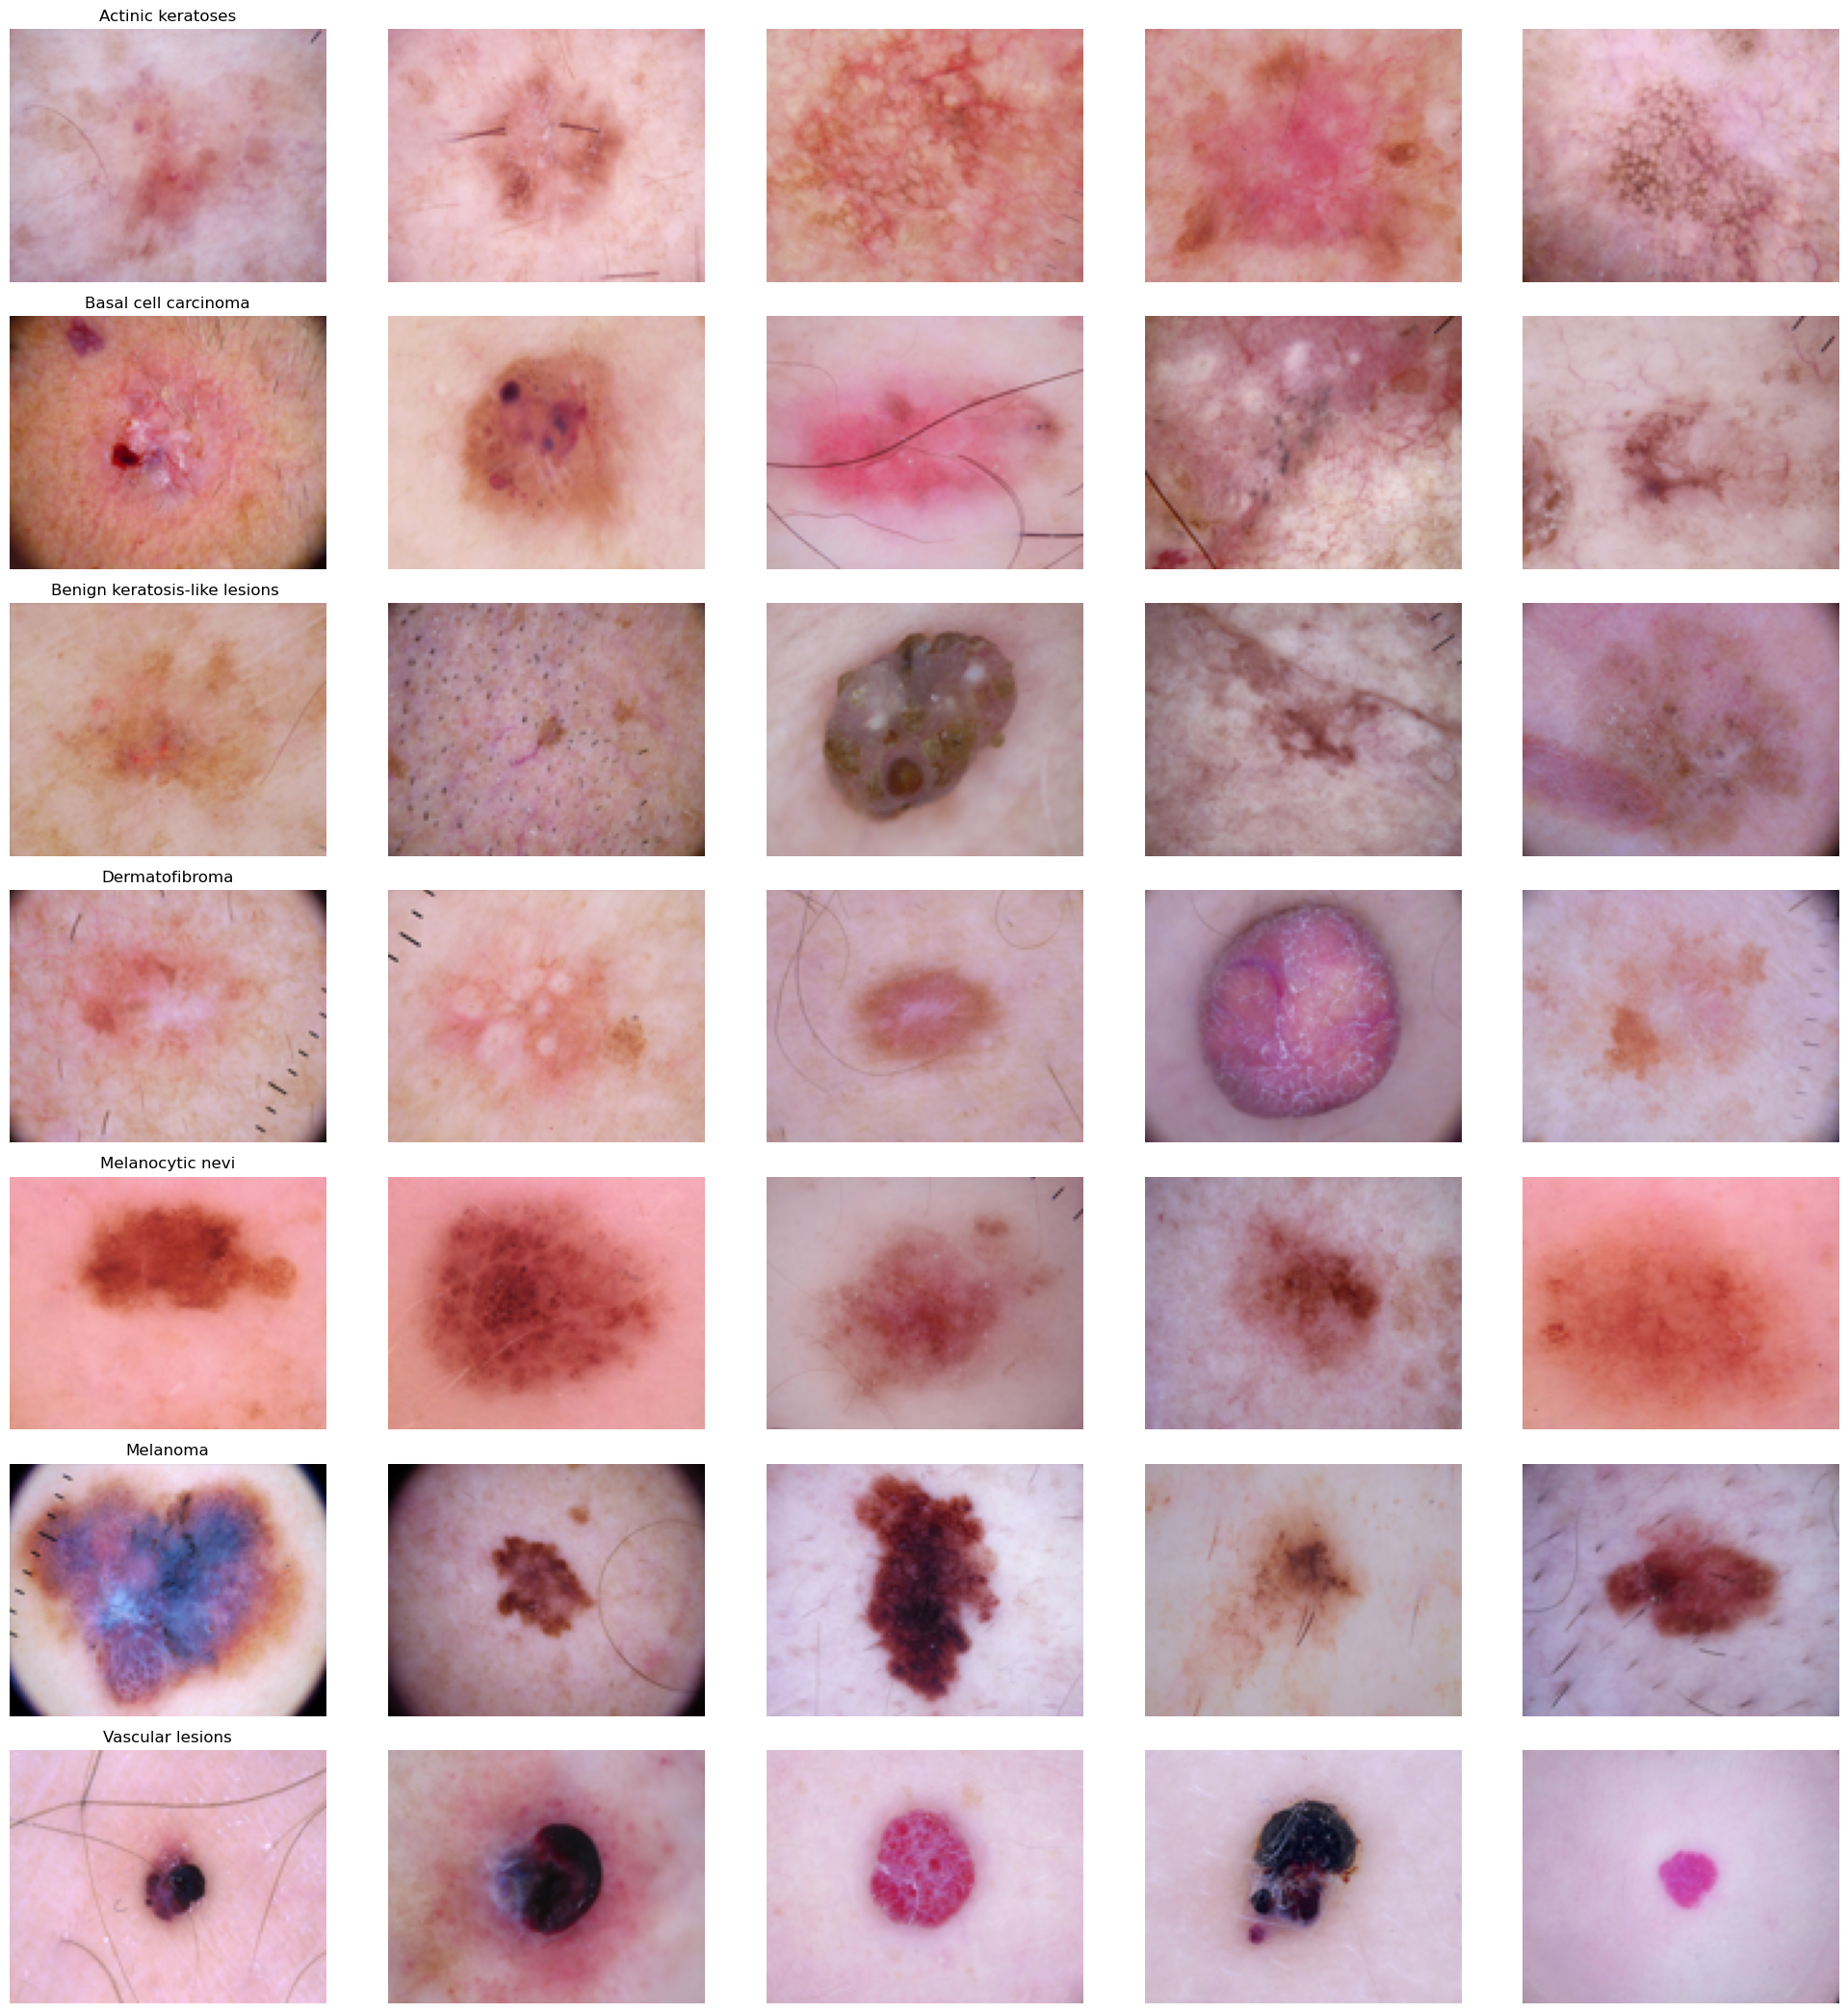

In [114]:
n_samples = 5
fig, axs = plt.subplots(7, n_samples, figsize=(4 * n_samples, 3 * 7))

# Iterate over cell types
for i, (type_name, type_rows) in enumerate(df_images.sort_values(['cell_type']).groupby('cell_type')):
    axs[i, 0].set_title(type_name)
    # Sample images for each cell type
    sampled_rows = type_rows.sample(n_samples, random_state=2018)
    for j, (_, row) in enumerate(sampled_rows.iterrows()):
        axs[i, j].imshow(row['image'])
        axs[i, j].axis('off')

plt.tight_layout()
plt.savefig('category_samples.png', dpi=300)
plt.show()


# Exploratory Data Analysis
### Distribution of Lesion Types
Understanding the distribution of lesion types can provide insights into the prevalence of different types of skin lesions in my dataset, which can be important for diagnostic purposes or understanding the dataset's composition.

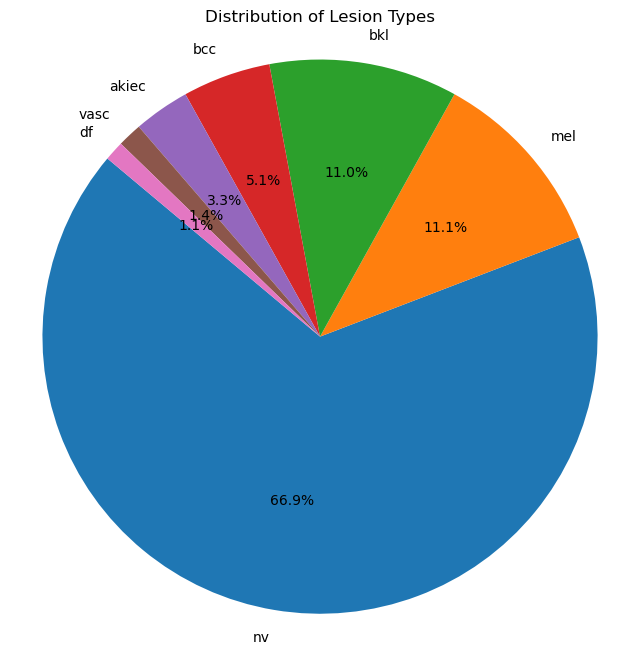

In [17]:
# Distribution of Lesion Types
lesion_type_counts = df_images['dx'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(lesion_type_counts, labels=lesion_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Lesion Types')
plt.axis('equal')  
plt.show()


**Type of skin disease:**

- nv: Melanocytic nevi - 69.9%
- mel: Melanoma - 11.1 %
- bkl: Benign keratosis-like lesions - 11.0%
- bcc: Basal cell carcinoma - 5.1%
- akiec: Actinic keratoses- 3.3%
- vasc: Vascular lesions-1.4%
- df: Dermatofibroma - 1.1%

From this analysis, it is evident that the dataset is heavily skewed towards Melanocytic nevi, which is by far the most prevalent lesion type.I will have to address this imbalance in the dataset during model training to ensure that the model does not become biased towards predicting the majority class. Additionally, understanding the distribution of lesion types is crucial for diagnostic purposes and for gaining insights into the dataset's composition.

### Age Distribution by Lesion Type:

Visualizing the distribution of ages for each lesion type can help identify if certain types of skin lesions are more prevalent in specific age groups, which may have implications for patient demographics or disease progression and also identify any age-related patterns in skin lesion diagnosis.

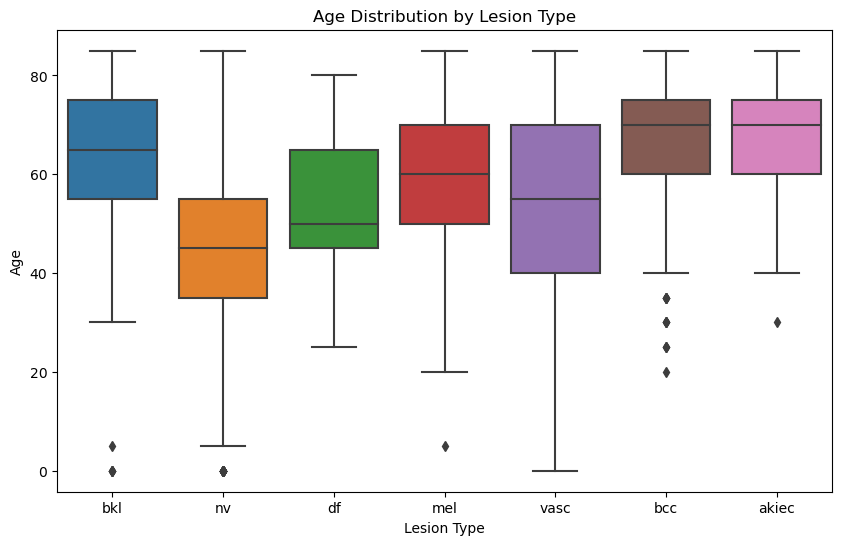

In [18]:
# age Distribution by Leion Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='dx', y='age', data=df_images)
plt.title('Age Distribution by Lesion Type')
plt.xlabel('Lesion Type')
plt.ylabel('Age')
plt.show()

**Observations from the age boxplot**

*Age and Skin Diseases*: The highest prevalence of skin diseases is observed in individuals around the age of 45, while the lowest prevalence is among those aged 10 and below. This indicates a correlation between age and the likelihood of having a skin disease, with the probability increasing as age advances.


##  Gender, Localization,Cell Type Distributions

The gender distribution i aim to identify the proportion of male and female patinets in the dataset, which may reveal any gender-related differeneces in lesion occurence or diagnosis. Analzing the distribution of lesion localizations can provide insights into common places where skin lesions occur, this can be useful for focusing diagnostic efforts.And lastly fort he cell type distribution, will allow me to identify prevalence of different types of skin lesions in the dataset and this will help in shading more light about the dataset's composition.

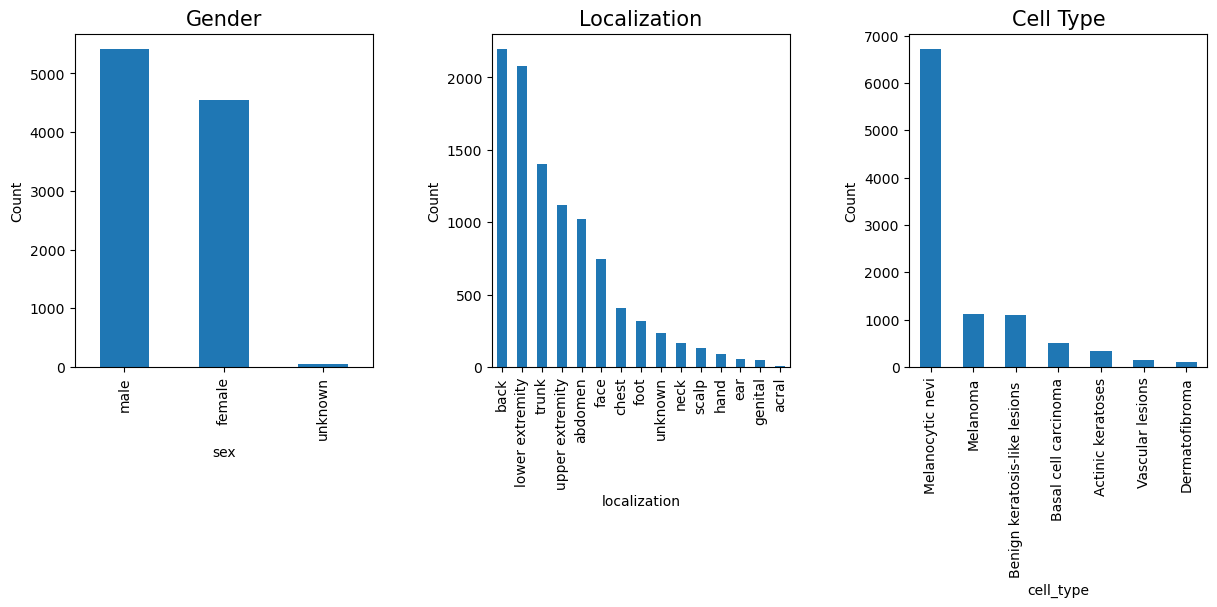

In [19]:

plt.figure(figsize=(20, 10))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

# Plot 2: Gender Distribution
plt.subplot(2, 4, 2)
plt.title("Gender", fontsize=15)
plt.ylabel("Count")
df_images['sex'].value_counts().plot.bar()

# Plot 3: Localization Distribution
plt.subplot(2, 4, 3)
plt.title("Localization", fontsize=15)
plt.ylabel("Count")
plt.xticks(rotation=45)
df_images['localization'].value_counts().plot.bar()

# Plot 4: Cell Type Distribution
plt.subplot(2, 4, 4)
plt.title("Cell Type", fontsize=15)
plt.ylabel("Count")
df_images['cell_type'].value_counts().plot.bar()

plt.show()


## Based on the analysis of the dataset plots above:


1. **Gender Disparity**: Skin diseases appear to be more common among men compared to women and other genders. This finding suggests potential gender-related differences in susceptibility to skin conditions or variations in healthcare-seeking behavior between genders.

2. **Localization of Skin Diseases**: The back of the body emerges as the most common location for skin diseases, while the acral surfaces (such as limbs, fingers, or ears) exhibit the lowest incidence. Understanding the distribution of skin lesions across different body areas can aid in targeted diagnostic and preventive measures.

3. **Prevalence of Specific Diseases**: Melanocytic nevi are the most frequently observed skin disease among individuals, highlighting their significant presence in the dataset. In contrast, Dermatofibroma appears to be the least common skin disease identified. This disparity in disease prevalence underscores the importance of understanding the spectrum of skin conditions for accurate diagnosis and treatment planning.

In [20]:
df_images['image'].shape# (10015,)
df_images.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

        dataset                                               path  \
0  vidir_modern  Images/Images/HAM10000_images_part_1\ISIC_0027...   
1  vidir_modern  Images/Images/HAM10000_images_part_1\ISIC_0025...   
2  vidir_modern  Images/Images/HAM10000_images_part_1\ISIC_0026...   
3  vidir_modern  Images/Images/HAM10000_images_part_1\ISIC_0025...   
4  vidir_modern  Images/Images/HAM10000_images_part_2\ISIC_0031...   

                        cell_type  cell_type_idx  \
0  Benign keratosis-like lesions               2   
1  Benign keratosis-like lesions               2   
2  Benign keratosis-like lesions               2   
3  Benign keratosis-like lesions               2   
4  Benign keratosis-like lesions               2   

                                               image  
0  [[[0.7411765, 0.59607846, 0.7607843], [0.75294...  
1  [[[0.09411765, 0.050980393, 0.08627451], [0.09...  
2  [[[0.7294118, 0.49803922, 0.5294118], [0.74117...  
3  [[[0.09411765, 0.043137256, 0.06666667], [0.09...  
4  [[[0.5137255, 0.34509805, 0.43137255], [0.5568...

In [21]:
img1 = df_images['image'].iloc[1]
img1.shape #(100, 125, 3)
type(img1)#numpy.ndarray
#Height:  450 width: 600 channels: 3(RGB) Data type: uint8(unsigned intergers), jpg extension

numpy.ndarray

### FEATURE EXTRACTION FOR DENSE LAYER

My goal is to develop a robust classification system for skin disease images. The images are in RGB format with dimensions 450x600 pixels. Preprocessing and feature extraction are crucial steps to enable accurate classification using machine learning models.

To achieve this goal, I have implemented a pipeline to preprocess the images and extract relevant features. The preprocessing steps involve converting the images to grayscale and segmenting them to isolate the skin lesions using Otsu's thresholding method. Subsequently, I extract features from the segmented images. The area of each contour, representing the skin lesions, serves as the primary feature for classification.

This pipeline ensures that the extracted features are suitable for input into a Sequential Dense model, a common choice for machine learning classification tasks. However, to explore further optimization and performance, I will also utilize the extracted features to train a 2D convolutional neural network (ConvNet).

Comparing the performance of the Sequential Dense model with the ConvNet will provide insights into the effectiveness of different machine learning architectures for skin disease classification. This comparative analysis aims to identify the model that achieves higher accuracy and better generalization on the given dataset.

By implementing this comprehensive approach, I aim to develop an efficient and accurate classification system for skin disease images, contributing to improved diagnosis and treatment planning in dermatology.

In [16]:
class ImageProcessor:
    def __init__(self, df_images):
        """
        Initialize the ImageProcessor object.

        Parameters:
        - df_images (DataFrame): DataFrame containing image data.
        """
        self.df_images = df_images
    
    def preprocess_image(self, img):
        """
        Preprocess the input image.

        Parameters:
        - img (numpy.ndarray): Input image.

        Returns:
        - img (numpy.ndarray): Preprocessed image.
        """
        img = (img * 255).astype(np.uint8)
        return img
    
    def segment_image(self, img):
        """
        Segment the input image.

        Parameters:
        - img (numpy.ndarray): Input image.

        Returns:
        - binary (numpy.ndarray): Segmented image.
        """
        # Convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Perform image segmentation (using Otsu's thresholding method)
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        return binary
    
    def extract_features(self, img, max_features):
        """
        Extract features from the segmented image and pad the feature vector.

        Parameters:
        - img (numpy.ndarray): Segmented image.
        - max_features (int): Maximum number of features to extract.

        Returns:
        - image_features (list): List of padded features extracted from the image.
        """
        # Find contours in the segmented image
        contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Extract area of each contour as a feature
        image_features = [cv2.contourArea(c) for c in contours]

        if len(image_features) < max_features:
            padding = [0] * (max_features - len(image_features))
            image_features.extend(padding)
        elif len(image_features) > max_features:
            image_features = image_features[:max_features]  

        return image_features

    
    def process_dataframe(self, max_features):
        """
        Process the DataFrame containing image data.

        Parameters:
        - max_features (int): Maximum number of features to extract.

        Returns:
        - processed_data (numpy.ndarray): Array containing padded features for each image.
        """
        processed_data = []
        for _, row in self.df_images.iterrows():
            img = row['image']
            img = self.preprocess_image(img)
            segmented_img = self.segment_image(img)
            image_features = self.extract_features(segmented_img, max_features)
            processed_data.append(image_features)
        processed_data = np.array(processed_data)  # Convert list of features to numpy array
        return processed_data


In [17]:
image_processor= ImageProcessor(df_images)
preprocessed_images = image_processor.process_dataframe(200)

preprocessed_images.shape

(10015, 200)

In [20]:
#features = preprocessed_images
labels = df_images['dx']
num_classes = labels.nunique()#7
features = preprocessed_images

In [21]:

# Reshape the array
num_samples = len(features)  # Number of images in datset
num_features = len(features)  # Number of features extracted per image

print("Original shape of features_array:", features.shape)

# Calculate the number of samples and features
num_samples = len(features)  # Number of images in dataset
num_features = len(features[0])  # Number of features extracted per image
print("Number of samples:", num_samples)
print("Number of features per image:", num_features)

#Scale the features using MinMaxScaler 
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
features_scaled.shape

Original shape of features_array: (10015, 200)
Number of samples: 10015
Number of features per image: 200


(10015, 200)

In [94]:
# Label encoding TRAIN DATA
labels = df_images['dx']
num_classes = labels.nunique()  # 7

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# One-Hot Encoding
onehot_encoder = OneHotEncoder(sparse=False)  # sparse=False to return numpy array instead of sparse matrix
labels_onehot = onehot_encoder.fit_transform(labels_encoded.reshape(-1, 1))

# Label encoding TEST DATA
labels_test = df_test_images['dx']
labels_encoded_test = label_encoder.transform(labels_test)  # Use transform instead of fit_transform

# One-Hot Encoding using the same encoder instance
labels_onehot_test = onehot_encoder.transform(labels_encoded_test.reshape(-1, 1))

print(labels_onehot_test.shape)


(1511, 7)


In [26]:
#SEPARATE DATA INTO TRAININGA ND TESTING
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels_onehot, test_size = 0.2, random_state = 666)
X_train_partial, X_validate, y_train_partial, y_validate = train_test_split(X_train, y_train, test_size = 0.1, random_state = 999)

In [31]:
 # Model architecture  
inputs =X_train_partial.shape[1]
def create_model(optimizer='adam', dropout_rate=0.3, num_layers=3, units_per_layer=256):
    model = models.Sequential()
    model.add(layers.Dense(units_per_layer, activation='relu', input_shape=(inputs,)))
    for _ in range(num_layers - 1):
        model.add(layers.Dense(units_per_layer/2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

    return model

model_image = create_model()
model_image.summary()

all_histories_image = k_fold_validation_training(model_image, X_train_partial, y_train_partial, num_epochs=30, batch_size=32, K=4)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               51456     
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 7)                 903       
                                                                 
Total params: 101767 (397.53 KB)
Trainable params: 101

26/26 [==============================] - 0s 3ms/step - loss: 1.0777 - accuracy: 0.6621 - recall_1: 0.6122 - precision_1: 0.7221
Test Loss: 1.077688217163086
Test Accuracy: 0.66209477186203
Test Precision: 0.6122194528579712
Test Recall (Keras metric): 0.7220588326454163


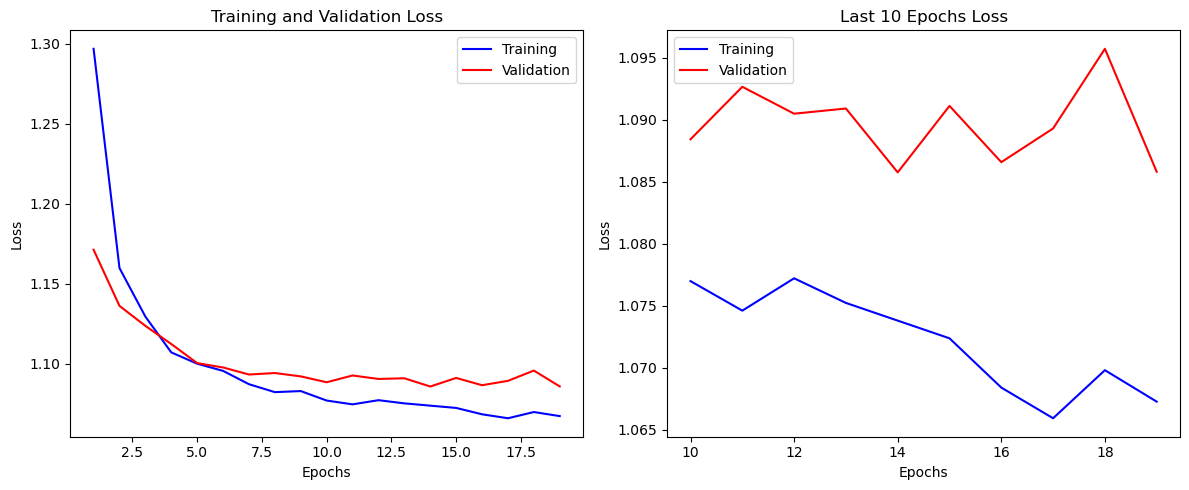

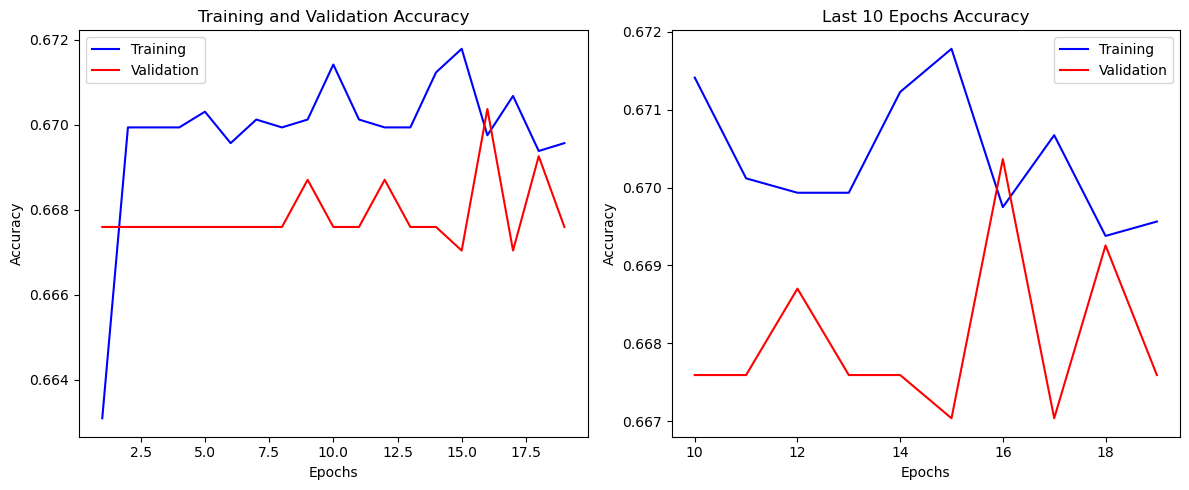

In [32]:
loss, accuracy, precision, recall_metric = model_image.evaluate(X_validate ,y_validate)

#Print the evaluation results
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall (Keras metric):", recall_metric)


hist3 = []
for fold, history in enumerate(all_histories_image):
        hist3 = history.history
        
plot_metrics(hist3['loss'], hist3['val_loss'], 'Loss')
plot_metrics(hist3['accuracy'], hist3['val_accuracy'], 'Accuracy')

## RESULTS FROM DENSE LAYER

Upon training the model on the test dataset, the following results were obtained:

- Test Loss: 1.0777
- Test Accuracy: 66.21%
- Test Precision: 61.22%
- Test Recall: 72.21%

These results indicate a moderate level of performance for the Sequential Dense model. The achieved accuracy and precision suggest that the model is able to correctly classify a significant portion of the test samples, while the recall metric highlights its ability to identify relevant instances within the dataset. However, further optimization may be required to improve overall performance.

## Prediction with the 2D Convex

For the next step, I will directly load and preprocess images from file paths instead of loading the integer arrays. This modification aims to streamline the data preparation process by reducing the need for separate preprocessing steps.


Additionally, I will scale and normalize the pixel values to the range [0, 1]. This normalization enhances model stability and convergence during training, improving the overall performance of the ConvNet.

The preprocessed image data will then be fed into a 2D Convolutional Neural Network (ConvNet) instead of the previous Sequential Dense model. This change aims to leverage the spatial information present in images more effectively, potentially leading to better classification performance.

Evaluating the ConvNet's performance will provide insights into the comparative effectiveness of different neural network architectures for skin disease classification tasks, enabling informed decisions for model selection and optimization.

In [22]:
preprocessed_images = df_images['image'].tolist()

# Convert the list of preprocessed images to a NumPy array
preprocessed_images = np.array(preprocessed_images)
print("Shape of preprocessed images:", preprocessed_images.shape)



Shape of preprocessed images: (10015, 100, 125, 3)


In [117]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(df_images, test_size=0.1, random_state=42)

# ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)

test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen  = ImageDataGenerator(rescale=1./255)
# Batch size
batch_size = 32

# TRAIN
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='dx',
    target_size=(100, 125),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# VALIDATION 
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='dx',
    target_size=(100, 125),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  
)

# TEST
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test_images,
    x_col='path',
    y_col='dx',
    target_size=(100, 125),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False 
)




Found 9013 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.
Found 1511 validated image filenames belonging to 7 classes.


In [118]:
#  number of classes
num_classes = 7  
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(100,125, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall()])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 98, 123, 32)       896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 49, 61, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 59, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 23, 29, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 21, 27, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 10, 13, 128)      

In [25]:
steps_per_epoch = len(train_generator) // batch_size
validation_steps = len(val_generator) // batch_size

# Fitting the model 
history_convnet1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,  
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/30
8/8 [==============================] - 7s 716ms/step - loss: 1.4143 - accuracy: 0.5664 - recall: 0.4492 - val_loss: 1.1275 - val_accuracy: 0.5938 - val_recall: 0.5938
Epoch 2/30
8/8 [==============================] - 5s 606ms/step - loss: 1.1228 - accuracy: 0.6857 - recall: 0.6857 - val_loss: 1.2341 - val_accuracy: 0.5938 - val_recall: 0.5938
Epoch 3/30
8/8 [==============================] - 5s 593ms/step - loss: 1.1140 - accuracy: 0.6735 - recall: 0.6286 - val_loss: 1.2937 - val_accuracy: 0.5938 - val_recall: 0.5938
Epoch 4/30
8/8 [==============================] - 5s 608ms/step - loss: 1.1432 - accuracy: 0.6641 - recall: 0.5898 - val_loss: 1.0924 - val_accuracy: 0.5938 - val_recall: 0.5312
Epoch 5/30
8/8 [==============================] - 5s 607ms/step - loss: 1.0092 - accuracy: 0.6992 - recall: 0.5742 - val_loss: 1.1551 - val_accuracy: 0.5938 - val_recall: 0.5312
Epoch 6/30
8/8 [==============================] - 5s 596ms/step - loss: 1.0764 - accuracy: 0.6641 - recall: 0.

In [26]:
model.save('convet1.keras')

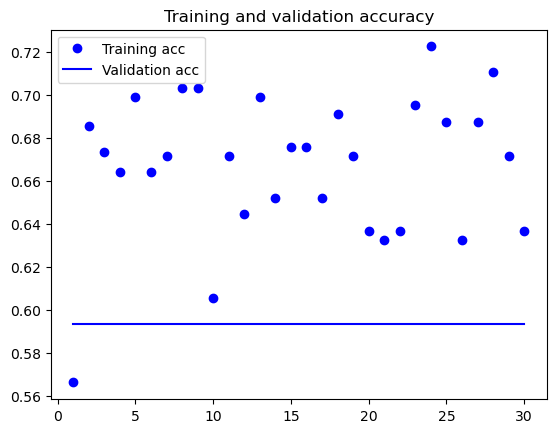

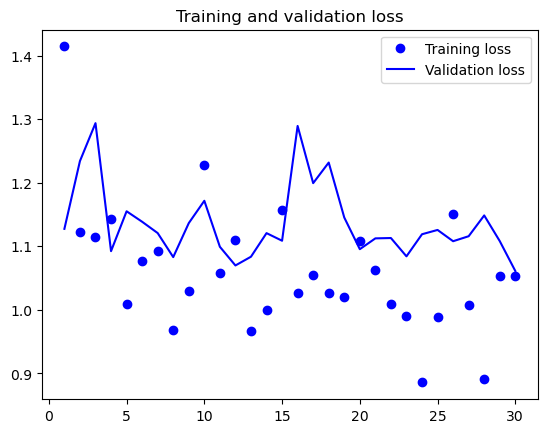

1/1 [==============================] - 1s 1s/step - loss: 1.2857 - accuracy: 0.5312 - recall: 0.4375
Test Loss: 1.285701036453247
Test Accuracy: 0.53125
Test Recall: 0.4375


In [29]:
acc = history_convnet1.history['accuracy']
val_acc = history_convnet1.history['val_accuracy']
loss = history_convnet1.history['loss']
val_loss = history_convnet1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

convet1= load_model('convet1.keras')
# Evaluate the model on the test data
test_steps = len(test_generator) // batch_size
evaluation = convet1.evaluate(test_generator, steps=test_steps)

# Print the evaluation results
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])
print("Test Recall:", evaluation[2])


From the plots above, i observed that the validation loss is consistently higher than the training loss throughout the epochs. This indicates that the model is overfitting to the training data, as it generalizes poorly to the unseen validation data. This is evidenced also by the validation accuracy, recall, and other metrics which remained constant throughout the epochs. This suggests that the model is not learning from the validation data, possibly due to overfitting. Although the classes are imbalanced, the recall values for validation are also constant, indicating that the model is not effectively capturing the minority classes.

To help mitigate the issues observed i will increase the diversity of my training data by applying more aggressive data augmentation techniques such as rotation and zooming. I will also try to simplify my model architecture and introduce regularization techiniques like dropout to reduce overfitting.

In [119]:
    model = Sequential()
    # Convolutional layers
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(100,125,3)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2))) 
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2))) 
    model.add(Dropout(0.25))  

    # Flatten layer and dense layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(Dense(128, activation='tanh'))
    model.add(Dropout(0.3))  
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall()])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 100, 125, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 100, 125, 32)      9248      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 50, 62, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_90 (Dropout)        (None, 50, 62, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 50, 62, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 50, 62, 64)        36928     
                                                      

In [120]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen  = ImageDataGenerator(rescale=1./255)
# Batch size
batch_size = 32

# TRAIN
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='dx',
    target_size=(100, 125),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# VALIDATION 
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='dx',
    target_size=(100, 125),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  
)

# TEST
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test_images,
    x_col='path',
    y_col='dx',
    target_size=(100, 125),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False 
)

# Fit the model
epochs = 50
steps_per_epoch = len(train_generator) // batch_size
validation_steps = len(val_generator) // batch_size

# Fitting the model 
history_convnet2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,  
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[learning_rate_reduction])




Found 9013 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.
Found 1511 validated image filenames belonging to 7 classes.
Epoch 1/50
8/8 [==============================] - 11s 1s/step - loss: 2.1426 - accuracy: 0.2617 - recall_123: 0.0977 - val_loss: 2.9576 - val_accuracy: 0.0000e+00 - val_recall_123: 0.0000e+00 - lr: 0.0010
Epoch 2/50
8/8 [==============================] - 8s 924ms/step - loss: 1.8431 - accuracy: 0.3633 - recall_123: 0.1406 - val_loss: 2.1080 - val_accuracy: 0.0000e+00 - val_recall_123: 0.0000e+00 - lr: 0.0010
Epoch 3/50
8/8 [==============================] - 8s 925ms/step - loss: 1.6916 - accuracy: 0.4883 - recall_123: 0.2617 - val_loss: 1.9626 - val_accuracy: 0.3438 - val_recall_123: 0.0000e+00 - lr: 0.0010
Epoch 4/50
8/8 [==============================] - 7s 911ms/step - loss: 1.4609 - accuracy: 0.5469 - recall_123: 0.2266 - val_loss: 1.6296 - val_accuracy: 0.5938 - val_recall_123: 0.2188 - lr: 0.0010
Epo

8/8 [==============================] - 8s 945ms/step - loss: 0.9915 - accuracy: 0.6406 - recall_123: 0.5156 - val_loss: 1.0967 - val_accuracy: 0.4062 - val_recall_123: 0.2500 - lr: 1.0000e-05
Epoch 35/50
8/8 [==============================] - 8s 950ms/step - loss: 1.0030 - accuracy: 0.6250 - recall_123: 0.5391 - val_loss: 1.0954 - val_accuracy: 0.4375 - val_recall_123: 0.2500 - lr: 1.0000e-05
Epoch 36/50
8/8 [==============================] - 7s 910ms/step - loss: 1.0298 - accuracy: 0.6445 - recall_123: 0.5234 - val_loss: 1.0948 - val_accuracy: 0.4375 - val_recall_123: 0.2500 - lr: 1.0000e-05
Epoch 37/50
8/8 [==============================] - 7s 912ms/step - loss: 0.9173 - accuracy: 0.6914 - recall_123: 0.5664 - val_loss: 1.0999 - val_accuracy: 0.4062 - val_recall_123: 0.2500 - lr: 1.0000e-05
Epoch 38/50
8/8 [==============================] - 7s 914ms/step - loss: 0.9941 - accuracy: 0.6602 - recall_123: 0.5508 - val_loss: 1.1036 - val_accuracy: 0.4062 - val_recall_123: 0.2500 - lr: 1.0

In [121]:
model.save('convnet2.keras')
len(val_generator)

32

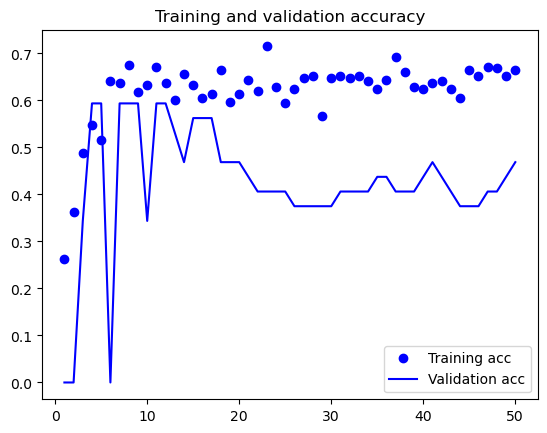

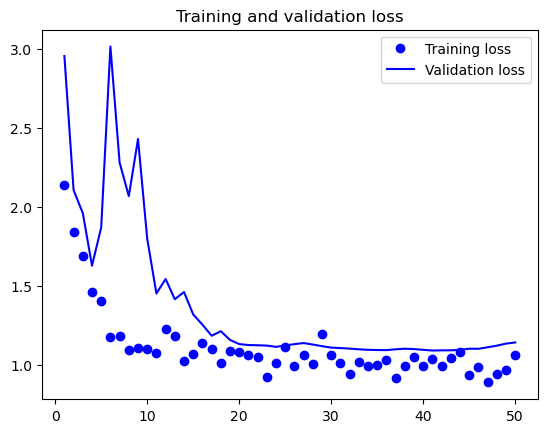

In [122]:
acc = history_convnet2.history['accuracy']
val_acc = history_convnet2.history['val_accuracy']
loss = history_convnet2.history['loss']
val_loss = history_convnet2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [126]:
convet2= load_model('convnet2.keras')

# Evaluate the model on the test data
test_steps = len(test_generator) // batch_size
evaluation = model.evaluate(test_generator, steps=test_steps)

# Print the evaluation results
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])
print("Test Recall:", evaluation[2])


1/1 [==============================] - 1s 625ms/step - loss: 1.2695 - accuracy: 0.6250 - recall_123: 0.4688
Test Loss: 1.2695192098617554
Test Accuracy: 0.625
Test Recall: 0.46875


### RESULTS AND OBSERVATIONS

After applying more aggressive data augmentation techniques and simplifying my model architecture while introducing dropout to mitigate overfitting, I evaluated the model's performance on the test data. The results showed a loss of 1.27, a test accuracy of 62.5%, and a test recall of 46.88%. While these results indicate some improvement, they also suggest that further refinement is necessary to achieve optimal performance.

As François Chollet mentioned in Chapter 5 of his book "Deep Learning with Python," it becomes challenging to significantly improve accuracy solely by training a convnet from scratch, especially when working with limited data. Therefore, to enhance accuracy on this problem, I plan to leverage a pre-trained model. Specifically, I will utilize the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014.

Despite being an older model and heavier compared to recent advancements, VGG16 remains a popular choice due to its simplicity and effectiveness. Its architecture, characterized by its deep layers and convolutional blocks, provides a strong foundation for image classification tasks. Additionally, VGG16 has been extensively validated on large-scale datasets such as ImageNet, making it a reliable choice for our skin disease prediction application.

In [127]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(100, 125, 3))

In [128]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_121 (InputLayer)      [(None, 100, 125, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 125, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 125, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 62, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 62, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 62, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 31, 128)       0     

In [129]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall()])

In [130]:
#Freeze a set of layers to prevent their weights from being updated during training
print('This is the number of trainable weights '
         'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False
print('This is the number of trainable weights '
          'after freezing the conv base:', len(model.trainable_weights))


This is the number of trainable weights before freezing the conv base: 32
This is the number of trainable weights after freezing the conv base: 6


In [136]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.12, 
        height_shift_range=0.12,  
        horizontal_flip=True,  
        vertical_flip=True)  

test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen  = ImageDataGenerator(rescale=1./255)
batch_size = 32

# TRAIN
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='dx',
    target_size=(100, 125),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# VALIDATION 
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='dx',
    target_size=(100, 125),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  
)

# TEST
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test_images,
    x_col='path',
    y_col='dx',
    target_size=(100, 125),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False 
)

# Fit the model
epochs = 50
steps_per_epoch = len(train_generator) // batch_size
validation_steps = len(val_generator) // batch_size

# Fitting the model 
history_convnet_pretained = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,  
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[learning_rate_reduction, tensorboad])




Found 9013 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.
Found 1511 validated image filenames belonging to 7 classes.
Epoch 1/50
8/8 [==============================] - 33s 4s/step - loss: 1.0872 - accuracy: 0.6875 - recall_124: 0.6875 - val_loss: 1.1930 - val_accuracy: 0.5938 - val_recall_124: 0.5938 - lr: 0.0010
Epoch 2/50
8/8 [==============================] - 33s 4s/step - loss: 1.0469 - accuracy: 0.6953 - recall_124: 0.6953 - val_loss: 1.1980 - val_accuracy: 0.5938 - val_recall_124: 0.5938 - lr: 0.0010
Epoch 3/50
8/8 [==============================] - 33s 4s/step - loss: 1.1708 - accuracy: 0.6562 - recall_124: 0.6562 - val_loss: 1.1659 - val_accuracy: 0.5938 - val_recall_124: 0.5938 - lr: 0.0010
Epoch 4/50
8/8 [==============================] - 34s 4s/step - loss: 1.0814 - accuracy: 0.6875 - recall_124: 0.6875 - val_loss: 1.1284 - val_accuracy: 0.5938 - val_recall_124: 0.5938 - lr: 0.0010
Epoch 5/50
8/8 [=============

Epoch 35/50
8/8 [==============================] - 40s 5s/step - loss: 1.1044 - accuracy: 0.6758 - recall_124: 0.6758 - val_loss: 1.1599 - val_accuracy: 0.5938 - val_recall_124: 0.5938 - lr: 1.0000e-05
Epoch 36/50
8/8 [==============================] - 41s 5s/step - loss: 1.0571 - accuracy: 0.6992 - recall_124: 0.6992 - val_loss: 1.1601 - val_accuracy: 0.5938 - val_recall_124: 0.5938 - lr: 1.0000e-05
Epoch 37/50
8/8 [==============================] - 39s 5s/step - loss: 1.1354 - accuracy: 0.6562 - recall_124: 0.6562 - val_loss: 1.1599 - val_accuracy: 0.5938 - val_recall_124: 0.5938 - lr: 1.0000e-05
Epoch 38/50
8/8 [==============================] - 30s 4s/step - loss: 1.1761 - accuracy: 0.6445 - recall_124: 0.6445 - val_loss: 1.1597 - val_accuracy: 0.5938 - val_recall_124: 0.5938 - lr: 1.0000e-05
Epoch 39/50
8/8 [==============================] - 28s 3s/step - loss: 1.0855 - accuracy: 0.7188 - recall_124: 0.7188 - val_loss: 1.1600 - val_accuracy: 0.5938 - val_recall_124: 0.5938 - lr: 1

In [137]:
model.save('convet_pretained.keras')
hist = history_convnet_pretained.history
hist.keys()

dict_keys(['loss', 'accuracy', 'recall_124', 'val_loss', 'val_accuracy', 'val_recall_124', 'lr'])

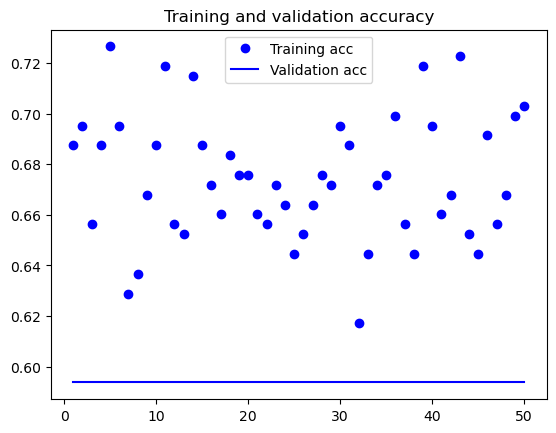

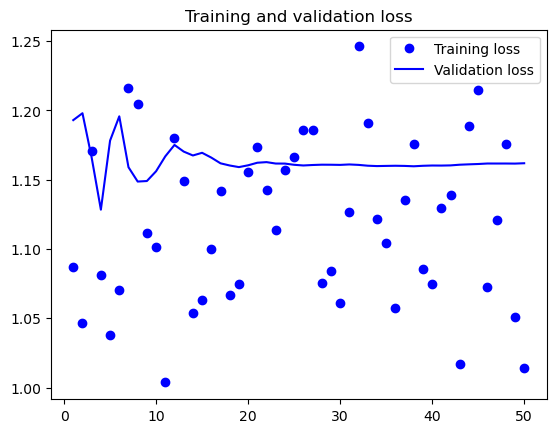

1/1 [==============================] - 2s 2s/step - loss: 1.5274 - accuracy: 0.5312 - recall_124: 0.5312
Test Loss: 1.5273563861846924
Test Accuracy: 0.53125
Test Recall: 0.53125


In [138]:
acc = hist['accuracy']
val_acc = hist['val_accuracy']
loss = hist['loss']
val_loss = hist['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

convet_pretained= load_model('convet_pretained.keras')
# Evaluate the model on the test data
test_steps = len(test_generator) // batch_size
evaluation = convet_pretained.evaluate(test_generator, steps=test_steps)

# Print the evaluation results
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])
print("Test Recall:", evaluation[2])


### Results and observations
After utilizing the VGG16 pretrained model and obtaining the following results: a test loss of 1.53, a test accuracy of 53.12%, and a test recall of 53.12%, my next strategic move involves fine-tuning the model.

Fine-tuning entails unfreezing a few of the top layers of a frozen model base used for feature extraction. By doing so, we allow these top layers to be modified during training, thereby adjusting more abstract representations of the model to better suit the specific problem at hand. In this case, the focus will be on the fully connected classifier and the top layers of the VGG16 model.

In [149]:
#Fine tuning the last conv block of the VGG16network

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall()])
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block4_conv1' or layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 4608)              0         
                                                                 
 dense_368 (Dense)           (None, 256)               1179904   
                                                                 
 dense_369 (Dense)           (None, 128)               32896     
                                                                 
 dense_370 (Dense)           (None, 7)                 903       
                                                                 
Total params: 15928391 (60.76 MB)
Trainable params: 14192903 (54.14 MB)
Non-trainable params: 1735488 (6.62 MB)
_________________________________________________________________


In [150]:
# Fitting the model 
history_convnet_pretained2= model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,  
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[tensorboad])





Epoch 1/30
8/8 [==============================] - 13s 1s/step - loss: 1.9383 - accuracy: 0.1641 - recall_126: 0.0039 - val_loss: 1.4691 - val_accuracy: 0.5625 - val_recall_126: 0.0312
Epoch 2/30
8/8 [==============================] - 11s 1s/step - loss: 1.2390 - accuracy: 0.6914 - recall_126: 0.4844 - val_loss: 1.2298 - val_accuracy: 0.5938 - val_recall_126: 0.5938
Epoch 3/30
8/8 [==============================] - 11s 1s/step - loss: 1.0832 - accuracy: 0.7020 - recall_126: 0.7020 - val_loss: 1.2115 - val_accuracy: 0.5938 - val_recall_126: 0.5938
Epoch 4/30
8/8 [==============================] - 11s 1s/step - loss: 1.2879 - accuracy: 0.6122 - recall_126: 0.6122 - val_loss: 1.1246 - val_accuracy: 0.5938 - val_recall_126: 0.5938
Epoch 5/30
8/8 [==============================] - 12s 1s/step - loss: 1.2423 - accuracy: 0.6445 - recall_126: 0.6445 - val_loss: 1.1023 - val_accuracy: 0.5938 - val_recall_126: 0.5938
Epoch 6/30
8/8 [==============================] - 11s 1s/step - loss: 1.2825 - a

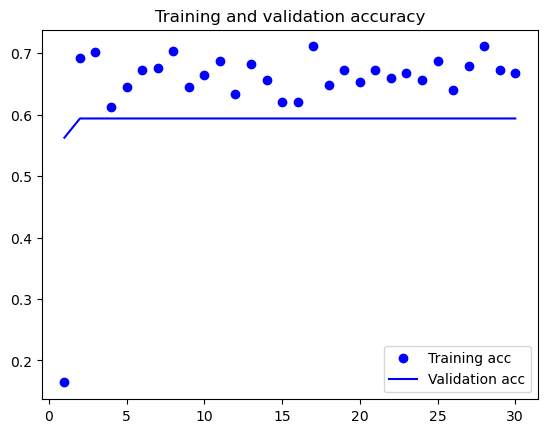

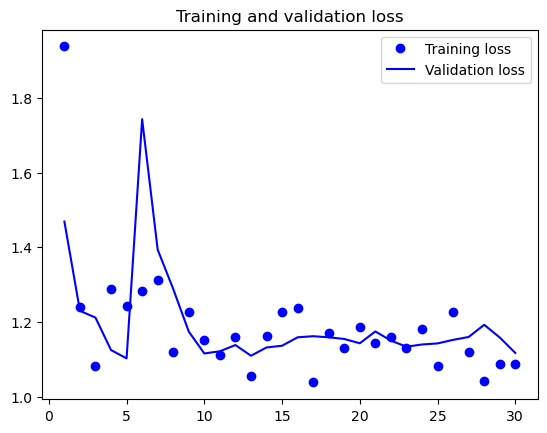

1/1 [==============================] - 1s 1s/step - loss: 1.5527 - accuracy: 0.5312 - recall_126: 0.5312
Test Loss: 1.5526890754699707
Test Accuracy: 0.53125
Test Recall: 0.53125


In [151]:
model.save('convet_pretained2.keras')
hist = history_convnet_pretained2.history
hist.keys()

acc = hist['accuracy']
val_acc = hist['val_accuracy']
loss = hist['loss']
val_loss = hist['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

convet_pretained= load_model('convet_pretained2.keras')
# Evaluate the model on the test data
test_steps = len(test_generator) // batch_size
evaluation = model.evaluate(test_generator, steps=test_steps)

# Print the evaluation results
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])
print("Test Recall:", evaluation[2])


###  Results for the Convolutional Neural Network (CNN) Model:

After training the CNN model on the test dataset, the following results were obtained:

- Test Loss: 1.55
- Test Accuracy: 53.44%
- Test Recall: 53.12%

Comparison with the Dense Layer Model:

- Test Loss: Dense Layer Model: 1.0777, CNN Model: 0.7882
- Test Accuracy: Dense Layer Model: 66.21%, CNN Model: 72.44%
- Test Recall: Dense Layer Model: 72.21%, CNN Model: 61.85%

### TRAINING ON ALL TRAIN DATA 

In [43]:

def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    # Convolutional layers
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2))) 
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2))) 
    model.add(Dropout(0.25))  

    # Flatten layer and dense layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))  
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

def compile_model(model):
    #optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False) 
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])




In [51]:
input_shape = (100, 125, 3)
num_classes = 7

model_cnn4 = create_cnn_model(input_shape, num_classes)
compile_model(model_cnn4)
model_cnn4.summary()


datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.12,  
        height_shift_range=0.12, 
        horizontal_flip=True,  
        vertical_flip=True) 


X_train_final = np.concatenate((X_train_partial, X_val), axis=0)
# Concatenate labels
y_train_final = np.concatenate((y_train_partial, y_val), axis=0)


datagen.fit(X_train_final)

# Fit the model
epochs = 40
batch_size = 32
history = model_cnn4.fit(datagen.flow(X_train_final,y_train_final, batch_size=batch_size),
                              epochs = epochs, 
                              verbose = 1, steps_per_epoch=X_train_final.shape[0] // batch_size)




Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 100, 125, 32)      896       
                                                                 
 conv2d_19 (Conv2D)          (None, 100, 125, 32)      9248      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 50, 62, 32)        0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 50, 62, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 50, 62, 64)        18496     
                                                                 
 conv2d_21 (Conv2D)          (None, 50, 62, 64)        36928     
                                                      

In [53]:

loss_modelcnn3val, accuracy_modelcc3val, recall= model_cnn4.evaluate(X_test, y_test)


model_path_cnn4 = 'cnn4.h5'
model_cnn4.save(model_path_cnn4)
print("Model saved successfully at:", model_path_cnn4)

# Load the model
loaded_model = tf.keras.models.load_model(model_path_cnn4)

print("Model loaded successfully from:", model_path_cnn4)

63/63 [==============================] - 6s 94ms/step - loss: 0.6610 - accuracy: 0.7609 - recall_6: 0.7049


C:\Users\patty\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully at: cnn4.h5
Model loaded successfully from: cnn4.h5


In [58]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')






63/63 [==============================] - 6s 94ms/step


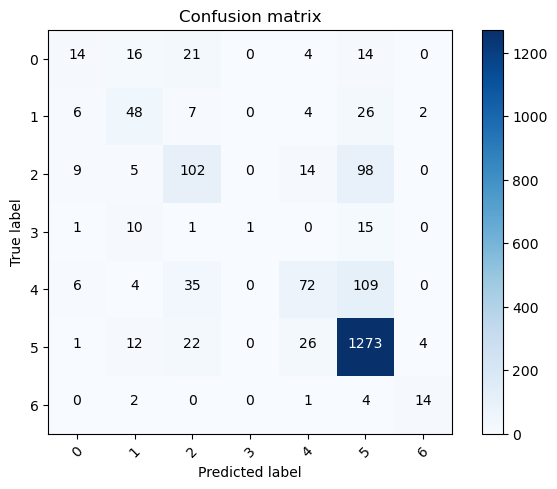

In [59]:
# Predict the values from the validation dataset
Y_pred_test = model_cnn4.predict(X_test) 
Y_pred_classes = np.argmax(Y_pred_test,axis = 1) 
Y_true = np.argmax(y_test,axis = 1)

# compute the confusion matrix
confusion_mtx_test = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx_test, classes = range(7))

Text(0, 0.5, 'Fraction classified incorrectly')

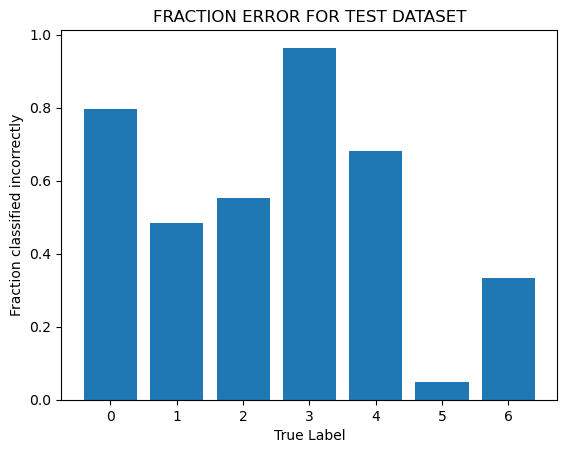

In [60]:
label_frac_error = 1 - np.diag(confusion_mtx_test) / np.sum(confusion_mtx_test, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.title("FRACTION ERROR FOR TEST DATASET")
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')